# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

## Project
---

Install packages that are not part of the basic virtual environment defined on the ReadMe.

Import relevant packages

In [2]:
from datasets import load_dataset, Audio,DatasetDict, Dataset, concatenate_datasets
import numpy as np
from transformers import AutoFeatureExtractor, TrainingArguments, Trainer,AutoConfig
import evaluate
import torch
import gc
from sklearn import metrics
import matplotlib.pyplot as plt
from model.AST_FineTunedModel import AST
import torchaudio
import pandas as pd
from tqdm import tqdm
import optuna
import os
import operator

Audio Augmentation on the dataset:
By using TorchAudio AudioEffector and FFmpeg effects, creating random new data.

In [3]:
# Auxiliry function that applies an effects(Audio augmentation) on a waveform
def apply_effect(waveform, sample_rate, effect, base_path, key_effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    new_wf = effector.apply(waveform, sample_rate)
    if waveform.shape[0] < new_wf.shape[0]:
      start_idx = np.random.randint(0, new_wf.shape[0] - waveform.shape[0])
      end_idx = start_idx + waveform.shape[0]
      new_wf = new_wf[start_idx:end_idx, :]
      assert new_wf.shape[0] == waveform.shape[0]
    new_path = base_path.replace(".wav",f".{key_effect}.wav")
    torchaudio.save(new_path, new_wf, sample_rate, channels_first=False)
    return new_path

# Display the spectrogram of a waveform
def show(result,sr, *, stereo=False):
    figsize = (6.4, 2.1 if stereo else 1.2)
    num_channels = result.size(1)
    f, ax = plt.subplots(num_channels, 1, squeeze=False, figsize=figsize, sharex=True)
    for i in range(num_channels):
        ax[i][0].specgram(result[:, i], Fs=sr)
    f.set_tight_layout(True)
    return result

# Add augmented samples to given datasets
def Audio_Augmentation(dataset):
  features = dataset.features
  new_data = {"file":[],"audio":[],"genre":[]}
  for i in tqdm(range(len(dataset))):
    file = dataset[i]
    # Upload the original audio waveform
    waveform , sr = torchaudio.load(file['file'], channels_first=False)
    # Create a random fast paced sample from the original audio
    fast_path = apply_effect(waveform,sr,f"atempo={np.random.randint(low=16,high=20)/10}",file["file"],"fast")
    # Create a random slow paced sample from the original audio
    slow_path = apply_effect(waveform,sr,f"atempo={np.random.randint(low=6,high=9)/10}",file["file"],"slow")
    # Create a random high pass filtered sample from the original audio
    highpass_path = apply_effect(waveform,sr,f"highpass=frequency={np.random.randint(low=1400,high=1600)}", file["file"], "highpass")
    # Create a random low pass filtered sample from the original audio
    lowpass_path = apply_effect(waveform,sr,f"lowpass=frequency={np.random.randint(low=900,high=1100)}", file["file"], "lowpass")
    # Create a sample from the original audio which contains echos of itself simulating a random sound barrier that reflects the sound 
    random_in_gain = np.random.randint(low=60,high=99)/100
    random_out_gain = np.random.randint(low=60,high=99)/100
    random_delay = np.random.randint(low=50,high=500)
    random_decay = np.random.randint(low=2,high=5)/10
    echo_path = apply_effect(waveform,sr,f"aecho=in_gain={random_in_gain}:out_gain={random_out_gain}:delays={random_delay}:decays={random_decay}", file["file"], "echo")
    # Create a mix of random augmentations sample from the original audio
    mix_effect = ",".join(
    [
        f"lowpass=frequency={np.random.randint(low=500,high=800)}:poles=1",  # apply single-pole lowpass filter
        f"atempo={np.random.randint(low=6,high=10)/10}",  # reduce the speed
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
        # Applying echo gives some dramatic feeling
    ],
)
    mix_path = apply_effect(waveform,sr,mix_effect, file["file"],"mix")
    # Adding the newly created samples to the original dataset
    new_paths = [fast_path, slow_path, highpass_path, lowpass_path, echo_path, mix_path]
    new_data["file"] += new_paths
    new_data["audio"] += [{"path":n_path}for n_path in new_paths]
    new_data["genre"] += [file["genre"]]*len(new_paths)
    new_data_df = pd.DataFrame(new_data)
  new_data_df = pd.DataFrame(new_data)
  new_data_dataset = Dataset.from_pandas(new_data_df).cast(features)
  new_dataset = concatenate_datasets([dataset, new_data_dataset])
  new_dataset.save_to_disk("updated_gtzan")
  return new_dataset

Get gtzan audio files and their corresponding labels from the Hugging Face Hub and split the dataset into training, validation and test sets.  
Then apply the augmentation scheme defined above.

In [4]:
gtzan = load_dataset("marsyas/gtzan", "all",trust_remote_code=True)
train_rest = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.2)
aug_train_set = Audio_Augmentation(train_rest["train"]).shuffle()
val_test = train_rest["test"].train_test_split(seed=42, shuffle=True, test_size=0.5)
###optuna_train=train_rest["train"].train_test_split(seed=42, shuffle=True, test_size=0.0)["train"]
gtzan=DatasetDict({"train": aug_train_set,"val": val_test["train"],"test": val_test["test"],"optuna_train":aug_train_set})

Saving the dataset (15/15 shards): 100%|██████████| 5593/5593 [02:38<00:00, 35.40 examples/s]


Get AST feature extractor which: 
1. Extracts mel-filter bank features from raw speech.
2. Pads/truncates the features to a fixed length.
3. Normalizes the features(Substracting mean and dividing by the standard deviation).

In [5]:
model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

Resample the dataset according to the pretrained AST sample rate.

In [6]:
sampling_rate = feature_extractor.sampling_rate
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

Apply AST feature extractor to the datasets. 

In [7]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)

Map: 100%|██████████| 5593/5593 [03:55<00:00, 23.74 examples/s]


Obtain the label mappings from the dataset.

In [8]:
id2label_fn = gtzan["train"].features["genre"].int2str
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")
id2label = {
    i: id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

Create accuracy calculation function. 

In [9]:
metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Get, adjust and train the AST pretrained model.

In [10]:
# Clean cuda cache
gc.collect()
torch.cuda.empty_cache()
# Define default hyperparameters
useOptuna=False
    # Model hyperparameters
    # No verification actions are performed on the following model hyperparametes.
model_config=AutoConfig.from_pretrained(model_id)
num_labels = len(id2label)
model_config.num_labels = num_labels
model_config.id2label=id2label
model_config.label2id=label2id
model_config.to_low_rank_layer_idx=[10,11] #0(first layer)-11(last layer)
model_config.low_rank_layer_rank=[2,2] #defines to_low_rank_layer[i] with low_rank_layer_rank[i] rank. list the same len as to_low_rank_layer.
model_config.low_rank_layer_alpha=[4.246988659186245,4.246988659186245] #defines to_low_rank_layer[i] with low_rank_layer_rank[i] alpha. list the same len as to_low_rank_layer.
model_config.dropout_rat=[0.05,0.1] # drop ratio of the two dropout layers in the classifier.
model_config.classifier_hidden_layer_size=200
    # Training method hyperparameters
batch_size = 2
gradient_accumulation_steps = 8
num_train_epochs = 13
learning_rate=0.00013220987667789097
warmup_ratio=0.08503471829118296
weight_decay=0.06762396226356811
# Instantiate default trainer arguments
model_name = model_id.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=warmup_ratio,
    weight_decay=weight_decay,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
    save_total_limit=1,
    report_to='tensorboard',
)
if useOptuna:
# Hyperparameters search with Optuna backend over Trainer API
    # Create a model initialization function with the model hyperparameters
    def model_init(trial):
        config=model_config
        if trial is not None:  
            if type(trial) is optuna.trial.Trial:
                min_layer_to_update = trial.suggest_int("encoder_min_layer_to_update", 10, 11) 
                rank=trial.suggest_int("encoder_update_rank", 1, 3)
                alpha=trial.suggest_float("encoder_update_alpha", 0.1, 10.0, log=True)
                hidden_size=trial.suggest_categorical("classifier_hidden_layer_size", [50,100,200])
            elif type(trial) is dict:
                for key, value in trial.items(): 
                    if key=="encoder_min_layer_to_update":
                        min_layer_to_update =value
                    elif key=="encoder_update_rank":
                        rank=value
                    elif key=="encoder_update_alpha":
                        alpha=value
                    elif key=="classifier_hidden_layer_size":
                        hidden_size=value
            config.to_low_rank_layer_idx=list(range(min_layer_to_update,12)) 
            config.low_rank_layer_rank=[rank]*len(config.to_low_rank_layer_idx)
            config.low_rank_layer_alpha=[alpha]*len(config.to_low_rank_layer_idx)
            config.classifier_hidden_layer_size=hidden_size
        return AST(config)
    # Define searched hyperparameters 
    def optuna_hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 5e-6, 5e-4, log=True),
            "per_device_train_batch_size": trial.suggest_categorical("batch_size", [2,4,8,16]),
            "warmup_ratio": trial.suggest_float("warmup_ratio", 0.01, 0.1),
            "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.15),
            "num_train_epochs": trial.suggest_int("num_train_epochs", 7, 20)
        }
    # Define trails Optuna objective as evaluation set accuracy
    def compute_objective(metrics):
        return metrics["eval_accuracy"]
    # Define SQLite database to enable study restoration
    storage_name="sqlite:///optuna_study.db"
    storage = optuna.storages.RDBStorage(
        url=storage_name,  # Save the study to an SQLite database file
        heartbeat_interval=60,  # Optional: To track trial status
        grace_period=120,       # Optional: Grace period for stale trials
    )
    # Instantiate a hyperparameters search trainer with dataset optuna_train(partial training set)
    trainer = Trainer(
        model=None,
        args=training_args,
        train_dataset=gtzan_encoded["optuna_train"].with_format("torch"),
        eval_dataset=gtzan_encoded["val"].with_format("torch"),
        tokenizer=feature_extractor,
        model_init=model_init,
        compute_metrics=compute_metrics,
    )
    # Hyperparameters search
    study_name="music_classification_on_AST_study"
    best_trial = trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        hp_space=optuna_hp_space,
        n_trials=5,
        compute_objective=compute_objective,
        storage=storage,  # Use the SQLite storage
        load_if_exists=True,  # Load the study if it already exists
        study_name=study_name,  # Name of the study
    )
    print(f"Best trial hyperparameters: {best_trial.hyperparameters}")
    print(f"Best evaluation accuracy: {best_trial.objective}")
    # Update default trainer arguments to the best trail trainer arguments
    for key, value in best_trial.hyperparameters.items(): 
        if key=='batch_size':
            key='per_device_train_batch_size'
        if hasattr(training_args, key): 
            old_attr = getattr(training_args, key, None) 
            # Casting value to the proper type 
            if old_attr is not None: 
                value = type(old_attr)(value) 
                ###if key=='num_train_epochs':
                ###    value=int(np.ceil(value*gtzan_encoded["mini_train"].num_rows/gtzan_encoded["train"].num_rows*5))
                setattr(training_args, key, value) 
    # Instantiate a model with best trail model hyperparameters
    model=model_init(best_trial.hyperparameters)
else:
    # Instantiate a model with default model hyperparameters
    model=AST(model_config)
# Instantiate the chosen trainer with the full training set
trainer =Trainer(
    model=model,
    args=training_args,
    train_dataset=gtzan_encoded["train"].with_format("torch"),
    eval_dataset=gtzan_encoded["val"].with_format("torch"),
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
# Train, save and evaluate the chosen model using the chosen trainer
trainer.train()
trainer.save_model('Best_Model')
eval_metrics = trainer.evaluate()
print("Final best model evaluation set performance metrics:")
print(eval_metrics)

c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  0%|          | 0/4537 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\transformers\models\audio_spectrogram_transformer\modeling_audio_spectrogram_transformer.py:187: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
  0%|          | 5/4537 [00:05<1:17:17,  1.02s/it]

{'loss': 2.4009, 'grad_norm': 6.071772575378418, 'learning_rate': 1.7125631694027327e-06, 'epoch': 0.01}


  0%|          | 10/4537 [00:10<1:12:47,  1.04it/s]

{'loss': 2.3055, 'grad_norm': 9.41571044921875, 'learning_rate': 3.4251263388054653e-06, 'epoch': 0.03}


  0%|          | 15/4537 [00:14<1:03:04,  1.19it/s]

{'loss': 2.3334, 'grad_norm': 7.840668201446533, 'learning_rate': 5.137689508208199e-06, 'epoch': 0.04}


  0%|          | 20/4537 [00:18<1:04:55,  1.16it/s]

{'loss': 2.3932, 'grad_norm': 6.5844221115112305, 'learning_rate': 6.850252677610931e-06, 'epoch': 0.06}


  1%|          | 25/4537 [00:23<1:08:42,  1.09it/s]

{'loss': 2.3228, 'grad_norm': 13.540072441101074, 'learning_rate': 8.562815847013663e-06, 'epoch': 0.07}


  1%|          | 30/4537 [00:27<1:09:18,  1.08it/s]

{'loss': 2.3482, 'grad_norm': 8.36092472076416, 'learning_rate': 1.0275379016416397e-05, 'epoch': 0.09}


  1%|          | 35/4537 [00:32<1:06:54,  1.12it/s]

{'loss': 2.3798, 'grad_norm': 7.799196720123291, 'learning_rate': 1.1987942185819131e-05, 'epoch': 0.1}


  1%|          | 40/4537 [00:36<1:07:34,  1.11it/s]

{'loss': 2.305, 'grad_norm': 6.0263752937316895, 'learning_rate': 1.3700505355221861e-05, 'epoch': 0.11}


  1%|          | 45/4537 [00:41<1:11:55,  1.04it/s]

{'loss': 2.3237, 'grad_norm': 7.191378593444824, 'learning_rate': 1.5413068524624597e-05, 'epoch': 0.13}


  1%|          | 50/4537 [00:46<1:06:32,  1.12it/s]

{'loss': 2.3061, 'grad_norm': 6.119791507720947, 'learning_rate': 1.7125631694027327e-05, 'epoch': 0.14}


  1%|          | 55/4537 [00:50<1:04:23,  1.16it/s]

{'loss': 2.2766, 'grad_norm': 6.614330291748047, 'learning_rate': 1.883819486343006e-05, 'epoch': 0.16}


  1%|▏         | 60/4537 [00:54<1:04:45,  1.15it/s]

{'loss': 2.272, 'grad_norm': 6.195340633392334, 'learning_rate': 2.0550758032832794e-05, 'epoch': 0.17}


  1%|▏         | 65/4537 [00:59<1:03:42,  1.17it/s]

{'loss': 2.2435, 'grad_norm': 7.8119049072265625, 'learning_rate': 2.2263321202235525e-05, 'epoch': 0.19}


  2%|▏         | 70/4537 [01:03<1:04:09,  1.16it/s]

{'loss': 2.2201, 'grad_norm': 6.230302333831787, 'learning_rate': 2.3975884371638262e-05, 'epoch': 0.2}


  2%|▏         | 75/4537 [01:07<1:02:36,  1.19it/s]

{'loss': 2.2096, 'grad_norm': 8.001875877380371, 'learning_rate': 2.5688447541040992e-05, 'epoch': 0.21}


  2%|▏         | 80/4537 [01:12<1:03:54,  1.16it/s]

{'loss': 2.1704, 'grad_norm': 7.3850417137146, 'learning_rate': 2.7401010710443722e-05, 'epoch': 0.23}


  2%|▏         | 85/4537 [01:16<1:04:49,  1.14it/s]

{'loss': 2.0971, 'grad_norm': 7.196780681610107, 'learning_rate': 2.911357387984646e-05, 'epoch': 0.24}


  2%|▏         | 90/4537 [01:20<1:03:41,  1.16it/s]

{'loss': 2.0424, 'grad_norm': 6.551732063293457, 'learning_rate': 3.082613704924919e-05, 'epoch': 0.26}


  2%|▏         | 95/4537 [01:25<1:03:39,  1.16it/s]

{'loss': 2.0718, 'grad_norm': 6.83389949798584, 'learning_rate': 3.253870021865192e-05, 'epoch': 0.27}


  2%|▏         | 100/4537 [01:29<1:03:22,  1.17it/s]

{'loss': 2.0164, 'grad_norm': 7.611441612243652, 'learning_rate': 3.4251263388054654e-05, 'epoch': 0.29}


  2%|▏         | 105/4537 [01:33<1:03:39,  1.16it/s]

{'loss': 1.9775, 'grad_norm': 9.296631813049316, 'learning_rate': 3.5963826557457394e-05, 'epoch': 0.3}


  2%|▏         | 110/4537 [01:37<1:03:29,  1.16it/s]

{'loss': 1.8923, 'grad_norm': 7.761239528656006, 'learning_rate': 3.767638972686012e-05, 'epoch': 0.31}


  3%|▎         | 115/4537 [01:42<1:02:43,  1.17it/s]

{'loss': 1.8746, 'grad_norm': 7.6617937088012695, 'learning_rate': 3.9388952896262855e-05, 'epoch': 0.33}


  3%|▎         | 120/4537 [01:46<1:03:08,  1.17it/s]

{'loss': 1.8718, 'grad_norm': 8.454094886779785, 'learning_rate': 4.110151606566559e-05, 'epoch': 0.34}


  3%|▎         | 125/4537 [01:50<1:03:31,  1.16it/s]

{'loss': 1.7686, 'grad_norm': 7.210971832275391, 'learning_rate': 4.2814079235068316e-05, 'epoch': 0.36}


  3%|▎         | 130/4537 [01:55<1:03:39,  1.15it/s]

{'loss': 1.7264, 'grad_norm': 7.137506484985352, 'learning_rate': 4.452664240447105e-05, 'epoch': 0.37}


  3%|▎         | 135/4537 [01:59<1:03:10,  1.16it/s]

{'loss': 1.6717, 'grad_norm': 7.1565260887146, 'learning_rate': 4.623920557387379e-05, 'epoch': 0.39}


  3%|▎         | 140/4537 [02:03<1:03:46,  1.15it/s]

{'loss': 1.6597, 'grad_norm': 7.374500274658203, 'learning_rate': 4.7951768743276524e-05, 'epoch': 0.4}


  3%|▎         | 145/4537 [02:08<1:03:56,  1.14it/s]

{'loss': 1.5706, 'grad_norm': 7.394728660583496, 'learning_rate': 4.966433191267925e-05, 'epoch': 0.41}


  3%|▎         | 150/4537 [02:12<1:02:38,  1.17it/s]

{'loss': 1.5108, 'grad_norm': 7.515999794006348, 'learning_rate': 5.1376895082081984e-05, 'epoch': 0.43}


  3%|▎         | 155/4537 [02:16<1:02:45,  1.16it/s]

{'loss': 1.5256, 'grad_norm': 7.010464191436768, 'learning_rate': 5.308945825148472e-05, 'epoch': 0.44}


  4%|▎         | 160/4537 [02:21<1:02:46,  1.16it/s]

{'loss': 1.4891, 'grad_norm': 7.302310943603516, 'learning_rate': 5.4802021420887445e-05, 'epoch': 0.46}


  4%|▎         | 165/4537 [02:25<1:03:36,  1.15it/s]

{'loss': 1.4253, 'grad_norm': 11.32097339630127, 'learning_rate': 5.6514584590290185e-05, 'epoch': 0.47}


  4%|▎         | 170/4537 [02:29<1:02:55,  1.16it/s]

{'loss': 1.3167, 'grad_norm': 10.833127975463867, 'learning_rate': 5.822714775969292e-05, 'epoch': 0.49}


  4%|▍         | 175/4537 [02:34<1:03:05,  1.15it/s]

{'loss': 1.3326, 'grad_norm': 7.488839626312256, 'learning_rate': 5.9939710929095646e-05, 'epoch': 0.5}


  4%|▍         | 180/4537 [02:38<1:02:35,  1.16it/s]

{'loss': 1.2393, 'grad_norm': 9.164382934570312, 'learning_rate': 6.165227409849839e-05, 'epoch': 0.51}


  4%|▍         | 185/4537 [02:42<1:02:32,  1.16it/s]

{'loss': 1.2621, 'grad_norm': 10.040678977966309, 'learning_rate': 6.336483726790111e-05, 'epoch': 0.53}


  4%|▍         | 190/4537 [02:47<1:02:26,  1.16it/s]

{'loss': 1.2614, 'grad_norm': 10.265520095825195, 'learning_rate': 6.507740043730384e-05, 'epoch': 0.54}


  4%|▍         | 195/4537 [02:51<1:02:44,  1.15it/s]

{'loss': 1.2123, 'grad_norm': 10.53767204284668, 'learning_rate': 6.678996360670658e-05, 'epoch': 0.56}


  4%|▍         | 200/4537 [02:55<1:02:25,  1.16it/s]

{'loss': 1.1938, 'grad_norm': 8.117594718933105, 'learning_rate': 6.850252677610931e-05, 'epoch': 0.57}


  5%|▍         | 205/4537 [03:00<1:02:14,  1.16it/s]

{'loss': 1.2292, 'grad_norm': 10.052316665649414, 'learning_rate': 7.021508994551205e-05, 'epoch': 0.59}


  5%|▍         | 210/4537 [03:04<1:02:38,  1.15it/s]

{'loss': 0.973, 'grad_norm': 7.670577049255371, 'learning_rate': 7.192765311491479e-05, 'epoch': 0.6}


  5%|▍         | 215/4537 [03:08<1:02:26,  1.15it/s]

{'loss': 1.0779, 'grad_norm': 8.049229621887207, 'learning_rate': 7.364021628431752e-05, 'epoch': 0.61}


  5%|▍         | 220/4537 [03:12<59:25,  1.21it/s]  

{'loss': 1.0409, 'grad_norm': 9.819523811340332, 'learning_rate': 7.535277945372024e-05, 'epoch': 0.63}


  5%|▍         | 225/4537 [03:17<59:13,  1.21it/s]

{'loss': 1.0298, 'grad_norm': 12.612306594848633, 'learning_rate': 7.706534262312297e-05, 'epoch': 0.64}


  5%|▌         | 230/4537 [03:21<59:13,  1.21it/s]

{'loss': 0.9703, 'grad_norm': 11.873383522033691, 'learning_rate': 7.877790579252571e-05, 'epoch': 0.66}


  5%|▌         | 235/4537 [03:25<59:14,  1.21it/s]

{'loss': 1.0618, 'grad_norm': 13.597220420837402, 'learning_rate': 8.049046896192845e-05, 'epoch': 0.67}


  5%|▌         | 240/4537 [03:29<1:01:11,  1.17it/s]

{'loss': 0.9764, 'grad_norm': 11.669824600219727, 'learning_rate': 8.186051949745062e-05, 'epoch': 0.69}


  5%|▌         | 245/4537 [03:33<1:01:14,  1.17it/s]

{'loss': 0.8605, 'grad_norm': 8.99694538116455, 'learning_rate': 8.357308266685336e-05, 'epoch': 0.7}


  6%|▌         | 250/4537 [03:38<1:01:40,  1.16it/s]

{'loss': 0.8475, 'grad_norm': 9.637544631958008, 'learning_rate': 8.528564583625609e-05, 'epoch': 0.72}


  6%|▌         | 255/4537 [03:42<1:02:13,  1.15it/s]

{'loss': 0.8285, 'grad_norm': 12.710553169250488, 'learning_rate': 8.699820900565883e-05, 'epoch': 0.73}


  6%|▌         | 260/4537 [03:46<1:02:06,  1.15it/s]

{'loss': 0.837, 'grad_norm': 10.439367294311523, 'learning_rate': 8.871077217506157e-05, 'epoch': 0.74}


  6%|▌         | 265/4537 [03:51<1:01:29,  1.16it/s]

{'loss': 0.6546, 'grad_norm': 22.22664451599121, 'learning_rate': 9.042333534446429e-05, 'epoch': 0.76}


  6%|▌         | 270/4537 [03:55<1:01:54,  1.15it/s]

{'loss': 0.6853, 'grad_norm': 9.819526672363281, 'learning_rate': 9.213589851386703e-05, 'epoch': 0.77}


  6%|▌         | 275/4537 [04:00<1:01:43,  1.15it/s]

{'loss': 0.7505, 'grad_norm': 8.410088539123535, 'learning_rate': 9.384846168326975e-05, 'epoch': 0.79}


  6%|▌         | 280/4537 [04:04<1:01:55,  1.15it/s]

{'loss': 0.7856, 'grad_norm': 8.600457191467285, 'learning_rate': 9.55610248526725e-05, 'epoch': 0.8}


  6%|▋         | 285/4537 [04:08<1:01:34,  1.15it/s]

{'loss': 0.7181, 'grad_norm': 11.997739791870117, 'learning_rate': 9.727358802207522e-05, 'epoch': 0.82}


  6%|▋         | 290/4537 [04:13<1:01:49,  1.14it/s]

{'loss': 0.6149, 'grad_norm': 8.737153053283691, 'learning_rate': 9.898615119147796e-05, 'epoch': 0.83}


  7%|▋         | 295/4537 [04:17<1:01:41,  1.15it/s]

{'loss': 0.6899, 'grad_norm': 8.350008964538574, 'learning_rate': 0.0001006987143608807, 'epoch': 0.84}


  7%|▋         | 300/4537 [04:21<1:00:51,  1.16it/s]

{'loss': 0.8401, 'grad_norm': 12.659387588500977, 'learning_rate': 0.00010206876489640287, 'epoch': 0.86}


  7%|▋         | 305/4537 [04:26<1:03:37,  1.11it/s]

{'loss': 0.85, 'grad_norm': 12.042227745056152, 'learning_rate': 0.00010378132806580562, 'epoch': 0.87}


  7%|▋         | 310/4537 [04:30<1:01:09,  1.15it/s]

{'loss': 0.8337, 'grad_norm': 16.27903938293457, 'learning_rate': 0.00010549389123520834, 'epoch': 0.89}


  7%|▋         | 315/4537 [04:34<1:00:54,  1.16it/s]

{'loss': 0.7507, 'grad_norm': 13.041131019592285, 'learning_rate': 0.00010720645440461107, 'epoch': 0.9}


  7%|▋         | 320/4537 [04:39<1:01:05,  1.15it/s]

{'loss': 0.6651, 'grad_norm': 11.061626434326172, 'learning_rate': 0.00010891901757401381, 'epoch': 0.92}


  7%|▋         | 325/4537 [04:43<1:00:53,  1.15it/s]

{'loss': 0.6532, 'grad_norm': 10.183295249938965, 'learning_rate': 0.00011063158074341654, 'epoch': 0.93}


  7%|▋         | 330/4537 [04:47<1:00:34,  1.16it/s]

{'loss': 0.7595, 'grad_norm': 8.878154754638672, 'learning_rate': 0.00011234414391281928, 'epoch': 0.94}


  7%|▋         | 335/4537 [04:52<1:00:44,  1.15it/s]

{'loss': 0.5908, 'grad_norm': 8.33315658569336, 'learning_rate': 0.000114056707082222, 'epoch': 0.96}


  7%|▋         | 340/4537 [04:56<1:01:11,  1.14it/s]

{'loss': 0.6954, 'grad_norm': 9.990160942077637, 'learning_rate': 0.00011576927025162474, 'epoch': 0.97}


  8%|▊         | 345/4537 [05:01<1:02:57,  1.11it/s]

{'loss': 0.7546, 'grad_norm': 21.897727966308594, 'learning_rate': 0.00011748183342102749, 'epoch': 0.99}


                                                    
  8%|▊         | 349/4537 [05:10<1:01:18,  1.14it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6039706468582153, 'eval_accuracy': 0.82, 'eval_runtime': 4.9191, 'eval_samples_per_second': 20.329, 'eval_steps_per_second': 10.164, 'epoch': 1.0}


  8%|▊         | 350/4537 [05:10<2:52:49,  2.48s/it]

{'loss': 0.7062, 'grad_norm': 5.51027774810791, 'learning_rate': 0.0001191943965904302, 'epoch': 1.0}


  8%|▊         | 355/4537 [05:15<1:17:48,  1.12s/it]

{'loss': 0.6157, 'grad_norm': 13.502641677856445, 'learning_rate': 0.00012090695975983294, 'epoch': 1.02}


  8%|▊         | 360/4537 [05:19<59:36,  1.17it/s]  

{'loss': 0.4937, 'grad_norm': 14.684395790100098, 'learning_rate': 0.00012261952292923567, 'epoch': 1.03}


  8%|▊         | 365/4537 [05:23<57:34,  1.21it/s]

{'loss': 0.6425, 'grad_norm': 7.068493843078613, 'learning_rate': 0.0001243320860986384, 'epoch': 1.04}


  8%|▊         | 370/4537 [05:27<56:12,  1.24it/s]

{'loss': 0.5147, 'grad_norm': 6.632819175720215, 'learning_rate': 0.00012604464926804112, 'epoch': 1.06}


  8%|▊         | 375/4537 [05:31<57:21,  1.21it/s]

{'loss': 0.6331, 'grad_norm': 17.016496658325195, 'learning_rate': 0.00012775721243744387, 'epoch': 1.07}


  8%|▊         | 380/4537 [05:35<57:51,  1.20it/s]

{'loss': 0.6717, 'grad_norm': 7.397760391235352, 'learning_rate': 0.0001294697756068466, 'epoch': 1.09}


  8%|▊         | 385/4537 [05:39<56:51,  1.22it/s]

{'loss': 0.606, 'grad_norm': 12.860001564025879, 'learning_rate': 0.00013118233877624933, 'epoch': 1.1}


  9%|▊         | 390/4537 [05:43<56:29,  1.22it/s]

{'loss': 0.6754, 'grad_norm': 8.717501640319824, 'learning_rate': 0.00013214617642413144, 'epoch': 1.12}


  9%|▊         | 395/4537 [05:47<56:45,  1.22it/s]

{'loss': 0.5811, 'grad_norm': 11.199366569519043, 'learning_rate': 0.00013198692578973264, 'epoch': 1.13}


  9%|▉         | 400/4537 [05:52<56:31,  1.22it/s]

{'loss': 0.6087, 'grad_norm': 10.778993606567383, 'learning_rate': 0.00013182767515533385, 'epoch': 1.14}


  9%|▉         | 405/4537 [05:56<56:28,  1.22it/s]

{'loss': 0.504, 'grad_norm': 9.01943302154541, 'learning_rate': 0.00013166842452093502, 'epoch': 1.16}


  9%|▉         | 410/4537 [06:00<56:35,  1.22it/s]

{'loss': 0.4581, 'grad_norm': 9.548177719116211, 'learning_rate': 0.00013150917388653622, 'epoch': 1.17}


  9%|▉         | 415/4537 [06:04<56:35,  1.21it/s]

{'loss': 0.5504, 'grad_norm': 16.025781631469727, 'learning_rate': 0.0001313499232521374, 'epoch': 1.19}


  9%|▉         | 420/4537 [06:08<56:18,  1.22it/s]

{'loss': 0.4156, 'grad_norm': 8.957894325256348, 'learning_rate': 0.0001311906726177386, 'epoch': 1.2}


  9%|▉         | 425/4537 [06:12<55:47,  1.23it/s]

{'loss': 0.5654, 'grad_norm': 4.473790645599365, 'learning_rate': 0.0001310314219833398, 'epoch': 1.22}


  9%|▉         | 430/4537 [06:16<56:20,  1.21it/s]

{'loss': 0.5808, 'grad_norm': 12.713580131530762, 'learning_rate': 0.00013087217134894098, 'epoch': 1.23}


 10%|▉         | 435/4537 [06:20<56:46,  1.20it/s]

{'loss': 0.6727, 'grad_norm': 6.76495885848999, 'learning_rate': 0.00013071292071454218, 'epoch': 1.24}


 10%|▉         | 440/4537 [06:25<56:08,  1.22it/s]

{'loss': 0.4089, 'grad_norm': 7.352072715759277, 'learning_rate': 0.00013055367008014336, 'epoch': 1.26}


 10%|▉         | 445/4537 [06:29<56:50,  1.20it/s]

{'loss': 0.5967, 'grad_norm': 8.895155906677246, 'learning_rate': 0.00013039441944574456, 'epoch': 1.27}


 10%|▉         | 450/4537 [06:33<57:59,  1.17it/s]

{'loss': 0.4841, 'grad_norm': 8.332402229309082, 'learning_rate': 0.00013023516881134576, 'epoch': 1.29}


 10%|█         | 455/4537 [06:37<56:08,  1.21it/s]

{'loss': 0.7193, 'grad_norm': 12.541448593139648, 'learning_rate': 0.00013007591817694694, 'epoch': 1.3}


 10%|█         | 460/4537 [06:41<55:41,  1.22it/s]

{'loss': 0.5588, 'grad_norm': 10.770389556884766, 'learning_rate': 0.00012991666754254812, 'epoch': 1.32}


 10%|█         | 465/4537 [06:45<56:16,  1.21it/s]

{'loss': 0.6124, 'grad_norm': 11.518447875976562, 'learning_rate': 0.00012975741690814932, 'epoch': 1.33}


 10%|█         | 470/4537 [06:49<55:11,  1.23it/s]

{'loss': 0.5489, 'grad_norm': 9.3591890335083, 'learning_rate': 0.00012959816627375052, 'epoch': 1.34}


 10%|█         | 475/4537 [06:54<56:08,  1.21it/s]

{'loss': 0.4202, 'grad_norm': 7.042733192443848, 'learning_rate': 0.0001294389156393517, 'epoch': 1.36}


 11%|█         | 480/4537 [06:58<56:06,  1.21it/s]

{'loss': 0.4127, 'grad_norm': 15.866567611694336, 'learning_rate': 0.0001292796650049529, 'epoch': 1.37}


 11%|█         | 485/4537 [07:02<56:09,  1.20it/s]

{'loss': 0.6236, 'grad_norm': 13.428055763244629, 'learning_rate': 0.00012912041437055407, 'epoch': 1.39}


 11%|█         | 490/4537 [07:06<55:21,  1.22it/s]

{'loss': 0.5459, 'grad_norm': 13.887981414794922, 'learning_rate': 0.00012896116373615528, 'epoch': 1.4}


 11%|█         | 495/4537 [07:10<55:29,  1.21it/s]

{'loss': 0.568, 'grad_norm': 6.37983512878418, 'learning_rate': 0.00012880191310175648, 'epoch': 1.42}


 11%|█         | 500/4537 [07:14<55:53,  1.20it/s]

{'loss': 0.4588, 'grad_norm': 13.15757942199707, 'learning_rate': 0.00012864266246735766, 'epoch': 1.43}


 11%|█         | 505/4537 [07:18<55:32,  1.21it/s]

{'loss': 0.5204, 'grad_norm': 14.408894538879395, 'learning_rate': 0.00012848341183295886, 'epoch': 1.44}


 11%|█         | 510/4537 [07:22<55:08,  1.22it/s]

{'loss': 0.5225, 'grad_norm': 19.458358764648438, 'learning_rate': 0.00012832416119856003, 'epoch': 1.46}


 11%|█▏        | 515/4537 [07:27<55:03,  1.22it/s]

{'loss': 0.3668, 'grad_norm': 9.196731567382812, 'learning_rate': 0.00012816491056416124, 'epoch': 1.47}


 11%|█▏        | 520/4537 [07:31<54:54,  1.22it/s]

{'loss': 0.5187, 'grad_norm': 6.057551383972168, 'learning_rate': 0.0001280056599297624, 'epoch': 1.49}


 12%|█▏        | 525/4537 [07:35<55:41,  1.20it/s]

{'loss': 0.4388, 'grad_norm': 9.126667022705078, 'learning_rate': 0.00012784640929536362, 'epoch': 1.5}


 12%|█▏        | 530/4537 [07:39<55:30,  1.20it/s]

{'loss': 0.519, 'grad_norm': 17.661710739135742, 'learning_rate': 0.00012768715866096482, 'epoch': 1.52}


 12%|█▏        | 535/4537 [07:43<54:43,  1.22it/s]

{'loss': 0.4994, 'grad_norm': 10.178797721862793, 'learning_rate': 0.000127527908026566, 'epoch': 1.53}


 12%|█▏        | 540/4537 [07:47<55:42,  1.20it/s]

{'loss': 0.3666, 'grad_norm': 12.606834411621094, 'learning_rate': 0.0001273686573921672, 'epoch': 1.54}


 12%|█▏        | 545/4537 [07:51<55:18,  1.20it/s]

{'loss': 0.3244, 'grad_norm': 8.920129776000977, 'learning_rate': 0.00012720940675776837, 'epoch': 1.56}


 12%|█▏        | 550/4537 [07:56<54:22,  1.22it/s]

{'loss': 0.5112, 'grad_norm': 19.62681770324707, 'learning_rate': 0.00012705015612336957, 'epoch': 1.57}


 12%|█▏        | 555/4537 [08:00<55:03,  1.21it/s]

{'loss': 0.577, 'grad_norm': 8.984819412231445, 'learning_rate': 0.00012689090548897078, 'epoch': 1.59}


 12%|█▏        | 560/4537 [08:04<55:40,  1.19it/s]

{'loss': 0.5268, 'grad_norm': 11.196484565734863, 'learning_rate': 0.00012673165485457195, 'epoch': 1.6}


 12%|█▏        | 565/4537 [08:08<55:23,  1.20it/s]

{'loss': 0.5081, 'grad_norm': 5.686928749084473, 'learning_rate': 0.00012657240422017316, 'epoch': 1.62}


 13%|█▎        | 570/4537 [08:12<56:23,  1.17it/s]

{'loss': 0.5915, 'grad_norm': 12.553964614868164, 'learning_rate': 0.00012641315358577433, 'epoch': 1.63}


 13%|█▎        | 575/4537 [08:17<55:07,  1.20it/s]

{'loss': 0.4121, 'grad_norm': 6.916869640350342, 'learning_rate': 0.00012625390295137553, 'epoch': 1.64}


 13%|█▎        | 580/4537 [08:21<56:39,  1.16it/s]

{'loss': 0.4571, 'grad_norm': 8.084253311157227, 'learning_rate': 0.00012609465231697674, 'epoch': 1.66}


 13%|█▎        | 585/4537 [08:25<55:20,  1.19it/s]

{'loss': 0.4772, 'grad_norm': 12.300174713134766, 'learning_rate': 0.0001259354016825779, 'epoch': 1.67}


 13%|█▎        | 590/4537 [08:29<54:22,  1.21it/s]

{'loss': 0.4715, 'grad_norm': 7.5979132652282715, 'learning_rate': 0.0001257761510481791, 'epoch': 1.69}


 13%|█▎        | 595/4537 [08:34<54:00,  1.22it/s]

{'loss': 0.5399, 'grad_norm': 12.30648136138916, 'learning_rate': 0.0001256169004137803, 'epoch': 1.7}


 13%|█▎        | 600/4537 [08:38<55:24,  1.18it/s]

{'loss': 0.4374, 'grad_norm': 7.739267349243164, 'learning_rate': 0.0001254576497793815, 'epoch': 1.72}


 13%|█▎        | 605/4537 [08:42<55:54,  1.17it/s]

{'loss': 0.4206, 'grad_norm': 17.456050872802734, 'learning_rate': 0.00012529839914498267, 'epoch': 1.73}


 13%|█▎        | 610/4537 [08:46<53:17,  1.23it/s]

{'loss': 0.4559, 'grad_norm': 7.0021281242370605, 'learning_rate': 0.00012513914851058387, 'epoch': 1.74}


 14%|█▎        | 615/4537 [08:50<54:54,  1.19it/s]

{'loss': 0.5974, 'grad_norm': 16.70448112487793, 'learning_rate': 0.00012497989787618505, 'epoch': 1.76}


 14%|█▎        | 620/4537 [08:55<54:30,  1.20it/s]

{'loss': 0.3881, 'grad_norm': 6.164053916931152, 'learning_rate': 0.00012482064724178625, 'epoch': 1.77}


 14%|█▍        | 625/4537 [08:59<54:39,  1.19it/s]

{'loss': 0.5762, 'grad_norm': 7.8537492752075195, 'learning_rate': 0.00012466139660738745, 'epoch': 1.79}


 14%|█▍        | 630/4537 [09:03<54:25,  1.20it/s]

{'loss': 0.5524, 'grad_norm': 8.568385124206543, 'learning_rate': 0.00012450214597298863, 'epoch': 1.8}


 14%|█▍        | 635/4537 [09:07<54:01,  1.20it/s]

{'loss': 0.5986, 'grad_norm': 14.341056823730469, 'learning_rate': 0.00012434289533858983, 'epoch': 1.82}


 14%|█▍        | 640/4537 [09:11<53:54,  1.20it/s]

{'loss': 0.2841, 'grad_norm': 12.587635040283203, 'learning_rate': 0.000124183644704191, 'epoch': 1.83}


 14%|█▍        | 645/4537 [09:16<55:05,  1.18it/s]

{'loss': 0.5047, 'grad_norm': 7.273864269256592, 'learning_rate': 0.0001240243940697922, 'epoch': 1.84}


 14%|█▍        | 650/4537 [09:20<53:35,  1.21it/s]

{'loss': 0.5629, 'grad_norm': 11.256548881530762, 'learning_rate': 0.0001238651434353934, 'epoch': 1.86}


 14%|█▍        | 655/4537 [09:24<52:41,  1.23it/s]

{'loss': 0.3112, 'grad_norm': 12.660353660583496, 'learning_rate': 0.0001237058928009946, 'epoch': 1.87}


 15%|█▍        | 660/4537 [09:28<54:04,  1.20it/s]

{'loss': 0.4307, 'grad_norm': 14.562495231628418, 'learning_rate': 0.0001235466421665958, 'epoch': 1.89}


 15%|█▍        | 665/4537 [09:32<53:05,  1.22it/s]

{'loss': 0.4592, 'grad_norm': 9.969281196594238, 'learning_rate': 0.00012338739153219697, 'epoch': 1.9}


 15%|█▍        | 670/4537 [09:36<55:02,  1.17it/s]

{'loss': 0.3732, 'grad_norm': 13.69774055480957, 'learning_rate': 0.00012322814089779817, 'epoch': 1.92}


 15%|█▍        | 675/4537 [09:41<53:07,  1.21it/s]

{'loss': 0.385, 'grad_norm': 12.130318641662598, 'learning_rate': 0.00012306889026339934, 'epoch': 1.93}


 15%|█▍        | 680/4537 [09:45<52:47,  1.22it/s]

{'loss': 0.3742, 'grad_norm': 15.233570098876953, 'learning_rate': 0.00012290963962900055, 'epoch': 1.94}


 15%|█▌        | 685/4537 [09:49<52:41,  1.22it/s]

{'loss': 0.3319, 'grad_norm': 9.849593162536621, 'learning_rate': 0.00012275038899460175, 'epoch': 1.96}


 15%|█▌        | 690/4537 [09:53<53:48,  1.19it/s]

{'loss': 0.4616, 'grad_norm': 11.866227149963379, 'learning_rate': 0.00012259113836020293, 'epoch': 1.97}


 15%|█▌        | 695/4537 [09:57<53:59,  1.19it/s]

{'loss': 0.4071, 'grad_norm': 9.656707763671875, 'learning_rate': 0.00012243188772580413, 'epoch': 1.99}


                                                  
 15%|█▌        | 699/4537 [10:05<53:15,  1.20it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5050349235534668, 'eval_accuracy': 0.83, 'eval_runtime': 4.5498, 'eval_samples_per_second': 21.979, 'eval_steps_per_second': 10.99, 'epoch': 2.0}


 15%|█▌        | 700/4537 [10:06<2:26:06,  2.28s/it]

{'loss': 0.4878, 'grad_norm': 23.4422607421875, 'learning_rate': 0.0001222726370914053, 'epoch': 2.0}


 16%|█▌        | 705/4537 [10:10<1:08:25,  1.07s/it]

{'loss': 0.2656, 'grad_norm': 7.966108322143555, 'learning_rate': 0.0001221133864570065, 'epoch': 2.02}


 16%|█▌        | 710/4537 [10:14<55:25,  1.15it/s]  

{'loss': 0.295, 'grad_norm': 5.469003200531006, 'learning_rate': 0.0001219541358226077, 'epoch': 2.03}


 16%|█▌        | 715/4537 [10:19<53:32,  1.19it/s]

{'loss': 0.4533, 'grad_norm': 8.256054878234863, 'learning_rate': 0.0001217948851882089, 'epoch': 2.05}


 16%|█▌        | 720/4537 [10:23<53:03,  1.20it/s]

{'loss': 0.3716, 'grad_norm': 10.344596862792969, 'learning_rate': 0.00012163563455381007, 'epoch': 2.06}


 16%|█▌        | 725/4537 [10:27<52:56,  1.20it/s]

{'loss': 0.3946, 'grad_norm': 16.041399002075195, 'learning_rate': 0.00012147638391941126, 'epoch': 2.07}


 16%|█▌        | 730/4537 [10:31<51:34,  1.23it/s]

{'loss': 0.3837, 'grad_norm': 11.618245124816895, 'learning_rate': 0.00012131713328501247, 'epoch': 2.09}


 16%|█▌        | 735/4537 [10:35<52:09,  1.21it/s]

{'loss': 0.3643, 'grad_norm': 11.865836143493652, 'learning_rate': 0.00012115788265061366, 'epoch': 2.1}


 16%|█▋        | 740/4537 [10:39<51:46,  1.22it/s]

{'loss': 0.3011, 'grad_norm': 10.67853832244873, 'learning_rate': 0.00012099863201621484, 'epoch': 2.12}


 16%|█▋        | 745/4537 [10:43<52:22,  1.21it/s]

{'loss': 0.325, 'grad_norm': 6.999224662780762, 'learning_rate': 0.00012083938138181603, 'epoch': 2.13}


 17%|█▋        | 750/4537 [10:48<51:17,  1.23it/s]

{'loss': 0.5295, 'grad_norm': 7.659112930297852, 'learning_rate': 0.00012068013074741722, 'epoch': 2.15}


 17%|█▋        | 755/4537 [10:52<52:50,  1.19it/s]

{'loss': 0.4685, 'grad_norm': 26.86902618408203, 'learning_rate': 0.00012052088011301841, 'epoch': 2.16}


 17%|█▋        | 760/4537 [10:56<51:54,  1.21it/s]

{'loss': 0.3558, 'grad_norm': 4.899333477020264, 'learning_rate': 0.00012036162947861961, 'epoch': 2.17}


 17%|█▋        | 765/4537 [11:00<52:49,  1.19it/s]

{'loss': 0.3601, 'grad_norm': 11.085465431213379, 'learning_rate': 0.0001202023788442208, 'epoch': 2.19}


 17%|█▋        | 770/4537 [11:04<52:32,  1.19it/s]

{'loss': 0.4766, 'grad_norm': 8.609180450439453, 'learning_rate': 0.00012004312820982198, 'epoch': 2.2}


 17%|█▋        | 775/4537 [11:09<52:02,  1.20it/s]

{'loss': 0.3588, 'grad_norm': 6.897476673126221, 'learning_rate': 0.00011988387757542318, 'epoch': 2.22}


 17%|█▋        | 780/4537 [11:13<52:34,  1.19it/s]

{'loss': 0.3943, 'grad_norm': 13.538195610046387, 'learning_rate': 0.00011972462694102437, 'epoch': 2.23}


 17%|█▋        | 785/4537 [11:17<52:04,  1.20it/s]

{'loss': 0.4005, 'grad_norm': 11.341734886169434, 'learning_rate': 0.00011956537630662556, 'epoch': 2.25}


 17%|█▋        | 790/4537 [11:21<52:49,  1.18it/s]

{'loss': 0.4708, 'grad_norm': 8.744356155395508, 'learning_rate': 0.00011940612567222676, 'epoch': 2.26}


 18%|█▊        | 795/4537 [11:25<51:17,  1.22it/s]

{'loss': 0.4028, 'grad_norm': 10.283055305480957, 'learning_rate': 0.00011924687503782795, 'epoch': 2.27}


 18%|█▊        | 800/4537 [11:30<52:05,  1.20it/s]

{'loss': 0.2396, 'grad_norm': 4.64303731918335, 'learning_rate': 0.00011908762440342913, 'epoch': 2.29}


 18%|█▊        | 805/4537 [11:34<52:46,  1.18it/s]

{'loss': 0.3952, 'grad_norm': 12.086763381958008, 'learning_rate': 0.00011892837376903033, 'epoch': 2.3}


 18%|█▊        | 810/4537 [11:38<52:00,  1.19it/s]

{'loss': 0.3641, 'grad_norm': 10.325532913208008, 'learning_rate': 0.00011876912313463152, 'epoch': 2.32}


 18%|█▊        | 815/4537 [11:42<51:43,  1.20it/s]

{'loss': 0.3015, 'grad_norm': 10.640471458435059, 'learning_rate': 0.00011860987250023272, 'epoch': 2.33}


 18%|█▊        | 820/4537 [11:46<50:22,  1.23it/s]

{'loss': 0.4681, 'grad_norm': 3.8890836238861084, 'learning_rate': 0.00011845062186583391, 'epoch': 2.35}


 18%|█▊        | 825/4537 [11:50<51:46,  1.19it/s]

{'loss': 0.4224, 'grad_norm': 15.012603759765625, 'learning_rate': 0.00011829137123143509, 'epoch': 2.36}


 18%|█▊        | 830/4537 [11:55<50:56,  1.21it/s]

{'loss': 0.1326, 'grad_norm': 5.035998821258545, 'learning_rate': 0.00011813212059703629, 'epoch': 2.37}


 18%|█▊        | 835/4537 [11:59<50:30,  1.22it/s]

{'loss': 0.3222, 'grad_norm': 10.915379524230957, 'learning_rate': 0.00011797286996263748, 'epoch': 2.39}


 19%|█▊        | 840/4537 [12:03<50:42,  1.22it/s]

{'loss': 0.3323, 'grad_norm': 11.112934112548828, 'learning_rate': 0.00011781361932823867, 'epoch': 2.4}


 19%|█▊        | 845/4537 [12:07<50:33,  1.22it/s]

{'loss': 0.3227, 'grad_norm': 14.83000659942627, 'learning_rate': 0.00011765436869383987, 'epoch': 2.42}


 19%|█▊        | 850/4537 [12:11<50:11,  1.22it/s]

{'loss': 0.4923, 'grad_norm': 5.067584037780762, 'learning_rate': 0.00011749511805944105, 'epoch': 2.43}


 19%|█▉        | 855/4537 [12:15<52:11,  1.18it/s]

{'loss': 0.2589, 'grad_norm': 17.647241592407227, 'learning_rate': 0.00011733586742504224, 'epoch': 2.45}


 19%|█▉        | 860/4537 [12:19<51:10,  1.20it/s]

{'loss': 0.3637, 'grad_norm': 8.931914329528809, 'learning_rate': 0.00011717661679064344, 'epoch': 2.46}


 19%|█▉        | 865/4537 [12:24<51:16,  1.19it/s]

{'loss': 0.2502, 'grad_norm': 9.365388870239258, 'learning_rate': 0.00011701736615624463, 'epoch': 2.47}


 19%|█▉        | 870/4537 [12:28<51:14,  1.19it/s]

{'loss': 0.4567, 'grad_norm': 11.719895362854004, 'learning_rate': 0.00011685811552184582, 'epoch': 2.49}


 19%|█▉        | 875/4537 [12:32<51:46,  1.18it/s]

{'loss': 0.3272, 'grad_norm': 13.569122314453125, 'learning_rate': 0.000116698864887447, 'epoch': 2.5}


 19%|█▉        | 880/4537 [12:36<50:34,  1.21it/s]

{'loss': 0.271, 'grad_norm': 19.681943893432617, 'learning_rate': 0.0001165396142530482, 'epoch': 2.52}


 20%|█▉        | 885/4537 [12:40<50:28,  1.21it/s]

{'loss': 0.2732, 'grad_norm': 13.970232009887695, 'learning_rate': 0.00011638036361864938, 'epoch': 2.53}


 20%|█▉        | 890/4537 [12:45<49:37,  1.22it/s]

{'loss': 0.5342, 'grad_norm': 14.21985149383545, 'learning_rate': 0.00011622111298425059, 'epoch': 2.55}


 20%|█▉        | 895/4537 [12:49<50:55,  1.19it/s]

{'loss': 0.2034, 'grad_norm': 12.626157760620117, 'learning_rate': 0.00011606186234985178, 'epoch': 2.56}


 20%|█▉        | 900/4537 [12:53<49:46,  1.22it/s]

{'loss': 0.323, 'grad_norm': 20.711698532104492, 'learning_rate': 0.00011590261171545297, 'epoch': 2.57}


 20%|█▉        | 905/4537 [12:57<50:55,  1.19it/s]

{'loss': 0.187, 'grad_norm': 5.2865190505981445, 'learning_rate': 0.00011574336108105416, 'epoch': 2.59}


 20%|██        | 910/4537 [13:01<49:49,  1.21it/s]

{'loss': 0.41, 'grad_norm': 8.973909378051758, 'learning_rate': 0.00011558411044665534, 'epoch': 2.6}


 20%|██        | 915/4537 [13:05<52:43,  1.15it/s]

{'loss': 0.4512, 'grad_norm': 10.444062232971191, 'learning_rate': 0.00011542485981225653, 'epoch': 2.62}


 20%|██        | 920/4537 [13:10<50:57,  1.18it/s]

{'loss': 0.4555, 'grad_norm': 7.2419209480285645, 'learning_rate': 0.00011526560917785774, 'epoch': 2.63}


 20%|██        | 925/4537 [13:14<52:12,  1.15it/s]

{'loss': 0.387, 'grad_norm': 13.973196029663086, 'learning_rate': 0.00011510635854345893, 'epoch': 2.65}


 20%|██        | 930/4537 [13:18<50:26,  1.19it/s]

{'loss': 0.4523, 'grad_norm': 16.317537307739258, 'learning_rate': 0.0001149471079090601, 'epoch': 2.66}


 21%|██        | 935/4537 [13:22<50:38,  1.19it/s]

{'loss': 0.4137, 'grad_norm': 10.22486400604248, 'learning_rate': 0.0001147878572746613, 'epoch': 2.67}


 21%|██        | 940/4537 [13:27<50:24,  1.19it/s]

{'loss': 0.5597, 'grad_norm': 11.259230613708496, 'learning_rate': 0.00011462860664026249, 'epoch': 2.69}


 21%|██        | 945/4537 [13:31<49:34,  1.21it/s]

{'loss': 0.2529, 'grad_norm': 12.361967086791992, 'learning_rate': 0.0001144693560058637, 'epoch': 2.7}


 21%|██        | 950/4537 [13:35<49:38,  1.20it/s]

{'loss': 0.4311, 'grad_norm': 9.569194793701172, 'learning_rate': 0.00011431010537146488, 'epoch': 2.72}


 21%|██        | 955/4537 [13:39<49:36,  1.20it/s]

{'loss': 0.5067, 'grad_norm': 11.355870246887207, 'learning_rate': 0.00011415085473706606, 'epoch': 2.73}


 21%|██        | 960/4537 [13:43<49:11,  1.21it/s]

{'loss': 0.3709, 'grad_norm': 7.813467025756836, 'learning_rate': 0.00011399160410266726, 'epoch': 2.75}


 21%|██▏       | 965/4537 [13:47<49:00,  1.21it/s]

{'loss': 0.4111, 'grad_norm': 10.4441499710083, 'learning_rate': 0.00011383235346826845, 'epoch': 2.76}


 21%|██▏       | 970/4537 [13:52<49:15,  1.21it/s]

{'loss': 0.3139, 'grad_norm': 6.723109722137451, 'learning_rate': 0.00011367310283386964, 'epoch': 2.77}


 21%|██▏       | 975/4537 [13:56<50:44,  1.17it/s]

{'loss': 0.3593, 'grad_norm': 6.770063877105713, 'learning_rate': 0.00011351385219947084, 'epoch': 2.79}


 22%|██▏       | 980/4537 [14:00<50:09,  1.18it/s]

{'loss': 0.4449, 'grad_norm': 12.819379806518555, 'learning_rate': 0.00011335460156507202, 'epoch': 2.8}


 22%|██▏       | 985/4537 [14:04<50:14,  1.18it/s]

{'loss': 0.2946, 'grad_norm': 19.460765838623047, 'learning_rate': 0.00011319535093067321, 'epoch': 2.82}


 22%|██▏       | 990/4537 [14:09<50:08,  1.18it/s]

{'loss': 0.3225, 'grad_norm': 12.672159194946289, 'learning_rate': 0.00011303610029627441, 'epoch': 2.83}


 22%|██▏       | 995/4537 [14:13<49:33,  1.19it/s]

{'loss': 0.4218, 'grad_norm': 11.788537979125977, 'learning_rate': 0.0001128768496618756, 'epoch': 2.85}


 22%|██▏       | 1000/4537 [14:17<48:33,  1.21it/s]

{'loss': 0.211, 'grad_norm': 14.542059898376465, 'learning_rate': 0.00011271759902747679, 'epoch': 2.86}


 22%|██▏       | 1005/4537 [14:21<49:58,  1.18it/s]

{'loss': 0.2294, 'grad_norm': 9.925826072692871, 'learning_rate': 0.00011255834839307799, 'epoch': 2.87}


 22%|██▏       | 1010/4537 [14:25<49:11,  1.19it/s]

{'loss': 0.2804, 'grad_norm': 8.570687294006348, 'learning_rate': 0.00011239909775867917, 'epoch': 2.89}


 22%|██▏       | 1015/4537 [14:29<49:03,  1.20it/s]

{'loss': 0.4611, 'grad_norm': 9.838961601257324, 'learning_rate': 0.00011223984712428036, 'epoch': 2.9}


 22%|██▏       | 1020/4537 [14:34<49:26,  1.19it/s]

{'loss': 0.4451, 'grad_norm': 12.797518730163574, 'learning_rate': 0.00011208059648988156, 'epoch': 2.92}


 23%|██▎       | 1025/4537 [14:38<48:24,  1.21it/s]

{'loss': 0.3152, 'grad_norm': 5.065399169921875, 'learning_rate': 0.00011192134585548275, 'epoch': 2.93}


 23%|██▎       | 1030/4537 [14:42<48:08,  1.21it/s]

{'loss': 0.3944, 'grad_norm': 3.6067633628845215, 'learning_rate': 0.00011176209522108394, 'epoch': 2.95}


 23%|██▎       | 1035/4537 [14:46<47:45,  1.22it/s]

{'loss': 0.3017, 'grad_norm': 16.502771377563477, 'learning_rate': 0.00011160284458668513, 'epoch': 2.96}


 23%|██▎       | 1040/4537 [14:50<47:53,  1.22it/s]

{'loss': 0.2549, 'grad_norm': 11.816975593566895, 'learning_rate': 0.00011144359395228632, 'epoch': 2.97}


 23%|██▎       | 1045/4537 [14:54<49:39,  1.17it/s]

{'loss': 0.2762, 'grad_norm': 7.91749906539917, 'learning_rate': 0.0001112843433178875, 'epoch': 2.99}


                                                   
 23%|██▎       | 1048/4537 [15:02<49:56,  1.16it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.4411678612232208, 'eval_accuracy': 0.85, 'eval_runtime': 4.6954, 'eval_samples_per_second': 21.297, 'eval_steps_per_second': 10.649, 'epoch': 3.0}


 23%|██▎       | 1050/4537 [15:04<1:49:18,  1.88s/it]

{'loss': 0.4039, 'grad_norm': 12.753155708312988, 'learning_rate': 0.00011112509268348871, 'epoch': 3.0}


 23%|██▎       | 1055/4537 [15:08<57:31,  1.01it/s]  

{'loss': 0.3797, 'grad_norm': 6.533514022827148, 'learning_rate': 0.0001109658420490899, 'epoch': 3.02}


 23%|██▎       | 1060/4537 [15:12<48:58,  1.18it/s]

{'loss': 0.2093, 'grad_norm': 7.59798526763916, 'learning_rate': 0.00011080659141469107, 'epoch': 3.03}


 23%|██▎       | 1065/4537 [15:16<47:19,  1.22it/s]

{'loss': 0.2703, 'grad_norm': 11.880739212036133, 'learning_rate': 0.00011064734078029228, 'epoch': 3.05}


 24%|██▎       | 1070/4537 [15:20<49:51,  1.16it/s]

{'loss': 0.2315, 'grad_norm': 8.326742172241211, 'learning_rate': 0.00011048809014589347, 'epoch': 3.06}


 24%|██▎       | 1075/4537 [15:25<49:36,  1.16it/s]

{'loss': 0.36, 'grad_norm': 14.643746376037598, 'learning_rate': 0.00011032883951149467, 'epoch': 3.07}


 24%|██▍       | 1080/4537 [15:29<48:56,  1.18it/s]

{'loss': 0.357, 'grad_norm': 9.937102317810059, 'learning_rate': 0.00011016958887709586, 'epoch': 3.09}


 24%|██▍       | 1085/4537 [15:33<48:47,  1.18it/s]

{'loss': 0.2086, 'grad_norm': 6.46321439743042, 'learning_rate': 0.00011001033824269703, 'epoch': 3.1}


 24%|██▍       | 1090/4537 [15:37<47:22,  1.21it/s]

{'loss': 0.2257, 'grad_norm': 10.9852876663208, 'learning_rate': 0.00010985108760829824, 'epoch': 3.12}


 24%|██▍       | 1095/4537 [15:41<47:39,  1.20it/s]

{'loss': 0.2406, 'grad_norm': 8.451144218444824, 'learning_rate': 0.00010969183697389943, 'epoch': 3.13}


 24%|██▍       | 1100/4537 [15:46<48:03,  1.19it/s]

{'loss': 0.4408, 'grad_norm': 9.82896900177002, 'learning_rate': 0.00010953258633950061, 'epoch': 3.15}


 24%|██▍       | 1105/4537 [15:50<48:46,  1.17it/s]

{'loss': 0.2893, 'grad_norm': 8.035510063171387, 'learning_rate': 0.00010937333570510182, 'epoch': 3.16}


 24%|██▍       | 1110/4537 [15:54<46:32,  1.23it/s]

{'loss': 0.3537, 'grad_norm': 15.6212158203125, 'learning_rate': 0.000109214085070703, 'epoch': 3.17}


 25%|██▍       | 1115/4537 [15:58<48:09,  1.18it/s]

{'loss': 0.3435, 'grad_norm': 8.270868301391602, 'learning_rate': 0.00010905483443630418, 'epoch': 3.19}


 25%|██▍       | 1120/4537 [16:02<47:15,  1.21it/s]

{'loss': 0.2977, 'grad_norm': 8.77202033996582, 'learning_rate': 0.00010889558380190538, 'epoch': 3.2}


 25%|██▍       | 1125/4537 [16:07<46:50,  1.21it/s]

{'loss': 0.2997, 'grad_norm': 16.815471649169922, 'learning_rate': 0.00010873633316750657, 'epoch': 3.22}


 25%|██▍       | 1130/4537 [16:11<47:45,  1.19it/s]

{'loss': 0.2071, 'grad_norm': 10.353801727294922, 'learning_rate': 0.00010857708253310776, 'epoch': 3.23}


 25%|██▌       | 1135/4537 [16:15<46:37,  1.22it/s]

{'loss': 0.3172, 'grad_norm': 14.102445602416992, 'learning_rate': 0.00010841783189870897, 'epoch': 3.25}


 25%|██▌       | 1140/4537 [16:19<47:53,  1.18it/s]

{'loss': 0.2722, 'grad_norm': 16.226041793823242, 'learning_rate': 0.00010825858126431014, 'epoch': 3.26}


 25%|██▌       | 1145/4537 [16:23<47:22,  1.19it/s]

{'loss': 0.2989, 'grad_norm': 8.018271446228027, 'learning_rate': 0.00010809933062991133, 'epoch': 3.27}


 25%|██▌       | 1150/4537 [16:27<46:39,  1.21it/s]

{'loss': 0.3563, 'grad_norm': 7.941124439239502, 'learning_rate': 0.00010794007999551253, 'epoch': 3.29}


 25%|██▌       | 1155/4537 [16:32<46:36,  1.21it/s]

{'loss': 0.2485, 'grad_norm': 15.219155311584473, 'learning_rate': 0.00010778082936111372, 'epoch': 3.3}


 26%|██▌       | 1160/4537 [16:36<47:07,  1.19it/s]

{'loss': 0.2993, 'grad_norm': 5.714533805847168, 'learning_rate': 0.00010762157872671493, 'epoch': 3.32}


 26%|██▌       | 1165/4537 [16:40<47:02,  1.19it/s]

{'loss': 0.2227, 'grad_norm': 9.980387687683105, 'learning_rate': 0.0001074623280923161, 'epoch': 3.33}


 26%|██▌       | 1170/4537 [16:44<47:38,  1.18it/s]

{'loss': 0.3933, 'grad_norm': 8.727666854858398, 'learning_rate': 0.00010730307745791729, 'epoch': 3.35}


 26%|██▌       | 1175/4537 [16:48<46:34,  1.20it/s]

{'loss': 0.3299, 'grad_norm': 15.66510009765625, 'learning_rate': 0.00010714382682351849, 'epoch': 3.36}


 26%|██▌       | 1180/4537 [16:52<46:21,  1.21it/s]

{'loss': 0.1663, 'grad_norm': 9.141247749328613, 'learning_rate': 0.00010698457618911968, 'epoch': 3.38}


 26%|██▌       | 1185/4537 [16:57<46:57,  1.19it/s]

{'loss': 0.2198, 'grad_norm': 21.320114135742188, 'learning_rate': 0.00010682532555472087, 'epoch': 3.39}


 26%|██▌       | 1190/4537 [17:01<47:08,  1.18it/s]

{'loss': 0.2927, 'grad_norm': 11.210850715637207, 'learning_rate': 0.00010666607492032206, 'epoch': 3.4}


 26%|██▋       | 1195/4537 [17:05<47:15,  1.18it/s]

{'loss': 0.2508, 'grad_norm': 12.631179809570312, 'learning_rate': 0.00010650682428592325, 'epoch': 3.42}


 26%|██▋       | 1200/4537 [17:09<46:33,  1.19it/s]

{'loss': 0.2242, 'grad_norm': 11.453828811645508, 'learning_rate': 0.00010634757365152444, 'epoch': 3.43}


 27%|██▋       | 1205/4537 [17:14<46:21,  1.20it/s]

{'loss': 0.3785, 'grad_norm': 11.726858139038086, 'learning_rate': 0.00010618832301712564, 'epoch': 3.45}


 27%|██▋       | 1210/4537 [17:18<47:14,  1.17it/s]

{'loss': 0.283, 'grad_norm': 16.256755828857422, 'learning_rate': 0.00010602907238272683, 'epoch': 3.46}


 27%|██▋       | 1215/4537 [17:22<46:01,  1.20it/s]

{'loss': 0.4402, 'grad_norm': 11.026866912841797, 'learning_rate': 0.00010586982174832802, 'epoch': 3.48}


 27%|██▋       | 1220/4537 [17:26<45:25,  1.22it/s]

{'loss': 0.2119, 'grad_norm': 8.630650520324707, 'learning_rate': 0.00010571057111392921, 'epoch': 3.49}


 27%|██▋       | 1225/4537 [17:30<45:49,  1.20it/s]

{'loss': 0.2799, 'grad_norm': 6.272129058837891, 'learning_rate': 0.0001055513204795304, 'epoch': 3.5}


 27%|██▋       | 1230/4537 [17:34<45:26,  1.21it/s]

{'loss': 0.347, 'grad_norm': 11.861045837402344, 'learning_rate': 0.00010539206984513159, 'epoch': 3.52}


 27%|██▋       | 1235/4537 [17:39<47:07,  1.17it/s]

{'loss': 0.265, 'grad_norm': 11.776761054992676, 'learning_rate': 0.00010523281921073279, 'epoch': 3.53}


 27%|██▋       | 1240/4537 [17:43<45:53,  1.20it/s]

{'loss': 0.2701, 'grad_norm': 11.819762229919434, 'learning_rate': 0.00010507356857633398, 'epoch': 3.55}


 27%|██▋       | 1245/4537 [17:47<45:22,  1.21it/s]

{'loss': 0.3104, 'grad_norm': 22.539262771606445, 'learning_rate': 0.00010491431794193515, 'epoch': 3.56}


 28%|██▊       | 1250/4537 [17:51<45:11,  1.21it/s]

{'loss': 0.4561, 'grad_norm': 14.694502830505371, 'learning_rate': 0.00010475506730753636, 'epoch': 3.58}


 28%|██▊       | 1255/4537 [17:55<45:25,  1.20it/s]

{'loss': 0.3148, 'grad_norm': 9.439608573913574, 'learning_rate': 0.00010459581667313755, 'epoch': 3.59}


 28%|██▊       | 1260/4537 [18:00<44:58,  1.21it/s]

{'loss': 0.3072, 'grad_norm': 14.907145500183105, 'learning_rate': 0.00010443656603873874, 'epoch': 3.6}


 28%|██▊       | 1265/4537 [18:04<46:40,  1.17it/s]

{'loss': 0.3368, 'grad_norm': 13.273838996887207, 'learning_rate': 0.00010427731540433994, 'epoch': 3.62}


 28%|██▊       | 1270/4537 [18:08<46:08,  1.18it/s]

{'loss': 0.1425, 'grad_norm': 10.244999885559082, 'learning_rate': 0.00010411806476994111, 'epoch': 3.63}


 28%|██▊       | 1275/4537 [18:12<45:41,  1.19it/s]

{'loss': 0.3186, 'grad_norm': 15.796835899353027, 'learning_rate': 0.0001039588141355423, 'epoch': 3.65}


 28%|██▊       | 1280/4537 [18:16<45:02,  1.21it/s]

{'loss': 0.2003, 'grad_norm': 5.381838321685791, 'learning_rate': 0.0001037995635011435, 'epoch': 3.66}


 28%|██▊       | 1285/4537 [18:21<45:18,  1.20it/s]

{'loss': 0.2365, 'grad_norm': 9.889892578125, 'learning_rate': 0.0001036403128667447, 'epoch': 3.68}


 28%|██▊       | 1290/4537 [18:25<44:50,  1.21it/s]

{'loss': 0.4391, 'grad_norm': 11.505901336669922, 'learning_rate': 0.0001034810622323459, 'epoch': 3.69}


 29%|██▊       | 1295/4537 [18:29<45:39,  1.18it/s]

{'loss': 0.3607, 'grad_norm': 7.867511749267578, 'learning_rate': 0.00010332181159794707, 'epoch': 3.7}


 29%|██▊       | 1300/4537 [18:33<45:23,  1.19it/s]

{'loss': 0.2447, 'grad_norm': 10.097079277038574, 'learning_rate': 0.00010316256096354826, 'epoch': 3.72}


 29%|██▉       | 1305/4537 [18:37<44:36,  1.21it/s]

{'loss': 0.3624, 'grad_norm': 10.621610641479492, 'learning_rate': 0.00010300331032914947, 'epoch': 3.73}


 29%|██▉       | 1310/4537 [18:41<44:32,  1.21it/s]

{'loss': 0.1911, 'grad_norm': 2.558580160140991, 'learning_rate': 0.00010284405969475065, 'epoch': 3.75}


 29%|██▉       | 1315/4537 [18:46<44:48,  1.20it/s]

{'loss': 0.2707, 'grad_norm': 8.208861351013184, 'learning_rate': 0.00010268480906035184, 'epoch': 3.76}


 29%|██▉       | 1320/4537 [18:50<44:35,  1.20it/s]

{'loss': 0.2773, 'grad_norm': 7.154013156890869, 'learning_rate': 0.00010252555842595305, 'epoch': 3.78}


 29%|██▉       | 1325/4537 [18:54<43:59,  1.22it/s]

{'loss': 0.2716, 'grad_norm': 3.099365711212158, 'learning_rate': 0.00010236630779155422, 'epoch': 3.79}


 29%|██▉       | 1330/4537 [18:58<45:27,  1.18it/s]

{'loss': 0.3713, 'grad_norm': 14.318431854248047, 'learning_rate': 0.00010220705715715541, 'epoch': 3.8}


 29%|██▉       | 1335/4537 [19:02<44:33,  1.20it/s]

{'loss': 0.2628, 'grad_norm': 18.18681526184082, 'learning_rate': 0.00010204780652275661, 'epoch': 3.82}


 30%|██▉       | 1340/4537 [19:07<44:55,  1.19it/s]

{'loss': 0.2847, 'grad_norm': 13.320319175720215, 'learning_rate': 0.0001018885558883578, 'epoch': 3.83}


 30%|██▉       | 1345/4537 [19:11<45:02,  1.18it/s]

{'loss': 0.2065, 'grad_norm': 8.224030494689941, 'learning_rate': 0.00010172930525395899, 'epoch': 3.85}


 30%|██▉       | 1350/4537 [19:15<43:50,  1.21it/s]

{'loss': 0.2395, 'grad_norm': 6.777027606964111, 'learning_rate': 0.00010157005461956018, 'epoch': 3.86}


 30%|██▉       | 1355/4537 [19:19<45:27,  1.17it/s]

{'loss': 0.2978, 'grad_norm': 6.458523750305176, 'learning_rate': 0.00010141080398516137, 'epoch': 3.88}


 30%|██▉       | 1360/4537 [19:23<44:35,  1.19it/s]

{'loss': 0.301, 'grad_norm': 14.716157913208008, 'learning_rate': 0.00010125155335076256, 'epoch': 3.89}


 30%|███       | 1365/4537 [19:28<44:24,  1.19it/s]

{'loss': 0.2273, 'grad_norm': 6.744406700134277, 'learning_rate': 0.00010109230271636376, 'epoch': 3.9}


 30%|███       | 1370/4537 [19:32<43:32,  1.21it/s]

{'loss': 0.3788, 'grad_norm': 15.270824432373047, 'learning_rate': 0.00010093305208196495, 'epoch': 3.92}


 30%|███       | 1375/4537 [19:36<43:06,  1.22it/s]

{'loss': 0.305, 'grad_norm': 11.208030700683594, 'learning_rate': 0.00010077380144756613, 'epoch': 3.93}


 30%|███       | 1380/4537 [19:40<43:39,  1.21it/s]

{'loss': 0.2371, 'grad_norm': 20.403671264648438, 'learning_rate': 0.00010061455081316733, 'epoch': 3.95}


 31%|███       | 1385/4537 [19:44<45:55,  1.14it/s]

{'loss': 0.3033, 'grad_norm': 6.329061508178711, 'learning_rate': 0.00010045530017876852, 'epoch': 3.96}


 31%|███       | 1390/4537 [19:49<44:43,  1.17it/s]

{'loss': 0.1784, 'grad_norm': 2.4069416522979736, 'learning_rate': 0.00010029604954436971, 'epoch': 3.98}


 31%|███       | 1395/4537 [19:53<43:09,  1.21it/s]

{'loss': 0.227, 'grad_norm': 12.60220718383789, 'learning_rate': 0.00010013679890997091, 'epoch': 3.99}


                                                   
 31%|███       | 1398/4537 [20:00<43:04,  1.21it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.37088263034820557, 'eval_accuracy': 0.9, 'eval_runtime': 4.6263, 'eval_samples_per_second': 21.615, 'eval_steps_per_second': 10.808, 'epoch': 4.0}


 31%|███       | 1400/4537 [20:02<1:38:33,  1.88s/it]

{'loss': 0.25, 'grad_norm': 5.886763572692871, 'learning_rate': 9.997754827557209e-05, 'epoch': 4.0}


 31%|███       | 1405/4537 [20:06<53:57,  1.03s/it]  

{'loss': 0.234, 'grad_norm': 6.130946159362793, 'learning_rate': 9.981829764117328e-05, 'epoch': 4.02}


 31%|███       | 1410/4537 [20:10<44:38,  1.17it/s]

{'loss': 0.2247, 'grad_norm': 17.27045249938965, 'learning_rate': 9.965904700677448e-05, 'epoch': 4.03}


 31%|███       | 1415/4537 [20:15<44:26,  1.17it/s]

{'loss': 0.2968, 'grad_norm': 9.091361045837402, 'learning_rate': 9.949979637237567e-05, 'epoch': 4.05}


 31%|███▏      | 1420/4537 [20:19<42:46,  1.21it/s]

{'loss': 0.1908, 'grad_norm': 9.305618286132812, 'learning_rate': 9.934054573797687e-05, 'epoch': 4.06}


 31%|███▏      | 1425/4537 [20:23<42:37,  1.22it/s]

{'loss': 0.3993, 'grad_norm': 7.793344497680664, 'learning_rate': 9.918129510357806e-05, 'epoch': 4.08}


 32%|███▏      | 1430/4537 [20:27<43:09,  1.20it/s]

{'loss': 0.2736, 'grad_norm': 14.127898216247559, 'learning_rate': 9.902204446917924e-05, 'epoch': 4.09}


 32%|███▏      | 1435/4537 [20:31<44:25,  1.16it/s]

{'loss': 0.1961, 'grad_norm': 5.014092922210693, 'learning_rate': 9.886279383478044e-05, 'epoch': 4.1}


 32%|███▏      | 1440/4537 [20:36<43:53,  1.18it/s]

{'loss': 0.2344, 'grad_norm': 6.774804592132568, 'learning_rate': 9.870354320038163e-05, 'epoch': 4.12}


 32%|███▏      | 1445/4537 [20:40<44:13,  1.17it/s]

{'loss': 0.2715, 'grad_norm': 5.095789909362793, 'learning_rate': 9.854429256598282e-05, 'epoch': 4.13}


 32%|███▏      | 1450/4537 [20:44<44:10,  1.16it/s]

{'loss': 0.3183, 'grad_norm': 3.548611640930176, 'learning_rate': 9.838504193158402e-05, 'epoch': 4.15}


 32%|███▏      | 1455/4537 [20:48<43:18,  1.19it/s]

{'loss': 0.4827, 'grad_norm': 19.032276153564453, 'learning_rate': 9.82257912971852e-05, 'epoch': 4.16}


 32%|███▏      | 1460/4537 [20:53<43:36,  1.18it/s]

{'loss': 0.2621, 'grad_norm': 8.58935260772705, 'learning_rate': 9.806654066278638e-05, 'epoch': 4.18}


 32%|███▏      | 1465/4537 [20:57<42:53,  1.19it/s]

{'loss': 0.1914, 'grad_norm': 8.269115447998047, 'learning_rate': 9.790729002838759e-05, 'epoch': 4.19}


 32%|███▏      | 1470/4537 [21:01<43:18,  1.18it/s]

{'loss': 0.2563, 'grad_norm': 2.649791717529297, 'learning_rate': 9.774803939398878e-05, 'epoch': 4.2}


 33%|███▎      | 1475/4537 [21:05<42:06,  1.21it/s]

{'loss': 0.2074, 'grad_norm': 10.91500186920166, 'learning_rate': 9.758878875958997e-05, 'epoch': 4.22}


 33%|███▎      | 1480/4537 [21:09<42:53,  1.19it/s]

{'loss': 0.2267, 'grad_norm': 8.703667640686035, 'learning_rate': 9.742953812519115e-05, 'epoch': 4.23}


 33%|███▎      | 1485/4537 [21:14<42:14,  1.20it/s]

{'loss': 0.3658, 'grad_norm': 18.89165496826172, 'learning_rate': 9.727028749079234e-05, 'epoch': 4.25}


 33%|███▎      | 1490/4537 [21:18<42:33,  1.19it/s]

{'loss': 0.1885, 'grad_norm': 15.314641952514648, 'learning_rate': 9.711103685639353e-05, 'epoch': 4.26}


 33%|███▎      | 1495/4537 [21:22<41:55,  1.21it/s]

{'loss': 0.1791, 'grad_norm': 6.602567195892334, 'learning_rate': 9.695178622199474e-05, 'epoch': 4.28}


 33%|███▎      | 1500/4537 [21:26<41:48,  1.21it/s]

{'loss': 0.5054, 'grad_norm': 21.52455711364746, 'learning_rate': 9.679253558759592e-05, 'epoch': 4.29}


 33%|███▎      | 1505/4537 [21:30<42:35,  1.19it/s]

{'loss': 0.2732, 'grad_norm': 17.86542510986328, 'learning_rate': 9.66332849531971e-05, 'epoch': 4.3}


 33%|███▎      | 1510/4537 [21:35<42:06,  1.20it/s]

{'loss': 0.1961, 'grad_norm': 2.768796443939209, 'learning_rate': 9.64740343187983e-05, 'epoch': 4.32}


 33%|███▎      | 1515/4537 [21:39<41:15,  1.22it/s]

{'loss': 0.2749, 'grad_norm': 18.358457565307617, 'learning_rate': 9.631478368439949e-05, 'epoch': 4.33}


 34%|███▎      | 1520/4537 [21:43<41:40,  1.21it/s]

{'loss': 0.2055, 'grad_norm': 12.008247375488281, 'learning_rate': 9.61555330500007e-05, 'epoch': 4.35}


 34%|███▎      | 1525/4537 [21:47<41:36,  1.21it/s]

{'loss': 0.2353, 'grad_norm': 9.763052940368652, 'learning_rate': 9.599628241560188e-05, 'epoch': 4.36}


 34%|███▎      | 1530/4537 [21:51<41:10,  1.22it/s]

{'loss': 0.2353, 'grad_norm': 4.573060989379883, 'learning_rate': 9.583703178120307e-05, 'epoch': 4.38}


 34%|███▍      | 1535/4537 [21:55<43:09,  1.16it/s]

{'loss': 0.1907, 'grad_norm': 4.593505859375, 'learning_rate': 9.567778114680426e-05, 'epoch': 4.39}


 34%|███▍      | 1540/4537 [22:00<42:25,  1.18it/s]

{'loss': 0.2677, 'grad_norm': 10.520607948303223, 'learning_rate': 9.551853051240545e-05, 'epoch': 4.4}


 34%|███▍      | 1545/4537 [22:04<42:20,  1.18it/s]

{'loss': 0.1561, 'grad_norm': 3.0505971908569336, 'learning_rate': 9.535927987800664e-05, 'epoch': 4.42}


 34%|███▍      | 1550/4537 [22:08<42:33,  1.17it/s]

{'loss': 0.3885, 'grad_norm': 15.9242525100708, 'learning_rate': 9.520002924360784e-05, 'epoch': 4.43}


 34%|███▍      | 1555/4537 [22:12<42:01,  1.18it/s]

{'loss': 0.2726, 'grad_norm': 11.222458839416504, 'learning_rate': 9.504077860920903e-05, 'epoch': 4.45}


 34%|███▍      | 1560/4537 [22:17<42:24,  1.17it/s]

{'loss': 0.2211, 'grad_norm': 12.5997896194458, 'learning_rate': 9.488152797481021e-05, 'epoch': 4.46}


 34%|███▍      | 1565/4537 [22:21<41:07,  1.20it/s]

{'loss': 0.361, 'grad_norm': 10.724111557006836, 'learning_rate': 9.472227734041141e-05, 'epoch': 4.48}


 35%|███▍      | 1570/4537 [22:25<42:25,  1.17it/s]

{'loss': 0.1682, 'grad_norm': 4.419683933258057, 'learning_rate': 9.45630267060126e-05, 'epoch': 4.49}


 35%|███▍      | 1575/4537 [22:29<40:38,  1.21it/s]

{'loss': 0.19, 'grad_norm': 6.786269664764404, 'learning_rate': 9.440377607161379e-05, 'epoch': 4.5}


 35%|███▍      | 1580/4537 [22:33<41:53,  1.18it/s]

{'loss': 0.1735, 'grad_norm': 8.005727767944336, 'learning_rate': 9.424452543721499e-05, 'epoch': 4.52}


 35%|███▍      | 1585/4537 [22:38<41:01,  1.20it/s]

{'loss': 0.1975, 'grad_norm': 8.398758888244629, 'learning_rate': 9.408527480281617e-05, 'epoch': 4.53}


 35%|███▌      | 1590/4537 [22:42<40:26,  1.21it/s]

{'loss': 0.2145, 'grad_norm': 8.72312068939209, 'learning_rate': 9.392602416841736e-05, 'epoch': 4.55}


 35%|███▌      | 1595/4537 [22:46<40:06,  1.22it/s]

{'loss': 0.1907, 'grad_norm': 6.32582426071167, 'learning_rate': 9.376677353401856e-05, 'epoch': 4.56}


 35%|███▌      | 1600/4537 [22:50<40:14,  1.22it/s]

{'loss': 0.1797, 'grad_norm': 11.801465034484863, 'learning_rate': 9.360752289961975e-05, 'epoch': 4.58}


 35%|███▌      | 1605/4537 [22:54<42:01,  1.16it/s]

{'loss': 0.2097, 'grad_norm': 9.920957565307617, 'learning_rate': 9.344827226522094e-05, 'epoch': 4.59}


 35%|███▌      | 1610/4537 [22:58<41:50,  1.17it/s]

{'loss': 0.1807, 'grad_norm': 7.102669715881348, 'learning_rate': 9.328902163082213e-05, 'epoch': 4.6}


 36%|███▌      | 1615/4537 [23:03<40:10,  1.21it/s]

{'loss': 0.1542, 'grad_norm': 6.551025867462158, 'learning_rate': 9.312977099642332e-05, 'epoch': 4.62}


 36%|███▌      | 1620/4537 [23:07<40:16,  1.21it/s]

{'loss': 0.3652, 'grad_norm': 7.786815166473389, 'learning_rate': 9.29705203620245e-05, 'epoch': 4.63}


 36%|███▌      | 1625/4537 [23:11<41:26,  1.17it/s]

{'loss': 0.3433, 'grad_norm': 9.751315116882324, 'learning_rate': 9.281126972762571e-05, 'epoch': 4.65}


 36%|███▌      | 1630/4537 [23:15<40:58,  1.18it/s]

{'loss': 0.1306, 'grad_norm': 11.39312744140625, 'learning_rate': 9.26520190932269e-05, 'epoch': 4.66}


 36%|███▌      | 1635/4537 [23:20<41:42,  1.16it/s]

{'loss': 0.226, 'grad_norm': 10.316635131835938, 'learning_rate': 9.24927684588281e-05, 'epoch': 4.68}


 36%|███▌      | 1640/4537 [23:24<40:02,  1.21it/s]

{'loss': 0.2604, 'grad_norm': 10.562503814697266, 'learning_rate': 9.233351782442928e-05, 'epoch': 4.69}


 36%|███▋      | 1645/4537 [23:28<40:10,  1.20it/s]

{'loss': 0.2245, 'grad_norm': 31.20574378967285, 'learning_rate': 9.217426719003047e-05, 'epoch': 4.71}


 36%|███▋      | 1650/4537 [23:32<40:51,  1.18it/s]

{'loss': 0.1824, 'grad_norm': 5.570223808288574, 'learning_rate': 9.201501655563167e-05, 'epoch': 4.72}


 36%|███▋      | 1655/4537 [23:36<39:57,  1.20it/s]

{'loss': 0.1622, 'grad_norm': 9.94921588897705, 'learning_rate': 9.185576592123286e-05, 'epoch': 4.73}


 37%|███▋      | 1660/4537 [23:40<39:47,  1.21it/s]

{'loss': 0.1224, 'grad_norm': 10.320878028869629, 'learning_rate': 9.169651528683405e-05, 'epoch': 4.75}


 37%|███▋      | 1665/4537 [23:45<39:24,  1.21it/s]

{'loss': 0.1457, 'grad_norm': 11.991297721862793, 'learning_rate': 9.153726465243524e-05, 'epoch': 4.76}


 37%|███▋      | 1670/4537 [23:49<40:15,  1.19it/s]

{'loss': 0.2805, 'grad_norm': 16.18036651611328, 'learning_rate': 9.137801401803642e-05, 'epoch': 4.78}


 37%|███▋      | 1675/4537 [23:53<40:38,  1.17it/s]

{'loss': 0.1782, 'grad_norm': 8.201971054077148, 'learning_rate': 9.121876338363761e-05, 'epoch': 4.79}


 37%|███▋      | 1680/4537 [23:57<39:55,  1.19it/s]

{'loss': 0.0987, 'grad_norm': 10.467793464660645, 'learning_rate': 9.105951274923882e-05, 'epoch': 4.81}


 37%|███▋      | 1685/4537 [24:01<39:37,  1.20it/s]

{'loss': 0.2798, 'grad_norm': 10.232118606567383, 'learning_rate': 9.090026211484e-05, 'epoch': 4.82}


 37%|███▋      | 1690/4537 [24:06<39:54,  1.19it/s]

{'loss': 0.287, 'grad_norm': 2.9277989864349365, 'learning_rate': 9.074101148044118e-05, 'epoch': 4.83}


 37%|███▋      | 1695/4537 [24:10<40:59,  1.16it/s]

{'loss': 0.2808, 'grad_norm': 15.283824920654297, 'learning_rate': 9.058176084604238e-05, 'epoch': 4.85}


 37%|███▋      | 1700/4537 [24:14<39:42,  1.19it/s]

{'loss': 0.2452, 'grad_norm': 2.235409736633301, 'learning_rate': 9.042251021164357e-05, 'epoch': 4.86}


 38%|███▊      | 1705/4537 [24:18<38:36,  1.22it/s]

{'loss': 0.2082, 'grad_norm': 14.16581916809082, 'learning_rate': 9.026325957724476e-05, 'epoch': 4.88}


 38%|███▊      | 1710/4537 [24:22<39:25,  1.20it/s]

{'loss': 0.1564, 'grad_norm': 8.562407493591309, 'learning_rate': 9.010400894284597e-05, 'epoch': 4.89}


 38%|███▊      | 1715/4537 [24:27<40:10,  1.17it/s]

{'loss': 0.2661, 'grad_norm': 8.229637145996094, 'learning_rate': 8.994475830844714e-05, 'epoch': 4.91}


 38%|███▊      | 1720/4537 [24:31<39:28,  1.19it/s]

{'loss': 0.3408, 'grad_norm': 14.529626846313477, 'learning_rate': 8.978550767404833e-05, 'epoch': 4.92}


 38%|███▊      | 1725/4537 [24:35<39:09,  1.20it/s]

{'loss': 0.1663, 'grad_norm': 10.349534034729004, 'learning_rate': 8.962625703964953e-05, 'epoch': 4.93}


 38%|███▊      | 1730/4537 [24:39<39:40,  1.18it/s]

{'loss': 0.312, 'grad_norm': 7.955631256103516, 'learning_rate': 8.946700640525072e-05, 'epoch': 4.95}


 38%|███▊      | 1735/4537 [24:43<38:22,  1.22it/s]

{'loss': 0.2682, 'grad_norm': 11.195623397827148, 'learning_rate': 8.930775577085191e-05, 'epoch': 4.96}


 38%|███▊      | 1740/4537 [24:48<39:52,  1.17it/s]

{'loss': 0.1869, 'grad_norm': 2.8939483165740967, 'learning_rate': 8.914850513645311e-05, 'epoch': 4.98}


 38%|███▊      | 1745/4537 [24:52<38:29,  1.21it/s]

{'loss': 0.201, 'grad_norm': 8.570588111877441, 'learning_rate': 8.898925450205429e-05, 'epoch': 4.99}


                                                   
 39%|███▊      | 1748/4537 [24:59<39:21,  1.18it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.40659114718437195, 'eval_accuracy': 0.86, 'eval_runtime': 4.7226, 'eval_samples_per_second': 21.175, 'eval_steps_per_second': 10.587, 'epoch': 5.0}


 39%|███▊      | 1750/4537 [25:01<1:27:19,  1.88s/it]

{'loss': 0.2284, 'grad_norm': 10.774385452270508, 'learning_rate': 8.883000386765548e-05, 'epoch': 5.01}


 39%|███▊      | 1755/4537 [25:05<46:38,  1.01s/it]  

{'loss': 0.1354, 'grad_norm': 8.115004539489746, 'learning_rate': 8.867075323325668e-05, 'epoch': 5.02}


 39%|███▉      | 1760/4537 [25:09<40:29,  1.14it/s]

{'loss': 0.2473, 'grad_norm': 17.10889434814453, 'learning_rate': 8.851150259885787e-05, 'epoch': 5.03}


 39%|███▉      | 1765/4537 [25:14<39:45,  1.16it/s]

{'loss': 0.2305, 'grad_norm': 3.176325559616089, 'learning_rate': 8.835225196445907e-05, 'epoch': 5.05}


 39%|███▉      | 1770/4537 [25:18<38:11,  1.21it/s]

{'loss': 0.1923, 'grad_norm': 9.342705726623535, 'learning_rate': 8.819300133006025e-05, 'epoch': 5.06}


 39%|███▉      | 1775/4537 [25:22<38:42,  1.19it/s]

{'loss': 0.2094, 'grad_norm': 11.254003524780273, 'learning_rate': 8.803375069566144e-05, 'epoch': 5.08}


 39%|███▉      | 1780/4537 [25:26<38:04,  1.21it/s]

{'loss': 0.2098, 'grad_norm': 2.3916215896606445, 'learning_rate': 8.787450006126264e-05, 'epoch': 5.09}


 39%|███▉      | 1785/4537 [25:30<38:16,  1.20it/s]

{'loss': 0.1809, 'grad_norm': 18.151063919067383, 'learning_rate': 8.771524942686383e-05, 'epoch': 5.11}


 39%|███▉      | 1790/4537 [25:35<37:53,  1.21it/s]

{'loss': 0.2287, 'grad_norm': 5.723797798156738, 'learning_rate': 8.755599879246502e-05, 'epoch': 5.12}


 40%|███▉      | 1795/4537 [25:39<38:42,  1.18it/s]

{'loss': 0.1679, 'grad_norm': 9.314799308776855, 'learning_rate': 8.739674815806621e-05, 'epoch': 5.13}


 40%|███▉      | 1800/4537 [25:43<38:02,  1.20it/s]

{'loss': 0.1812, 'grad_norm': 7.1987175941467285, 'learning_rate': 8.72374975236674e-05, 'epoch': 5.15}


 40%|███▉      | 1805/4537 [25:47<37:40,  1.21it/s]

{'loss': 0.2521, 'grad_norm': 8.864490509033203, 'learning_rate': 8.707824688926859e-05, 'epoch': 5.16}


 40%|███▉      | 1810/4537 [25:51<37:59,  1.20it/s]

{'loss': 0.2259, 'grad_norm': 8.436670303344727, 'learning_rate': 8.691899625486979e-05, 'epoch': 5.18}


 40%|████      | 1815/4537 [25:55<37:08,  1.22it/s]

{'loss': 0.2231, 'grad_norm': 1.5648952722549438, 'learning_rate': 8.675974562047098e-05, 'epoch': 5.19}


 40%|████      | 1820/4537 [26:00<38:00,  1.19it/s]

{'loss': 0.2817, 'grad_norm': 3.8117337226867676, 'learning_rate': 8.660049498607215e-05, 'epoch': 5.21}


 40%|████      | 1825/4537 [26:04<38:43,  1.17it/s]

{'loss': 0.135, 'grad_norm': 2.4220728874206543, 'learning_rate': 8.644124435167336e-05, 'epoch': 5.22}


 40%|████      | 1830/4537 [26:08<38:44,  1.16it/s]

{'loss': 0.1749, 'grad_norm': 11.50975513458252, 'learning_rate': 8.628199371727455e-05, 'epoch': 5.23}


 40%|████      | 1835/4537 [26:12<37:55,  1.19it/s]

{'loss': 0.1389, 'grad_norm': 11.792791366577148, 'learning_rate': 8.612274308287574e-05, 'epoch': 5.25}


 41%|████      | 1840/4537 [26:17<37:53,  1.19it/s]

{'loss': 0.3496, 'grad_norm': 18.26683235168457, 'learning_rate': 8.596349244847694e-05, 'epoch': 5.26}


 41%|████      | 1845/4537 [26:21<38:59,  1.15it/s]

{'loss': 0.427, 'grad_norm': 9.209036827087402, 'learning_rate': 8.580424181407813e-05, 'epoch': 5.28}


 41%|████      | 1850/4537 [26:25<37:06,  1.21it/s]

{'loss': 0.231, 'grad_norm': 12.862312316894531, 'learning_rate': 8.56449911796793e-05, 'epoch': 5.29}


 41%|████      | 1855/4537 [26:29<36:59,  1.21it/s]

{'loss': 0.1321, 'grad_norm': 11.492897987365723, 'learning_rate': 8.54857405452805e-05, 'epoch': 5.31}


 41%|████      | 1860/4537 [26:33<37:39,  1.18it/s]

{'loss': 0.2592, 'grad_norm': 5.212229251861572, 'learning_rate': 8.53264899108817e-05, 'epoch': 5.32}


 41%|████      | 1865/4537 [26:38<37:27,  1.19it/s]

{'loss': 0.1492, 'grad_norm': 7.513367176055908, 'learning_rate': 8.51672392764829e-05, 'epoch': 5.33}


 41%|████      | 1870/4537 [26:42<36:14,  1.23it/s]

{'loss': 0.181, 'grad_norm': 15.014527320861816, 'learning_rate': 8.500798864208409e-05, 'epoch': 5.35}


 41%|████▏     | 1875/4537 [26:46<37:54,  1.17it/s]

{'loss': 0.2757, 'grad_norm': 12.628152847290039, 'learning_rate': 8.484873800768526e-05, 'epoch': 5.36}


 41%|████▏     | 1880/4537 [26:50<37:27,  1.18it/s]

{'loss': 0.1733, 'grad_norm': 8.969217300415039, 'learning_rate': 8.468948737328647e-05, 'epoch': 5.38}


 42%|████▏     | 1885/4537 [26:54<38:06,  1.16it/s]

{'loss': 0.1472, 'grad_norm': 11.694784164428711, 'learning_rate': 8.453023673888765e-05, 'epoch': 5.39}


 42%|████▏     | 1890/4537 [26:59<36:22,  1.21it/s]

{'loss': 0.1033, 'grad_norm': 4.008223056793213, 'learning_rate': 8.437098610448884e-05, 'epoch': 5.41}


 42%|████▏     | 1895/4537 [27:03<36:50,  1.20it/s]

{'loss': 0.2142, 'grad_norm': 6.813755512237549, 'learning_rate': 8.421173547009005e-05, 'epoch': 5.42}


 42%|████▏     | 1900/4537 [27:07<36:16,  1.21it/s]

{'loss': 0.1689, 'grad_norm': 7.384659767150879, 'learning_rate': 8.405248483569122e-05, 'epoch': 5.43}


 42%|████▏     | 1905/4537 [27:11<36:02,  1.22it/s]

{'loss': 0.186, 'grad_norm': 4.654263496398926, 'learning_rate': 8.389323420129241e-05, 'epoch': 5.45}


 42%|████▏     | 1910/4537 [27:15<37:21,  1.17it/s]

{'loss': 0.2732, 'grad_norm': 10.961000442504883, 'learning_rate': 8.373398356689361e-05, 'epoch': 5.46}


 42%|████▏     | 1915/4537 [27:20<36:50,  1.19it/s]

{'loss': 0.2225, 'grad_norm': 17.879716873168945, 'learning_rate': 8.35747329324948e-05, 'epoch': 5.48}


 42%|████▏     | 1920/4537 [27:24<37:01,  1.18it/s]

{'loss': 0.2251, 'grad_norm': 9.894842147827148, 'learning_rate': 8.341548229809599e-05, 'epoch': 5.49}


 42%|████▏     | 1925/4537 [27:28<36:37,  1.19it/s]

{'loss': 0.2355, 'grad_norm': 10.952964782714844, 'learning_rate': 8.325623166369718e-05, 'epoch': 5.51}


 43%|████▎     | 1930/4537 [27:32<37:08,  1.17it/s]

{'loss': 0.1851, 'grad_norm': 3.827019691467285, 'learning_rate': 8.309698102929837e-05, 'epoch': 5.52}


 43%|████▎     | 1935/4537 [27:37<37:12,  1.17it/s]

{'loss': 0.2273, 'grad_norm': 6.119325160980225, 'learning_rate': 8.293773039489956e-05, 'epoch': 5.53}


 43%|████▎     | 1940/4537 [27:41<37:07,  1.17it/s]

{'loss': 0.1775, 'grad_norm': 4.7210588455200195, 'learning_rate': 8.277847976050076e-05, 'epoch': 5.55}


 43%|████▎     | 1945/4537 [27:45<35:18,  1.22it/s]

{'loss': 0.2104, 'grad_norm': 12.683448791503906, 'learning_rate': 8.261922912610195e-05, 'epoch': 5.56}


 43%|████▎     | 1950/4537 [27:49<36:20,  1.19it/s]

{'loss': 0.2826, 'grad_norm': 17.331872940063477, 'learning_rate': 8.245997849170314e-05, 'epoch': 5.58}


 43%|████▎     | 1955/4537 [27:53<36:34,  1.18it/s]

{'loss': 0.2742, 'grad_norm': 10.356978416442871, 'learning_rate': 8.230072785730433e-05, 'epoch': 5.59}


 43%|████▎     | 1960/4537 [27:58<35:39,  1.20it/s]

{'loss': 0.1268, 'grad_norm': 0.5928646326065063, 'learning_rate': 8.214147722290552e-05, 'epoch': 5.61}


 43%|████▎     | 1965/4537 [28:02<36:17,  1.18it/s]

{'loss': 0.1336, 'grad_norm': 6.92214298248291, 'learning_rate': 8.198222658850671e-05, 'epoch': 5.62}


 43%|████▎     | 1970/4537 [28:06<35:54,  1.19it/s]

{'loss': 0.1453, 'grad_norm': 5.090494632720947, 'learning_rate': 8.182297595410791e-05, 'epoch': 5.63}


 44%|████▎     | 1975/4537 [28:10<35:20,  1.21it/s]

{'loss': 0.1296, 'grad_norm': 5.237510681152344, 'learning_rate': 8.16637253197091e-05, 'epoch': 5.65}


 44%|████▎     | 1980/4537 [28:14<36:41,  1.16it/s]

{'loss': 0.187, 'grad_norm': 8.489256858825684, 'learning_rate': 8.150447468531028e-05, 'epoch': 5.66}


 44%|████▍     | 1985/4537 [28:19<35:19,  1.20it/s]

{'loss': 0.1116, 'grad_norm': 6.663570404052734, 'learning_rate': 8.134522405091148e-05, 'epoch': 5.68}


 44%|████▍     | 1990/4537 [28:23<34:57,  1.21it/s]

{'loss': 0.2576, 'grad_norm': 17.617267608642578, 'learning_rate': 8.118597341651267e-05, 'epoch': 5.69}


 44%|████▍     | 1995/4537 [28:27<34:37,  1.22it/s]

{'loss': 0.1534, 'grad_norm': 13.567404747009277, 'learning_rate': 8.102672278211387e-05, 'epoch': 5.71}


 44%|████▍     | 2000/4537 [28:31<36:14,  1.17it/s]

{'loss': 0.4009, 'grad_norm': 13.261248588562012, 'learning_rate': 8.086747214771506e-05, 'epoch': 5.72}


 44%|████▍     | 2005/4537 [28:35<35:31,  1.19it/s]

{'loss': 0.232, 'grad_norm': 14.135934829711914, 'learning_rate': 8.070822151331624e-05, 'epoch': 5.73}


 44%|████▍     | 2010/4537 [28:39<34:36,  1.22it/s]

{'loss': 0.202, 'grad_norm': 17.667295455932617, 'learning_rate': 8.054897087891744e-05, 'epoch': 5.75}


 44%|████▍     | 2015/4537 [28:44<34:48,  1.21it/s]

{'loss': 0.1492, 'grad_norm': 10.421944618225098, 'learning_rate': 8.038972024451863e-05, 'epoch': 5.76}


 45%|████▍     | 2020/4537 [28:48<34:42,  1.21it/s]

{'loss': 0.2184, 'grad_norm': 7.2969207763671875, 'learning_rate': 8.023046961011982e-05, 'epoch': 5.78}


 45%|████▍     | 2025/4537 [28:52<34:34,  1.21it/s]

{'loss': 0.194, 'grad_norm': 6.850871562957764, 'learning_rate': 8.007121897572102e-05, 'epoch': 5.79}


 45%|████▍     | 2030/4537 [28:56<35:04,  1.19it/s]

{'loss': 0.2683, 'grad_norm': 9.751789093017578, 'learning_rate': 7.991196834132221e-05, 'epoch': 5.81}


 45%|████▍     | 2035/4537 [29:00<34:24,  1.21it/s]

{'loss': 0.0597, 'grad_norm': 9.014973640441895, 'learning_rate': 7.975271770692338e-05, 'epoch': 5.82}


 45%|████▍     | 2040/4537 [29:04<34:17,  1.21it/s]

{'loss': 0.2461, 'grad_norm': 12.456605911254883, 'learning_rate': 7.959346707252459e-05, 'epoch': 5.83}


 45%|████▌     | 2045/4537 [29:09<34:49,  1.19it/s]

{'loss': 0.1072, 'grad_norm': 6.208984851837158, 'learning_rate': 7.943421643812578e-05, 'epoch': 5.85}


 45%|████▌     | 2050/4537 [29:13<34:15,  1.21it/s]

{'loss': 0.3037, 'grad_norm': 13.097713470458984, 'learning_rate': 7.927496580372696e-05, 'epoch': 5.86}


 45%|████▌     | 2055/4537 [29:17<34:43,  1.19it/s]

{'loss': 0.1814, 'grad_norm': 11.858195304870605, 'learning_rate': 7.911571516932817e-05, 'epoch': 5.88}


 45%|████▌     | 2060/4537 [29:21<34:28,  1.20it/s]

{'loss': 0.1922, 'grad_norm': 6.675079345703125, 'learning_rate': 7.895646453492934e-05, 'epoch': 5.89}


 46%|████▌     | 2065/4537 [29:25<34:56,  1.18it/s]

{'loss': 0.1879, 'grad_norm': 12.637927055358887, 'learning_rate': 7.879721390053053e-05, 'epoch': 5.91}


 46%|████▌     | 2070/4537 [29:29<33:38,  1.22it/s]

{'loss': 0.1849, 'grad_norm': 12.706212997436523, 'learning_rate': 7.863796326613174e-05, 'epoch': 5.92}


 46%|████▌     | 2075/4537 [29:34<34:52,  1.18it/s]

{'loss': 0.248, 'grad_norm': 5.788931369781494, 'learning_rate': 7.847871263173292e-05, 'epoch': 5.93}


 46%|████▌     | 2080/4537 [29:38<33:19,  1.23it/s]

{'loss': 0.1658, 'grad_norm': 10.424406051635742, 'learning_rate': 7.831946199733411e-05, 'epoch': 5.95}


 46%|████▌     | 2085/4537 [29:42<33:55,  1.20it/s]

{'loss': 0.2771, 'grad_norm': 19.032468795776367, 'learning_rate': 7.81602113629353e-05, 'epoch': 5.96}


 46%|████▌     | 2090/4537 [29:46<33:35,  1.21it/s]

{'loss': 0.148, 'grad_norm': 1.322690725326538, 'learning_rate': 7.800096072853649e-05, 'epoch': 5.98}


 46%|████▌     | 2095/4537 [29:50<34:28,  1.18it/s]

{'loss': 0.2041, 'grad_norm': 18.031925201416016, 'learning_rate': 7.784171009413768e-05, 'epoch': 5.99}


                                                   
 46%|████▌     | 2097/4537 [29:57<34:14,  1.19it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.37208783626556396, 'eval_accuracy': 0.87, 'eval_runtime': 4.62, 'eval_samples_per_second': 21.645, 'eval_steps_per_second': 10.823, 'epoch': 6.0}


 46%|████▋     | 2100/4537 [29:59<1:03:43,  1.57s/it]

{'loss': 0.1391, 'grad_norm': 5.292302131652832, 'learning_rate': 7.768245945973888e-05, 'epoch': 6.01}


 46%|████▋     | 2105/4537 [30:03<38:45,  1.05it/s]  

{'loss': 0.1344, 'grad_norm': 9.98572826385498, 'learning_rate': 7.752320882534007e-05, 'epoch': 6.02}


 47%|████▋     | 2110/4537 [30:08<34:02,  1.19it/s]

{'loss': 0.1728, 'grad_norm': 10.831443786621094, 'learning_rate': 7.736395819094125e-05, 'epoch': 6.04}


 47%|████▋     | 2115/4537 [30:12<34:30,  1.17it/s]

{'loss': 0.2187, 'grad_norm': 9.985152244567871, 'learning_rate': 7.720470755654245e-05, 'epoch': 6.05}


 47%|████▋     | 2120/4537 [30:16<34:09,  1.18it/s]

{'loss': 0.1391, 'grad_norm': 12.658947944641113, 'learning_rate': 7.704545692214364e-05, 'epoch': 6.06}


 47%|████▋     | 2125/4537 [30:20<34:12,  1.17it/s]

{'loss': 0.1807, 'grad_norm': 15.366629600524902, 'learning_rate': 7.688620628774484e-05, 'epoch': 6.08}


 47%|████▋     | 2130/4537 [30:24<33:26,  1.20it/s]

{'loss': 0.2334, 'grad_norm': 18.44491195678711, 'learning_rate': 7.672695565334603e-05, 'epoch': 6.09}


 47%|████▋     | 2135/4537 [30:29<34:26,  1.16it/s]

{'loss': 0.1702, 'grad_norm': 9.985896110534668, 'learning_rate': 7.656770501894722e-05, 'epoch': 6.11}


 47%|████▋     | 2140/4537 [30:33<33:19,  1.20it/s]

{'loss': 0.2409, 'grad_norm': 17.403568267822266, 'learning_rate': 7.640845438454841e-05, 'epoch': 6.12}


 47%|████▋     | 2145/4537 [30:37<33:28,  1.19it/s]

{'loss': 0.212, 'grad_norm': 12.627201080322266, 'learning_rate': 7.62492037501496e-05, 'epoch': 6.14}


 47%|████▋     | 2150/4537 [30:41<34:35,  1.15it/s]

{'loss': 0.2506, 'grad_norm': 7.908738613128662, 'learning_rate': 7.608995311575079e-05, 'epoch': 6.15}


 47%|████▋     | 2155/4537 [30:46<33:53,  1.17it/s]

{'loss': 0.1913, 'grad_norm': 10.136395454406738, 'learning_rate': 7.593070248135199e-05, 'epoch': 6.16}


 48%|████▊     | 2160/4537 [30:50<32:54,  1.20it/s]

{'loss': 0.177, 'grad_norm': 7.744347095489502, 'learning_rate': 7.577145184695318e-05, 'epoch': 6.18}


 48%|████▊     | 2165/4537 [30:54<33:45,  1.17it/s]

{'loss': 0.2697, 'grad_norm': 12.679277420043945, 'learning_rate': 7.561220121255436e-05, 'epoch': 6.19}


 48%|████▊     | 2170/4537 [30:58<32:42,  1.21it/s]

{'loss': 0.1299, 'grad_norm': 8.300562858581543, 'learning_rate': 7.545295057815556e-05, 'epoch': 6.21}


 48%|████▊     | 2175/4537 [31:02<32:26,  1.21it/s]

{'loss': 0.1542, 'grad_norm': 7.616660118103027, 'learning_rate': 7.529369994375675e-05, 'epoch': 6.22}


 48%|████▊     | 2180/4537 [31:06<31:54,  1.23it/s]

{'loss': 0.1974, 'grad_norm': 13.173240661621094, 'learning_rate': 7.513444930935794e-05, 'epoch': 6.24}


 48%|████▊     | 2185/4537 [31:11<32:46,  1.20it/s]

{'loss': 0.1414, 'grad_norm': 8.688231468200684, 'learning_rate': 7.497519867495914e-05, 'epoch': 6.25}


 48%|████▊     | 2190/4537 [31:15<32:40,  1.20it/s]

{'loss': 0.1043, 'grad_norm': 2.2384870052337646, 'learning_rate': 7.481594804056032e-05, 'epoch': 6.26}


 48%|████▊     | 2195/4537 [31:19<33:08,  1.18it/s]

{'loss': 0.1143, 'grad_norm': 11.765359878540039, 'learning_rate': 7.46566974061615e-05, 'epoch': 6.28}


 48%|████▊     | 2200/4537 [31:23<32:23,  1.20it/s]

{'loss': 0.1412, 'grad_norm': 6.423945426940918, 'learning_rate': 7.449744677176271e-05, 'epoch': 6.29}


 49%|████▊     | 2205/4537 [31:27<32:03,  1.21it/s]

{'loss': 0.1592, 'grad_norm': 9.26700210571289, 'learning_rate': 7.43381961373639e-05, 'epoch': 6.31}


 49%|████▊     | 2210/4537 [31:32<32:27,  1.19it/s]

{'loss': 0.1596, 'grad_norm': 6.5716376304626465, 'learning_rate': 7.41789455029651e-05, 'epoch': 6.32}


 49%|████▉     | 2215/4537 [31:36<32:30,  1.19it/s]

{'loss': 0.2826, 'grad_norm': 10.914826393127441, 'learning_rate': 7.401969486856628e-05, 'epoch': 6.34}


 49%|████▉     | 2220/4537 [31:40<32:49,  1.18it/s]

{'loss': 0.2194, 'grad_norm': 10.834681510925293, 'learning_rate': 7.386044423416746e-05, 'epoch': 6.35}


 49%|████▉     | 2225/4537 [31:44<32:27,  1.19it/s]

{'loss': 0.1334, 'grad_norm': 13.352215766906738, 'learning_rate': 7.370119359976867e-05, 'epoch': 6.36}


 49%|████▉     | 2230/4537 [31:48<31:40,  1.21it/s]

{'loss': 0.213, 'grad_norm': 9.921313285827637, 'learning_rate': 7.354194296536986e-05, 'epoch': 6.38}


 49%|████▉     | 2235/4537 [31:52<32:07,  1.19it/s]

{'loss': 0.1611, 'grad_norm': 6.401288032531738, 'learning_rate': 7.338269233097105e-05, 'epoch': 6.39}


 49%|████▉     | 2240/4537 [31:57<32:25,  1.18it/s]

{'loss': 0.1349, 'grad_norm': 8.455781936645508, 'learning_rate': 7.322344169657225e-05, 'epoch': 6.41}


 49%|████▉     | 2245/4537 [32:01<31:48,  1.20it/s]

{'loss': 0.1838, 'grad_norm': 5.070644378662109, 'learning_rate': 7.306419106217342e-05, 'epoch': 6.42}


 50%|████▉     | 2250/4537 [32:05<32:05,  1.19it/s]

{'loss': 0.1528, 'grad_norm': 22.783987045288086, 'learning_rate': 7.290494042777461e-05, 'epoch': 6.44}


 50%|████▉     | 2255/4537 [32:09<32:16,  1.18it/s]

{'loss': 0.204, 'grad_norm': 10.664735794067383, 'learning_rate': 7.274568979337582e-05, 'epoch': 6.45}


 50%|████▉     | 2260/4537 [32:14<32:19,  1.17it/s]

{'loss': 0.1198, 'grad_norm': 4.836651802062988, 'learning_rate': 7.2586439158977e-05, 'epoch': 6.46}


 50%|████▉     | 2265/4537 [32:18<31:24,  1.21it/s]

{'loss': 0.1405, 'grad_norm': 14.048965454101562, 'learning_rate': 7.24271885245782e-05, 'epoch': 6.48}


 50%|█████     | 2270/4537 [32:22<30:59,  1.22it/s]

{'loss': 0.194, 'grad_norm': 15.472464561462402, 'learning_rate': 7.226793789017938e-05, 'epoch': 6.49}


 50%|█████     | 2275/4537 [32:26<31:01,  1.22it/s]

{'loss': 0.1438, 'grad_norm': 2.8938040733337402, 'learning_rate': 7.210868725578057e-05, 'epoch': 6.51}


 50%|█████     | 2280/4537 [32:30<31:45,  1.18it/s]

{'loss': 0.2032, 'grad_norm': 7.945882797241211, 'learning_rate': 7.194943662138176e-05, 'epoch': 6.52}


 50%|█████     | 2285/4537 [32:34<31:09,  1.20it/s]

{'loss': 0.1518, 'grad_norm': 9.705572128295898, 'learning_rate': 7.179018598698296e-05, 'epoch': 6.54}


 50%|█████     | 2290/4537 [32:38<30:58,  1.21it/s]

{'loss': 0.1687, 'grad_norm': 3.045114278793335, 'learning_rate': 7.163093535258415e-05, 'epoch': 6.55}


 51%|█████     | 2295/4537 [32:43<31:24,  1.19it/s]

{'loss': 0.1642, 'grad_norm': 13.152280807495117, 'learning_rate': 7.147168471818533e-05, 'epoch': 6.56}


 51%|█████     | 2300/4537 [32:47<31:00,  1.20it/s]

{'loss': 0.0949, 'grad_norm': 11.289216041564941, 'learning_rate': 7.131243408378653e-05, 'epoch': 6.58}


 51%|█████     | 2305/4537 [32:51<30:43,  1.21it/s]

{'loss': 0.1941, 'grad_norm': 9.237557411193848, 'learning_rate': 7.115318344938772e-05, 'epoch': 6.59}


 51%|█████     | 2310/4537 [32:55<30:41,  1.21it/s]

{'loss': 0.1466, 'grad_norm': 11.185124397277832, 'learning_rate': 7.099393281498891e-05, 'epoch': 6.61}


 51%|█████     | 2315/4537 [32:59<31:35,  1.17it/s]

{'loss': 0.1509, 'grad_norm': 18.013704299926758, 'learning_rate': 7.083468218059011e-05, 'epoch': 6.62}


 51%|█████     | 2320/4537 [33:04<31:14,  1.18it/s]

{'loss': 0.1512, 'grad_norm': 1.8948668241500854, 'learning_rate': 7.067543154619129e-05, 'epoch': 6.64}


 51%|█████     | 2325/4537 [33:08<30:41,  1.20it/s]

{'loss': 0.1496, 'grad_norm': 17.281070709228516, 'learning_rate': 7.051618091179248e-05, 'epoch': 6.65}


 51%|█████▏    | 2330/4537 [33:12<31:02,  1.19it/s]

{'loss': 0.1197, 'grad_norm': inf, 'learning_rate': 7.038878040427343e-05, 'epoch': 6.66}


 51%|█████▏    | 2335/4537 [33:16<30:34,  1.20it/s]

{'loss': 0.1616, 'grad_norm': 20.48841094970703, 'learning_rate': 7.022952976987464e-05, 'epoch': 6.68}


 52%|█████▏    | 2340/4537 [33:20<30:57,  1.18it/s]

{'loss': 0.2752, 'grad_norm': 12.847111701965332, 'learning_rate': 7.007027913547583e-05, 'epoch': 6.69}


 52%|█████▏    | 2345/4537 [33:25<30:25,  1.20it/s]

{'loss': 0.1489, 'grad_norm': 5.363842010498047, 'learning_rate': 6.991102850107702e-05, 'epoch': 6.71}


 52%|█████▏    | 2350/4537 [33:29<30:49,  1.18it/s]

{'loss': 0.1691, 'grad_norm': 8.69102668762207, 'learning_rate': 6.97517778666782e-05, 'epoch': 6.72}


 52%|█████▏    | 2355/4537 [33:33<30:58,  1.17it/s]

{'loss': 0.0701, 'grad_norm': 10.805990219116211, 'learning_rate': 6.95925272322794e-05, 'epoch': 6.74}


 52%|█████▏    | 2360/4537 [33:37<30:35,  1.19it/s]

{'loss': 0.1518, 'grad_norm': 6.292162895202637, 'learning_rate': 6.943327659788058e-05, 'epoch': 6.75}


 52%|█████▏    | 2365/4537 [33:41<30:07,  1.20it/s]

{'loss': 0.1788, 'grad_norm': 8.999489784240723, 'learning_rate': 6.927402596348179e-05, 'epoch': 6.76}


 52%|█████▏    | 2370/4537 [33:46<30:38,  1.18it/s]

{'loss': 0.1397, 'grad_norm': 16.688798904418945, 'learning_rate': 6.911477532908298e-05, 'epoch': 6.78}


 52%|█████▏    | 2375/4537 [33:50<29:55,  1.20it/s]

{'loss': 0.1592, 'grad_norm': 21.77686309814453, 'learning_rate': 6.895552469468415e-05, 'epoch': 6.79}


 52%|█████▏    | 2380/4537 [33:54<29:43,  1.21it/s]

{'loss': 0.1551, 'grad_norm': 5.478630542755127, 'learning_rate': 6.879627406028535e-05, 'epoch': 6.81}


 53%|█████▎    | 2385/4537 [33:58<29:18,  1.22it/s]

{'loss': 0.1315, 'grad_norm': 5.275386810302734, 'learning_rate': 6.863702342588654e-05, 'epoch': 6.82}


 53%|█████▎    | 2390/4537 [34:02<28:58,  1.23it/s]

{'loss': 0.2073, 'grad_norm': 13.808086395263672, 'learning_rate': 6.847777279148775e-05, 'epoch': 6.84}


 53%|█████▎    | 2395/4537 [34:06<30:20,  1.18it/s]

{'loss': 0.1056, 'grad_norm': 7.802053928375244, 'learning_rate': 6.831852215708893e-05, 'epoch': 6.85}


 53%|█████▎    | 2400/4537 [34:11<30:05,  1.18it/s]

{'loss': 0.191, 'grad_norm': 5.688360214233398, 'learning_rate': 6.815927152269011e-05, 'epoch': 6.86}


 53%|█████▎    | 2405/4537 [34:15<29:00,  1.23it/s]

{'loss': 0.2038, 'grad_norm': 6.161046981811523, 'learning_rate': 6.800002088829131e-05, 'epoch': 6.88}


 53%|█████▎    | 2410/4537 [34:19<29:25,  1.20it/s]

{'loss': 0.2169, 'grad_norm': 12.785781860351562, 'learning_rate': 6.78407702538925e-05, 'epoch': 6.89}


 53%|█████▎    | 2415/4537 [34:23<29:19,  1.21it/s]

{'loss': 0.3743, 'grad_norm': 7.504152774810791, 'learning_rate': 6.768151961949369e-05, 'epoch': 6.91}


 53%|█████▎    | 2420/4537 [34:27<30:04,  1.17it/s]

{'loss': 0.1464, 'grad_norm': 10.151176452636719, 'learning_rate': 6.75222689850949e-05, 'epoch': 6.92}


 53%|█████▎    | 2425/4537 [34:32<29:18,  1.20it/s]

{'loss': 0.1222, 'grad_norm': 9.385519981384277, 'learning_rate': 6.736301835069608e-05, 'epoch': 6.94}


 54%|█████▎    | 2430/4537 [34:36<29:07,  1.21it/s]

{'loss': 0.1721, 'grad_norm': 11.054695129394531, 'learning_rate': 6.720376771629726e-05, 'epoch': 6.95}


 54%|█████▎    | 2435/4537 [34:40<29:23,  1.19it/s]

{'loss': 0.1136, 'grad_norm': 5.826659202575684, 'learning_rate': 6.704451708189846e-05, 'epoch': 6.96}


 54%|█████▍    | 2440/4537 [34:44<28:46,  1.21it/s]

{'loss': 0.161, 'grad_norm': 7.0863165855407715, 'learning_rate': 6.688526644749965e-05, 'epoch': 6.98}


 54%|█████▍    | 2445/4537 [34:48<28:24,  1.23it/s]

{'loss': 0.176, 'grad_norm': 11.092950820922852, 'learning_rate': 6.672601581310084e-05, 'epoch': 6.99}


                                                   
 54%|█████▍    | 2447/4537 [34:55<28:37,  1.22it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.4065713584423065, 'eval_accuracy': 0.88, 'eval_runtime': 4.7004, 'eval_samples_per_second': 21.275, 'eval_steps_per_second': 10.637, 'epoch': 7.0}


 54%|█████▍    | 2450/4537 [34:57<55:55,  1.61s/it]  

{'loss': 0.124, 'grad_norm': 10.251147270202637, 'learning_rate': 6.656676517870204e-05, 'epoch': 7.01}


 54%|█████▍    | 2455/4537 [35:02<34:38,  1.00it/s]

{'loss': 0.1621, 'grad_norm': 14.577741622924805, 'learning_rate': 6.640751454430322e-05, 'epoch': 7.02}


 54%|█████▍    | 2460/4537 [35:06<31:33,  1.10it/s]

{'loss': 0.24, 'grad_norm': 13.026969909667969, 'learning_rate': 6.624826390990441e-05, 'epoch': 7.04}


 54%|█████▍    | 2465/4537 [35:11<29:51,  1.16it/s]

{'loss': 0.1376, 'grad_norm': 9.151147842407227, 'learning_rate': 6.608901327550561e-05, 'epoch': 7.05}


 54%|█████▍    | 2470/4537 [35:15<30:17,  1.14it/s]

{'loss': 0.2485, 'grad_norm': 16.999370574951172, 'learning_rate': 6.59297626411068e-05, 'epoch': 7.06}


 55%|█████▍    | 2475/4537 [35:19<29:46,  1.15it/s]

{'loss': 0.1753, 'grad_norm': 29.638856887817383, 'learning_rate': 6.577051200670799e-05, 'epoch': 7.08}


 55%|█████▍    | 2480/4537 [35:23<28:17,  1.21it/s]

{'loss': 0.1672, 'grad_norm': 2.4780197143554688, 'learning_rate': 6.561126137230918e-05, 'epoch': 7.09}


 55%|█████▍    | 2485/4537 [35:28<28:09,  1.21it/s]

{'loss': 0.1711, 'grad_norm': 7.523266792297363, 'learning_rate': 6.545201073791037e-05, 'epoch': 7.11}


 55%|█████▍    | 2490/4537 [35:32<29:17,  1.16it/s]

{'loss': 0.1838, 'grad_norm': 13.19472599029541, 'learning_rate': 6.529276010351156e-05, 'epoch': 7.12}


 55%|█████▍    | 2495/4537 [35:36<28:45,  1.18it/s]

{'loss': 0.2256, 'grad_norm': 6.7021260261535645, 'learning_rate': 6.513350946911276e-05, 'epoch': 7.14}


 55%|█████▌    | 2500/4537 [35:40<28:29,  1.19it/s]

{'loss': 0.1194, 'grad_norm': 7.258917331695557, 'learning_rate': 6.497425883471395e-05, 'epoch': 7.15}


 55%|█████▌    | 2505/4537 [35:45<28:54,  1.17it/s]

{'loss': 0.1017, 'grad_norm': 8.108996391296387, 'learning_rate': 6.481500820031514e-05, 'epoch': 7.16}


 55%|█████▌    | 2510/4537 [35:49<28:37,  1.18it/s]

{'loss': 0.17, 'grad_norm': 6.8589863777160645, 'learning_rate': 6.465575756591633e-05, 'epoch': 7.18}


 55%|█████▌    | 2515/4537 [35:53<28:10,  1.20it/s]

{'loss': 0.1378, 'grad_norm': 9.859910011291504, 'learning_rate': 6.449650693151752e-05, 'epoch': 7.19}


 56%|█████▌    | 2520/4537 [35:57<28:12,  1.19it/s]

{'loss': 0.1656, 'grad_norm': 6.749237060546875, 'learning_rate': 6.433725629711872e-05, 'epoch': 7.21}


 56%|█████▌    | 2525/4537 [36:01<27:44,  1.21it/s]

{'loss': 0.104, 'grad_norm': 6.11072301864624, 'learning_rate': 6.41780056627199e-05, 'epoch': 7.22}


 56%|█████▌    | 2530/4537 [36:05<27:22,  1.22it/s]

{'loss': 0.254, 'grad_norm': 16.392379760742188, 'learning_rate': 6.40187550283211e-05, 'epoch': 7.24}


 56%|█████▌    | 2535/4537 [36:10<28:42,  1.16it/s]

{'loss': 0.107, 'grad_norm': 9.565199851989746, 'learning_rate': 6.385950439392229e-05, 'epoch': 7.25}


 56%|█████▌    | 2540/4537 [36:14<28:58,  1.15it/s]

{'loss': 0.1125, 'grad_norm': 12.183348655700684, 'learning_rate': 6.370025375952348e-05, 'epoch': 7.26}


 56%|█████▌    | 2545/4537 [36:18<29:05,  1.14it/s]

{'loss': 0.1422, 'grad_norm': 10.274255752563477, 'learning_rate': 6.354100312512466e-05, 'epoch': 7.28}


 56%|█████▌    | 2550/4537 [36:23<28:20,  1.17it/s]

{'loss': 0.1066, 'grad_norm': 10.409356117248535, 'learning_rate': 6.338175249072585e-05, 'epoch': 7.29}


 56%|█████▋    | 2555/4537 [36:27<27:39,  1.19it/s]

{'loss': 0.1058, 'grad_norm': 2.6730949878692627, 'learning_rate': 6.322250185632704e-05, 'epoch': 7.31}


 56%|█████▋    | 2560/4537 [36:31<28:05,  1.17it/s]

{'loss': 0.1291, 'grad_norm': 11.516828536987305, 'learning_rate': 6.306325122192825e-05, 'epoch': 7.32}


 57%|█████▋    | 2565/4537 [36:35<27:51,  1.18it/s]

{'loss': 0.1467, 'grad_norm': 2.302180528640747, 'learning_rate': 6.290400058752943e-05, 'epoch': 7.34}


 57%|█████▋    | 2570/4537 [36:40<27:59,  1.17it/s]

{'loss': 0.1043, 'grad_norm': 7.4097418785095215, 'learning_rate': 6.274474995313062e-05, 'epoch': 7.35}


 57%|█████▋    | 2575/4537 [36:44<27:01,  1.21it/s]

{'loss': 0.083, 'grad_norm': 1.9045937061309814, 'learning_rate': 6.258549931873181e-05, 'epoch': 7.37}


 57%|█████▋    | 2580/4537 [36:48<27:57,  1.17it/s]

{'loss': 0.1424, 'grad_norm': 6.482357025146484, 'learning_rate': 6.2426248684333e-05, 'epoch': 7.38}


 57%|█████▋    | 2585/4537 [36:52<27:50,  1.17it/s]

{'loss': 0.1355, 'grad_norm': 6.871936321258545, 'learning_rate': 6.22669980499342e-05, 'epoch': 7.39}


 57%|█████▋    | 2590/4537 [36:57<28:15,  1.15it/s]

{'loss': 0.1202, 'grad_norm': 5.305729389190674, 'learning_rate': 6.210774741553538e-05, 'epoch': 7.41}


 57%|█████▋    | 2595/4537 [37:01<27:08,  1.19it/s]

{'loss': 0.1249, 'grad_norm': 8.024935722351074, 'learning_rate': 6.194849678113658e-05, 'epoch': 7.42}


 57%|█████▋    | 2600/4537 [37:05<28:12,  1.14it/s]

{'loss': 0.0937, 'grad_norm': 2.424330234527588, 'learning_rate': 6.178924614673777e-05, 'epoch': 7.44}


 57%|█████▋    | 2605/4537 [37:09<26:35,  1.21it/s]

{'loss': 0.0976, 'grad_norm': 10.836137771606445, 'learning_rate': 6.162999551233896e-05, 'epoch': 7.45}


 58%|█████▊    | 2610/4537 [37:14<26:31,  1.21it/s]

{'loss': 0.1631, 'grad_norm': 1.6075427532196045, 'learning_rate': 6.147074487794015e-05, 'epoch': 7.47}


 58%|█████▊    | 2615/4537 [37:18<27:48,  1.15it/s]

{'loss': 0.1404, 'grad_norm': 7.0005717277526855, 'learning_rate': 6.131149424354135e-05, 'epoch': 7.48}


 58%|█████▊    | 2620/4537 [37:22<27:33,  1.16it/s]

{'loss': 0.1449, 'grad_norm': 7.200911998748779, 'learning_rate': 6.115224360914254e-05, 'epoch': 7.49}


 58%|█████▊    | 2625/4537 [37:27<27:19,  1.17it/s]

{'loss': 0.0961, 'grad_norm': 7.152659893035889, 'learning_rate': 6.099299297474373e-05, 'epoch': 7.51}


 58%|█████▊    | 2630/4537 [37:31<27:35,  1.15it/s]

{'loss': 0.3397, 'grad_norm': 13.669208526611328, 'learning_rate': 6.0833742340344914e-05, 'epoch': 7.52}


 58%|█████▊    | 2635/4537 [37:35<27:17,  1.16it/s]

{'loss': 0.1815, 'grad_norm': 4.948345184326172, 'learning_rate': 6.067449170594611e-05, 'epoch': 7.54}


 58%|█████▊    | 2640/4537 [37:40<27:03,  1.17it/s]

{'loss': 0.1977, 'grad_norm': 8.293317794799805, 'learning_rate': 6.0515241071547306e-05, 'epoch': 7.55}


 58%|█████▊    | 2645/4537 [37:44<27:02,  1.17it/s]

{'loss': 0.1433, 'grad_norm': 8.064129829406738, 'learning_rate': 6.035599043714849e-05, 'epoch': 7.57}


 58%|█████▊    | 2650/4537 [37:48<26:56,  1.17it/s]

{'loss': 0.1749, 'grad_norm': 10.19547176361084, 'learning_rate': 6.0196739802749684e-05, 'epoch': 7.58}


 59%|█████▊    | 2655/4537 [37:52<26:22,  1.19it/s]

{'loss': 0.1894, 'grad_norm': 12.954070091247559, 'learning_rate': 6.0037489168350874e-05, 'epoch': 7.59}


 59%|█████▊    | 2660/4537 [37:57<27:07,  1.15it/s]

{'loss': 0.161, 'grad_norm': 16.574981689453125, 'learning_rate': 5.987823853395207e-05, 'epoch': 7.61}


 59%|█████▊    | 2665/4537 [38:01<26:03,  1.20it/s]

{'loss': 0.1265, 'grad_norm': 3.6809580326080322, 'learning_rate': 5.971898789955326e-05, 'epoch': 7.62}


 59%|█████▉    | 2670/4537 [38:05<26:43,  1.16it/s]

{'loss': 0.2339, 'grad_norm': 19.742277145385742, 'learning_rate': 5.955973726515445e-05, 'epoch': 7.64}


 59%|█████▉    | 2675/4537 [38:09<26:39,  1.16it/s]

{'loss': 0.0713, 'grad_norm': 8.841986656188965, 'learning_rate': 5.9400486630755644e-05, 'epoch': 7.65}


 59%|█████▉    | 2680/4537 [38:14<26:41,  1.16it/s]

{'loss': 0.1662, 'grad_norm': 7.672571182250977, 'learning_rate': 5.924123599635683e-05, 'epoch': 7.67}


 59%|█████▉    | 2685/4537 [38:18<26:14,  1.18it/s]

{'loss': 0.2201, 'grad_norm': 9.16883373260498, 'learning_rate': 5.908198536195802e-05, 'epoch': 7.68}


 59%|█████▉    | 2690/4537 [38:22<26:04,  1.18it/s]

{'loss': 0.0934, 'grad_norm': 4.988816738128662, 'learning_rate': 5.892273472755922e-05, 'epoch': 7.69}


 59%|█████▉    | 2695/4537 [38:26<26:15,  1.17it/s]

{'loss': 0.1522, 'grad_norm': 6.502890110015869, 'learning_rate': 5.87634840931604e-05, 'epoch': 7.71}


 60%|█████▉    | 2700/4537 [38:31<26:54,  1.14it/s]

{'loss': 0.1212, 'grad_norm': 8.220329284667969, 'learning_rate': 5.8604233458761597e-05, 'epoch': 7.72}


 60%|█████▉    | 2705/4537 [38:35<26:01,  1.17it/s]

{'loss': 0.1288, 'grad_norm': 2.1204488277435303, 'learning_rate': 5.844498282436279e-05, 'epoch': 7.74}


 60%|█████▉    | 2710/4537 [38:39<26:17,  1.16it/s]

{'loss': 0.1787, 'grad_norm': 13.722159385681152, 'learning_rate': 5.828573218996398e-05, 'epoch': 7.75}


 60%|█████▉    | 2715/4537 [38:44<25:44,  1.18it/s]

{'loss': 0.0934, 'grad_norm': 14.629664421081543, 'learning_rate': 5.812648155556517e-05, 'epoch': 7.77}


 60%|█████▉    | 2720/4537 [38:48<26:05,  1.16it/s]

{'loss': 0.1636, 'grad_norm': 15.220946311950684, 'learning_rate': 5.796723092116637e-05, 'epoch': 7.78}


 60%|██████    | 2725/4537 [38:52<25:59,  1.16it/s]

{'loss': 0.1357, 'grad_norm': 12.534435272216797, 'learning_rate': 5.7807980286767556e-05, 'epoch': 7.79}


 60%|██████    | 2730/4537 [38:57<26:02,  1.16it/s]

{'loss': 0.1107, 'grad_norm': 10.429923057556152, 'learning_rate': 5.7648729652368745e-05, 'epoch': 7.81}


 60%|██████    | 2735/4537 [39:01<24:46,  1.21it/s]

{'loss': 0.1036, 'grad_norm': 15.066344261169434, 'learning_rate': 5.7489479017969934e-05, 'epoch': 7.82}


 60%|██████    | 2740/4537 [39:05<25:12,  1.19it/s]

{'loss': 0.127, 'grad_norm': 6.675593376159668, 'learning_rate': 5.733022838357113e-05, 'epoch': 7.84}


 61%|██████    | 2745/4537 [39:09<25:16,  1.18it/s]

{'loss': 0.1468, 'grad_norm': 3.705859661102295, 'learning_rate': 5.717097774917232e-05, 'epoch': 7.85}


 61%|██████    | 2750/4537 [39:13<24:53,  1.20it/s]

{'loss': 0.1012, 'grad_norm': 8.246078491210938, 'learning_rate': 5.701172711477351e-05, 'epoch': 7.87}


 61%|██████    | 2755/4537 [39:18<25:14,  1.18it/s]

{'loss': 0.1864, 'grad_norm': 14.623555183410645, 'learning_rate': 5.6852476480374705e-05, 'epoch': 7.88}


 61%|██████    | 2760/4537 [39:22<24:55,  1.19it/s]

{'loss': 0.2131, 'grad_norm': 3.7655980587005615, 'learning_rate': 5.66932258459759e-05, 'epoch': 7.89}


 61%|██████    | 2765/4537 [39:26<25:15,  1.17it/s]

{'loss': 0.1495, 'grad_norm': 22.300785064697266, 'learning_rate': 5.653397521157708e-05, 'epoch': 7.91}


 61%|██████    | 2770/4537 [39:30<24:37,  1.20it/s]

{'loss': 0.1923, 'grad_norm': 21.15717124938965, 'learning_rate': 5.637472457717828e-05, 'epoch': 7.92}


 61%|██████    | 2775/4537 [39:35<26:03,  1.13it/s]

{'loss': 0.1716, 'grad_norm': 15.829120635986328, 'learning_rate': 5.621547394277947e-05, 'epoch': 7.94}


 61%|██████▏   | 2780/4537 [39:39<25:22,  1.15it/s]

{'loss': 0.1517, 'grad_norm': 7.713680267333984, 'learning_rate': 5.605622330838066e-05, 'epoch': 7.95}


 61%|██████▏   | 2785/4537 [39:43<25:10,  1.16it/s]

{'loss': 0.142, 'grad_norm': 10.451688766479492, 'learning_rate': 5.589697267398185e-05, 'epoch': 7.97}


 61%|██████▏   | 2790/4537 [39:48<24:01,  1.21it/s]

{'loss': 0.1415, 'grad_norm': 3.8998963832855225, 'learning_rate': 5.573772203958304e-05, 'epoch': 7.98}


 62%|██████▏   | 2795/4537 [39:52<24:33,  1.18it/s]

{'loss': 0.2264, 'grad_norm': 16.382787704467773, 'learning_rate': 5.557847140518423e-05, 'epoch': 7.99}


                                                   
 62%|██████▏   | 2797/4537 [39:58<24:23,  1.19it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.393534392118454, 'eval_accuracy': 0.86, 'eval_runtime': 4.6035, 'eval_samples_per_second': 21.723, 'eval_steps_per_second': 10.861, 'epoch': 8.0}


 62%|██████▏   | 2800/4537 [40:01<45:14,  1.56s/it]  

{'loss': 0.0976, 'grad_norm': 18.896440505981445, 'learning_rate': 5.541922077078542e-05, 'epoch': 8.01}


 62%|██████▏   | 2805/4537 [40:05<28:15,  1.02it/s]

{'loss': 0.1852, 'grad_norm': 6.977604866027832, 'learning_rate': 5.525997013638662e-05, 'epoch': 8.02}


 62%|██████▏   | 2810/4537 [40:10<25:12,  1.14it/s]

{'loss': 0.1272, 'grad_norm': 4.565269470214844, 'learning_rate': 5.5100719501987806e-05, 'epoch': 8.04}


 62%|██████▏   | 2815/4537 [40:14<24:20,  1.18it/s]

{'loss': 0.2255, 'grad_norm': 11.42058277130127, 'learning_rate': 5.4941468867588995e-05, 'epoch': 8.05}


 62%|██████▏   | 2820/4537 [40:18<24:19,  1.18it/s]

{'loss': 0.0997, 'grad_norm': 7.348363399505615, 'learning_rate': 5.478221823319019e-05, 'epoch': 8.07}


 62%|██████▏   | 2825/4537 [40:22<24:29,  1.17it/s]

{'loss': 0.1411, 'grad_norm': 4.400008678436279, 'learning_rate': 5.462296759879139e-05, 'epoch': 8.08}


 62%|██████▏   | 2830/4537 [40:27<23:54,  1.19it/s]

{'loss': 0.1497, 'grad_norm': 8.457792282104492, 'learning_rate': 5.446371696439257e-05, 'epoch': 8.09}


 62%|██████▏   | 2835/4537 [40:31<23:55,  1.19it/s]

{'loss': 0.1501, 'grad_norm': 5.093048572540283, 'learning_rate': 5.4304466329993765e-05, 'epoch': 8.11}


 63%|██████▎   | 2840/4537 [40:35<24:02,  1.18it/s]

{'loss': 0.1035, 'grad_norm': 9.50566291809082, 'learning_rate': 5.4145215695594955e-05, 'epoch': 8.12}


 63%|██████▎   | 2845/4537 [40:39<23:41,  1.19it/s]

{'loss': 0.1521, 'grad_norm': 12.292271614074707, 'learning_rate': 5.3985965061196144e-05, 'epoch': 8.14}


 63%|██████▎   | 2850/4537 [40:44<23:59,  1.17it/s]

{'loss': 0.1389, 'grad_norm': 3.4822463989257812, 'learning_rate': 5.382671442679734e-05, 'epoch': 8.15}


 63%|██████▎   | 2855/4537 [40:48<23:44,  1.18it/s]

{'loss': 0.1386, 'grad_norm': 6.593512058258057, 'learning_rate': 5.366746379239853e-05, 'epoch': 8.17}


 63%|██████▎   | 2860/4537 [40:52<23:11,  1.21it/s]

{'loss': 0.126, 'grad_norm': 5.184230327606201, 'learning_rate': 5.350821315799972e-05, 'epoch': 8.18}


 63%|██████▎   | 2865/4537 [40:56<23:33,  1.18it/s]

{'loss': 0.1496, 'grad_norm': 11.660923957824707, 'learning_rate': 5.3348962523600914e-05, 'epoch': 8.19}


 63%|██████▎   | 2870/4537 [41:00<22:49,  1.22it/s]

{'loss': 0.0751, 'grad_norm': 7.355976581573486, 'learning_rate': 5.31897118892021e-05, 'epoch': 8.21}


 63%|██████▎   | 2875/4537 [41:05<23:22,  1.19it/s]

{'loss': 0.164, 'grad_norm': 14.227387428283691, 'learning_rate': 5.30304612548033e-05, 'epoch': 8.22}


 63%|██████▎   | 2880/4537 [41:09<22:46,  1.21it/s]

{'loss': 0.1038, 'grad_norm': 3.990415334701538, 'learning_rate': 5.287121062040448e-05, 'epoch': 8.24}


 64%|██████▎   | 2885/4537 [41:13<23:44,  1.16it/s]

{'loss': 0.1812, 'grad_norm': 8.868590354919434, 'learning_rate': 5.271195998600568e-05, 'epoch': 8.25}


 64%|██████▎   | 2890/4537 [41:17<23:19,  1.18it/s]

{'loss': 0.1211, 'grad_norm': 18.309463500976562, 'learning_rate': 5.2552709351606873e-05, 'epoch': 8.27}


 64%|██████▍   | 2895/4537 [41:21<23:13,  1.18it/s]

{'loss': 0.0814, 'grad_norm': 5.9349589347839355, 'learning_rate': 5.2393458717208056e-05, 'epoch': 8.28}


 64%|██████▍   | 2900/4537 [41:26<22:34,  1.21it/s]

{'loss': 0.1793, 'grad_norm': 9.2703275680542, 'learning_rate': 5.223420808280925e-05, 'epoch': 8.29}


 64%|██████▍   | 2905/4537 [41:30<22:33,  1.21it/s]

{'loss': 0.081, 'grad_norm': 5.07847785949707, 'learning_rate': 5.207495744841044e-05, 'epoch': 8.31}


 64%|██████▍   | 2910/4537 [41:34<23:21,  1.16it/s]

{'loss': 0.0637, 'grad_norm': 17.957029342651367, 'learning_rate': 5.191570681401163e-05, 'epoch': 8.32}


 64%|██████▍   | 2915/4537 [41:38<23:22,  1.16it/s]

{'loss': 0.2076, 'grad_norm': 17.63252830505371, 'learning_rate': 5.1756456179612826e-05, 'epoch': 8.34}


 64%|██████▍   | 2920/4537 [41:43<21:57,  1.23it/s]

{'loss': 0.1124, 'grad_norm': 7.331305503845215, 'learning_rate': 5.1597205545214015e-05, 'epoch': 8.35}


 64%|██████▍   | 2925/4537 [41:47<22:05,  1.22it/s]

{'loss': 0.1861, 'grad_norm': 13.534762382507324, 'learning_rate': 5.1437954910815204e-05, 'epoch': 8.37}


 65%|██████▍   | 2930/4537 [41:51<23:40,  1.13it/s]

{'loss': 0.1519, 'grad_norm': 2.082657814025879, 'learning_rate': 5.12787042764164e-05, 'epoch': 8.38}


 65%|██████▍   | 2935/4537 [41:55<23:04,  1.16it/s]

{'loss': 0.1471, 'grad_norm': 7.552903175354004, 'learning_rate': 5.111945364201759e-05, 'epoch': 8.39}


 65%|██████▍   | 2940/4537 [42:00<23:00,  1.16it/s]

{'loss': 0.1093, 'grad_norm': 5.1894330978393555, 'learning_rate': 5.0960203007618786e-05, 'epoch': 8.41}


 65%|██████▍   | 2945/4537 [42:04<22:10,  1.20it/s]

{'loss': 0.1081, 'grad_norm': 4.013365745544434, 'learning_rate': 5.080095237321997e-05, 'epoch': 8.42}


 65%|██████▌   | 2950/4537 [42:08<22:46,  1.16it/s]

{'loss': 0.1272, 'grad_norm': 18.946577072143555, 'learning_rate': 5.0641701738821164e-05, 'epoch': 8.44}


 65%|██████▌   | 2955/4537 [42:12<22:04,  1.19it/s]

{'loss': 0.1407, 'grad_norm': 2.959390878677368, 'learning_rate': 5.048245110442236e-05, 'epoch': 8.45}


 65%|██████▌   | 2960/4537 [42:17<22:16,  1.18it/s]

{'loss': 0.0987, 'grad_norm': 9.092032432556152, 'learning_rate': 5.032320047002354e-05, 'epoch': 8.47}


 65%|██████▌   | 2965/4537 [42:21<22:27,  1.17it/s]

{'loss': 0.0913, 'grad_norm': 10.821059226989746, 'learning_rate': 5.016394983562474e-05, 'epoch': 8.48}


 65%|██████▌   | 2970/4537 [42:25<22:21,  1.17it/s]

{'loss': 0.0944, 'grad_norm': 17.68910789489746, 'learning_rate': 5.0004699201225934e-05, 'epoch': 8.49}


 66%|██████▌   | 2975/4537 [42:30<22:37,  1.15it/s]

{'loss': 0.1277, 'grad_norm': 22.515485763549805, 'learning_rate': 4.9845448566827117e-05, 'epoch': 8.51}


 66%|██████▌   | 2980/4537 [42:34<22:09,  1.17it/s]

{'loss': 0.1941, 'grad_norm': 10.898746490478516, 'learning_rate': 4.968619793242831e-05, 'epoch': 8.52}


 66%|██████▌   | 2985/4537 [42:38<22:01,  1.17it/s]

{'loss': 0.0899, 'grad_norm': 3.718498706817627, 'learning_rate': 4.95269472980295e-05, 'epoch': 8.54}


 66%|██████▌   | 2990/4537 [42:42<21:53,  1.18it/s]

{'loss': 0.1865, 'grad_norm': 3.353285074234009, 'learning_rate': 4.936769666363069e-05, 'epoch': 8.55}


 66%|██████▌   | 2995/4537 [42:47<22:12,  1.16it/s]

{'loss': 0.1883, 'grad_norm': 6.271491527557373, 'learning_rate': 4.920844602923189e-05, 'epoch': 8.57}


 66%|██████▌   | 3000/4537 [42:51<21:38,  1.18it/s]

{'loss': 0.1075, 'grad_norm': 17.258453369140625, 'learning_rate': 4.9049195394833076e-05, 'epoch': 8.58}


 66%|██████▌   | 3005/4537 [42:55<22:10,  1.15it/s]

{'loss': 0.0818, 'grad_norm': 11.013171195983887, 'learning_rate': 4.888994476043427e-05, 'epoch': 8.59}


 66%|██████▋   | 3010/4537 [43:00<21:37,  1.18it/s]

{'loss': 0.0902, 'grad_norm': 11.337828636169434, 'learning_rate': 4.8730694126035454e-05, 'epoch': 8.61}


 66%|██████▋   | 3015/4537 [43:04<21:43,  1.17it/s]

{'loss': 0.1637, 'grad_norm': 15.997499465942383, 'learning_rate': 4.857144349163665e-05, 'epoch': 8.62}


 67%|██████▋   | 3020/4537 [43:08<21:16,  1.19it/s]

{'loss': 0.1505, 'grad_norm': 8.960586547851562, 'learning_rate': 4.8412192857237846e-05, 'epoch': 8.64}


 67%|██████▋   | 3025/4537 [43:13<21:40,  1.16it/s]

{'loss': 0.1739, 'grad_norm': 9.818110466003418, 'learning_rate': 4.825294222283903e-05, 'epoch': 8.65}


 67%|██████▋   | 3030/4537 [43:17<21:36,  1.16it/s]

{'loss': 0.1078, 'grad_norm': 9.954317092895508, 'learning_rate': 4.8093691588440225e-05, 'epoch': 8.67}


 67%|██████▋   | 3035/4537 [43:21<21:32,  1.16it/s]

{'loss': 0.1384, 'grad_norm': 10.944781303405762, 'learning_rate': 4.793444095404142e-05, 'epoch': 8.68}


 67%|██████▋   | 3040/4537 [43:26<21:23,  1.17it/s]

{'loss': 0.1584, 'grad_norm': 11.05668830871582, 'learning_rate': 4.77751903196426e-05, 'epoch': 8.7}


 67%|██████▋   | 3045/4537 [43:30<21:31,  1.16it/s]

{'loss': 0.0895, 'grad_norm': 6.421803951263428, 'learning_rate': 4.76159396852438e-05, 'epoch': 8.71}


 67%|██████▋   | 3050/4537 [43:34<21:07,  1.17it/s]

{'loss': 0.1005, 'grad_norm': 3.856658935546875, 'learning_rate': 4.745668905084499e-05, 'epoch': 8.72}


 67%|██████▋   | 3055/4537 [43:38<21:10,  1.17it/s]

{'loss': 0.1458, 'grad_norm': 2.6228384971618652, 'learning_rate': 4.7297438416446184e-05, 'epoch': 8.74}


 67%|██████▋   | 3060/4537 [43:43<21:04,  1.17it/s]

{'loss': 0.1111, 'grad_norm': 4.841054439544678, 'learning_rate': 4.713818778204737e-05, 'epoch': 8.75}


 68%|██████▊   | 3065/4537 [43:47<20:40,  1.19it/s]

{'loss': 0.2175, 'grad_norm': 5.284811973571777, 'learning_rate': 4.697893714764856e-05, 'epoch': 8.77}


 68%|██████▊   | 3070/4537 [43:51<20:32,  1.19it/s]

{'loss': 0.1259, 'grad_norm': 4.1475934982299805, 'learning_rate': 4.681968651324976e-05, 'epoch': 8.78}


 68%|██████▊   | 3075/4537 [43:56<20:52,  1.17it/s]

{'loss': 0.1455, 'grad_norm': 18.043352127075195, 'learning_rate': 4.666043587885095e-05, 'epoch': 8.8}


 68%|██████▊   | 3080/4537 [44:00<20:38,  1.18it/s]

{'loss': 0.1362, 'grad_norm': 5.462709426879883, 'learning_rate': 4.650118524445214e-05, 'epoch': 8.81}


 68%|██████▊   | 3085/4537 [44:04<21:16,  1.14it/s]

{'loss': 0.1551, 'grad_norm': 12.563863754272461, 'learning_rate': 4.634193461005333e-05, 'epoch': 8.82}


 68%|██████▊   | 3090/4537 [44:08<20:23,  1.18it/s]

{'loss': 0.1497, 'grad_norm': 14.445106506347656, 'learning_rate': 4.6182683975654515e-05, 'epoch': 8.84}


 68%|██████▊   | 3095/4537 [44:13<20:23,  1.18it/s]

{'loss': 0.1131, 'grad_norm': 2.437347173690796, 'learning_rate': 4.602343334125571e-05, 'epoch': 8.85}


 68%|██████▊   | 3100/4537 [44:17<20:35,  1.16it/s]

{'loss': 0.1897, 'grad_norm': 16.834688186645508, 'learning_rate': 4.586418270685691e-05, 'epoch': 8.87}


 68%|██████▊   | 3105/4537 [44:21<20:26,  1.17it/s]

{'loss': 0.0973, 'grad_norm': 8.082683563232422, 'learning_rate': 4.570493207245809e-05, 'epoch': 8.88}


 69%|██████▊   | 3110/4537 [44:26<20:26,  1.16it/s]

{'loss': 0.1398, 'grad_norm': 6.570046901702881, 'learning_rate': 4.5545681438059285e-05, 'epoch': 8.9}


 69%|██████▊   | 3115/4537 [44:30<20:25,  1.16it/s]

{'loss': 0.105, 'grad_norm': 3.957185745239258, 'learning_rate': 4.5386430803660474e-05, 'epoch': 8.91}


 69%|██████▉   | 3120/4537 [44:34<19:50,  1.19it/s]

{'loss': 0.0933, 'grad_norm': 9.927661895751953, 'learning_rate': 4.522718016926167e-05, 'epoch': 8.92}


 69%|██████▉   | 3125/4537 [44:38<20:19,  1.16it/s]

{'loss': 0.1124, 'grad_norm': 2.116407632827759, 'learning_rate': 4.506792953486286e-05, 'epoch': 8.94}


 69%|██████▉   | 3130/4537 [44:43<19:52,  1.18it/s]

{'loss': 0.1851, 'grad_norm': 8.680831909179688, 'learning_rate': 4.490867890046405e-05, 'epoch': 8.95}


 69%|██████▉   | 3135/4537 [44:47<20:00,  1.17it/s]

{'loss': 0.1068, 'grad_norm': 7.349616527557373, 'learning_rate': 4.4749428266065245e-05, 'epoch': 8.97}


 69%|██████▉   | 3140/4537 [44:51<20:01,  1.16it/s]

{'loss': 0.1009, 'grad_norm': 3.424523115158081, 'learning_rate': 4.4590177631666434e-05, 'epoch': 8.98}


 69%|██████▉   | 3145/4537 [44:55<19:21,  1.20it/s]

{'loss': 0.1137, 'grad_norm': 9.022603034973145, 'learning_rate': 4.443092699726762e-05, 'epoch': 9.0}


                                                   
 69%|██████▉   | 3146/4537 [45:02<19:22,  1.20it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.39898037910461426, 'eval_accuracy': 0.88, 'eval_runtime': 4.7337, 'eval_samples_per_second': 21.125, 'eval_steps_per_second': 10.562, 'epoch': 9.0}


 69%|██████▉   | 3150/4537 [45:05<31:44,  1.37s/it]

{'loss': 0.1292, 'grad_norm': 6.310042858123779, 'learning_rate': 4.427167636286882e-05, 'epoch': 9.01}


 70%|██████▉   | 3155/4537 [45:09<21:25,  1.08it/s]

{'loss': 0.0325, 'grad_norm': 2.3203682899475098, 'learning_rate': 4.411242572847e-05, 'epoch': 9.02}


 70%|██████▉   | 3160/4537 [45:13<20:16,  1.13it/s]

{'loss': 0.0884, 'grad_norm': 8.4927978515625, 'learning_rate': 4.39531750940712e-05, 'epoch': 9.04}


 70%|██████▉   | 3165/4537 [45:18<19:21,  1.18it/s]

{'loss': 0.1281, 'grad_norm': 9.78787612915039, 'learning_rate': 4.379392445967239e-05, 'epoch': 9.05}


 70%|██████▉   | 3170/4537 [45:22<19:27,  1.17it/s]

{'loss': 0.1018, 'grad_norm': 7.298630237579346, 'learning_rate': 4.3634673825273576e-05, 'epoch': 9.07}


 70%|██████▉   | 3175/4537 [45:26<19:41,  1.15it/s]

{'loss': 0.1567, 'grad_norm': 8.164238929748535, 'learning_rate': 4.347542319087477e-05, 'epoch': 9.08}


 70%|███████   | 3180/4537 [45:31<19:33,  1.16it/s]

{'loss': 0.1701, 'grad_norm': 17.399784088134766, 'learning_rate': 4.331617255647597e-05, 'epoch': 9.1}


 70%|███████   | 3185/4537 [45:35<19:29,  1.16it/s]

{'loss': 0.0786, 'grad_norm': 4.269975185394287, 'learning_rate': 4.315692192207716e-05, 'epoch': 9.11}


 70%|███████   | 3190/4537 [45:39<19:25,  1.16it/s]

{'loss': 0.0948, 'grad_norm': 3.7110774517059326, 'learning_rate': 4.2997671287678346e-05, 'epoch': 9.12}


 70%|███████   | 3195/4537 [45:44<18:58,  1.18it/s]

{'loss': 0.0833, 'grad_norm': 1.9089282751083374, 'learning_rate': 4.2838420653279535e-05, 'epoch': 9.14}


 71%|███████   | 3200/4537 [45:48<19:25,  1.15it/s]

{'loss': 0.1151, 'grad_norm': 2.7028543949127197, 'learning_rate': 4.267917001888073e-05, 'epoch': 9.15}


 71%|███████   | 3205/4537 [45:52<19:04,  1.16it/s]

{'loss': 0.1764, 'grad_norm': 6.982728958129883, 'learning_rate': 4.251991938448192e-05, 'epoch': 9.17}


 71%|███████   | 3210/4537 [45:56<18:23,  1.20it/s]

{'loss': 0.0713, 'grad_norm': 9.467487335205078, 'learning_rate': 4.236066875008311e-05, 'epoch': 9.18}


 71%|███████   | 3215/4537 [46:01<18:52,  1.17it/s]

{'loss': 0.1459, 'grad_norm': 9.222801208496094, 'learning_rate': 4.2201418115684305e-05, 'epoch': 9.2}


 71%|███████   | 3220/4537 [46:05<18:06,  1.21it/s]

{'loss': 0.0965, 'grad_norm': 10.941034317016602, 'learning_rate': 4.204216748128549e-05, 'epoch': 9.21}


 71%|███████   | 3225/4537 [46:09<18:15,  1.20it/s]

{'loss': 0.193, 'grad_norm': 4.04949951171875, 'learning_rate': 4.1882916846886684e-05, 'epoch': 9.22}


 71%|███████   | 3230/4537 [46:13<18:25,  1.18it/s]

{'loss': 0.1643, 'grad_norm': 2.88728404045105, 'learning_rate': 4.172366621248788e-05, 'epoch': 9.24}


 71%|███████▏  | 3235/4537 [46:18<18:44,  1.16it/s]

{'loss': 0.107, 'grad_norm': 10.65006160736084, 'learning_rate': 4.156441557808907e-05, 'epoch': 9.25}


 71%|███████▏  | 3240/4537 [46:22<19:07,  1.13it/s]

{'loss': 0.1232, 'grad_norm': 15.589166641235352, 'learning_rate': 4.140516494369026e-05, 'epoch': 9.27}


 72%|███████▏  | 3245/4537 [46:26<18:29,  1.16it/s]

{'loss': 0.0511, 'grad_norm': 4.2576212882995605, 'learning_rate': 4.1245914309291454e-05, 'epoch': 9.28}


 72%|███████▏  | 3250/4537 [46:31<18:14,  1.18it/s]

{'loss': 0.0768, 'grad_norm': 15.417350769042969, 'learning_rate': 4.108666367489264e-05, 'epoch': 9.3}


 72%|███████▏  | 3255/4537 [46:35<18:11,  1.17it/s]

{'loss': 0.0964, 'grad_norm': 8.606040000915527, 'learning_rate': 4.092741304049383e-05, 'epoch': 9.31}


 72%|███████▏  | 3260/4537 [46:39<18:32,  1.15it/s]

{'loss': 0.2472, 'grad_norm': 24.29267120361328, 'learning_rate': 4.076816240609502e-05, 'epoch': 9.32}


 72%|███████▏  | 3265/4537 [46:43<17:55,  1.18it/s]

{'loss': 0.1814, 'grad_norm': 18.587398529052734, 'learning_rate': 4.060891177169622e-05, 'epoch': 9.34}


 72%|███████▏  | 3270/4537 [46:48<18:03,  1.17it/s]

{'loss': 0.0961, 'grad_norm': 3.5943033695220947, 'learning_rate': 4.044966113729741e-05, 'epoch': 9.35}


 72%|███████▏  | 3275/4537 [46:52<18:05,  1.16it/s]

{'loss': 0.1491, 'grad_norm': 3.9352452754974365, 'learning_rate': 4.0290410502898596e-05, 'epoch': 9.37}


 72%|███████▏  | 3280/4537 [46:56<17:57,  1.17it/s]

{'loss': 0.0467, 'grad_norm': 10.831244468688965, 'learning_rate': 4.013115986849979e-05, 'epoch': 9.38}


 72%|███████▏  | 3285/4537 [47:01<17:36,  1.18it/s]

{'loss': 0.2053, 'grad_norm': 19.633630752563477, 'learning_rate': 3.997190923410099e-05, 'epoch': 9.4}


 73%|███████▎  | 3290/4537 [47:05<17:47,  1.17it/s]

{'loss': 0.1266, 'grad_norm': 6.6097917556762695, 'learning_rate': 3.981265859970217e-05, 'epoch': 9.41}


 73%|███████▎  | 3295/4537 [47:09<17:43,  1.17it/s]

{'loss': 0.091, 'grad_norm': 5.7833757400512695, 'learning_rate': 3.9653407965303366e-05, 'epoch': 9.42}


 73%|███████▎  | 3300/4537 [47:14<17:41,  1.17it/s]

{'loss': 0.1587, 'grad_norm': 22.567136764526367, 'learning_rate': 3.9494157330904555e-05, 'epoch': 9.44}


 73%|███████▎  | 3305/4537 [47:18<17:40,  1.16it/s]

{'loss': 0.1609, 'grad_norm': 21.475900650024414, 'learning_rate': 3.9334906696505745e-05, 'epoch': 9.45}


 73%|███████▎  | 3310/4537 [47:22<17:53,  1.14it/s]

{'loss': 0.1226, 'grad_norm': 4.604538917541504, 'learning_rate': 3.917565606210694e-05, 'epoch': 9.47}


 73%|███████▎  | 3315/4537 [47:27<17:47,  1.14it/s]

{'loss': 0.1243, 'grad_norm': 7.9229936599731445, 'learning_rate': 3.901640542770813e-05, 'epoch': 9.48}


 73%|███████▎  | 3320/4537 [47:31<17:21,  1.17it/s]

{'loss': 0.0586, 'grad_norm': 3.2343103885650635, 'learning_rate': 3.885715479330932e-05, 'epoch': 9.5}


 73%|███████▎  | 3325/4537 [47:35<17:17,  1.17it/s]

{'loss': 0.0939, 'grad_norm': 5.567179203033447, 'learning_rate': 3.869790415891051e-05, 'epoch': 9.51}


 73%|███████▎  | 3330/4537 [47:39<16:54,  1.19it/s]

{'loss': 0.1378, 'grad_norm': 5.174287796020508, 'learning_rate': 3.8538653524511704e-05, 'epoch': 9.52}


 74%|███████▎  | 3335/4537 [47:43<16:29,  1.21it/s]

{'loss': 0.0535, 'grad_norm': 0.25269004702568054, 'learning_rate': 3.837940289011289e-05, 'epoch': 9.54}


 74%|███████▎  | 3340/4537 [47:48<17:06,  1.17it/s]

{'loss': 0.1631, 'grad_norm': 10.36875057220459, 'learning_rate': 3.822015225571408e-05, 'epoch': 9.55}


 74%|███████▎  | 3345/4537 [47:52<17:04,  1.16it/s]

{'loss': 0.0413, 'grad_norm': 5.423943996429443, 'learning_rate': 3.806090162131528e-05, 'epoch': 9.57}


 74%|███████▍  | 3350/4537 [47:56<16:50,  1.17it/s]

{'loss': 0.1796, 'grad_norm': 21.729827880859375, 'learning_rate': 3.7901650986916474e-05, 'epoch': 9.58}


 74%|███████▍  | 3355/4537 [48:01<17:05,  1.15it/s]

{'loss': 0.0718, 'grad_norm': 1.8548508882522583, 'learning_rate': 3.774240035251766e-05, 'epoch': 9.6}


 74%|███████▍  | 3360/4537 [48:05<16:53,  1.16it/s]

{'loss': 0.1732, 'grad_norm': 3.4757232666015625, 'learning_rate': 3.758314971811885e-05, 'epoch': 9.61}


 74%|███████▍  | 3365/4537 [48:09<16:15,  1.20it/s]

{'loss': 0.1111, 'grad_norm': 6.215707302093506, 'learning_rate': 3.742389908372004e-05, 'epoch': 9.62}


 74%|███████▍  | 3370/4537 [48:13<16:38,  1.17it/s]

{'loss': 0.2112, 'grad_norm': 19.038454055786133, 'learning_rate': 3.726464844932123e-05, 'epoch': 9.64}


 74%|███████▍  | 3375/4537 [48:18<16:27,  1.18it/s]

{'loss': 0.1828, 'grad_norm': 4.867953777313232, 'learning_rate': 3.710539781492243e-05, 'epoch': 9.65}


 74%|███████▍  | 3380/4537 [48:22<16:15,  1.19it/s]

{'loss': 0.1715, 'grad_norm': 18.356050491333008, 'learning_rate': 3.6946147180523616e-05, 'epoch': 9.67}


 75%|███████▍  | 3385/4537 [48:26<16:26,  1.17it/s]

{'loss': 0.1254, 'grad_norm': 4.276130676269531, 'learning_rate': 3.6786896546124805e-05, 'epoch': 9.68}


 75%|███████▍  | 3390/4537 [48:31<17:01,  1.12it/s]

{'loss': 0.1497, 'grad_norm': 18.187217712402344, 'learning_rate': 3.6627645911726e-05, 'epoch': 9.7}


 75%|███████▍  | 3395/4537 [48:35<16:22,  1.16it/s]

{'loss': 0.1597, 'grad_norm': 12.080883026123047, 'learning_rate': 3.646839527732719e-05, 'epoch': 9.71}


 75%|███████▍  | 3400/4537 [48:39<16:01,  1.18it/s]

{'loss': 0.0811, 'grad_norm': 4.137845039367676, 'learning_rate': 3.6309144642928386e-05, 'epoch': 9.72}


 75%|███████▌  | 3405/4537 [48:43<16:02,  1.18it/s]

{'loss': 0.1187, 'grad_norm': 6.507926940917969, 'learning_rate': 3.614989400852957e-05, 'epoch': 9.74}


 75%|███████▌  | 3410/4537 [48:48<16:04,  1.17it/s]

{'loss': 0.1803, 'grad_norm': 2.4472620487213135, 'learning_rate': 3.5990643374130765e-05, 'epoch': 9.75}


 75%|███████▌  | 3415/4537 [48:52<16:16,  1.15it/s]

{'loss': 0.1238, 'grad_norm': 9.839900970458984, 'learning_rate': 3.583139273973196e-05, 'epoch': 9.77}


 75%|███████▌  | 3420/4537 [48:56<15:59,  1.16it/s]

{'loss': 0.1846, 'grad_norm': 17.10165023803711, 'learning_rate': 3.567214210533314e-05, 'epoch': 9.78}


 75%|███████▌  | 3425/4537 [49:01<16:07,  1.15it/s]

{'loss': 0.0739, 'grad_norm': 3.7010302543640137, 'learning_rate': 3.551289147093434e-05, 'epoch': 9.8}


 76%|███████▌  | 3430/4537 [49:05<15:39,  1.18it/s]

{'loss': 0.0912, 'grad_norm': 3.6032111644744873, 'learning_rate': 3.5353640836535535e-05, 'epoch': 9.81}


 76%|███████▌  | 3435/4537 [49:09<15:41,  1.17it/s]

{'loss': 0.1656, 'grad_norm': 9.619236946105957, 'learning_rate': 3.519439020213672e-05, 'epoch': 9.82}


 76%|███████▌  | 3440/4537 [49:13<15:15,  1.20it/s]

{'loss': 0.1718, 'grad_norm': 6.5667643547058105, 'learning_rate': 3.503513956773791e-05, 'epoch': 9.84}


 76%|███████▌  | 3445/4537 [49:18<15:23,  1.18it/s]

{'loss': 0.0927, 'grad_norm': 9.118226051330566, 'learning_rate': 3.48758889333391e-05, 'epoch': 9.85}


 76%|███████▌  | 3450/4537 [49:22<15:29,  1.17it/s]

{'loss': 0.0618, 'grad_norm': 26.387361526489258, 'learning_rate': 3.471663829894029e-05, 'epoch': 9.87}


 76%|███████▌  | 3455/4537 [49:26<15:10,  1.19it/s]

{'loss': 0.2122, 'grad_norm': 4.9921793937683105, 'learning_rate': 3.455738766454149e-05, 'epoch': 9.88}


 76%|███████▋  | 3460/4537 [49:30<15:24,  1.17it/s]

{'loss': 0.0847, 'grad_norm': 13.51652717590332, 'learning_rate': 3.439813703014268e-05, 'epoch': 9.9}


 76%|███████▋  | 3465/4537 [49:35<15:30,  1.15it/s]

{'loss': 0.0754, 'grad_norm': 8.2720947265625, 'learning_rate': 3.423888639574387e-05, 'epoch': 9.91}


 76%|███████▋  | 3470/4537 [49:39<15:21,  1.16it/s]

{'loss': 0.0637, 'grad_norm': 11.643415451049805, 'learning_rate': 3.4079635761345055e-05, 'epoch': 9.92}


 77%|███████▋  | 3475/4537 [49:43<14:42,  1.20it/s]

{'loss': 0.1354, 'grad_norm': 5.8890862464904785, 'learning_rate': 3.392038512694625e-05, 'epoch': 9.94}


 77%|███████▋  | 3480/4537 [49:47<15:06,  1.17it/s]

{'loss': 0.1949, 'grad_norm': 6.062267780303955, 'learning_rate': 3.376113449254745e-05, 'epoch': 9.95}


 77%|███████▋  | 3485/4537 [49:52<15:09,  1.16it/s]

{'loss': 0.1013, 'grad_norm': 3.084737539291382, 'learning_rate': 3.360188385814863e-05, 'epoch': 9.97}


 77%|███████▋  | 3490/4537 [49:56<15:07,  1.15it/s]

{'loss': 0.1668, 'grad_norm': 6.345197677612305, 'learning_rate': 3.3442633223749825e-05, 'epoch': 9.98}


 77%|███████▋  | 3495/4537 [50:00<14:54,  1.16it/s]

{'loss': 0.099, 'grad_norm': 2.5893046855926514, 'learning_rate': 3.328338258935102e-05, 'epoch': 10.0}


                                                   
 77%|███████▋  | 3496/4537 [50:06<14:43,  1.18it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.40302857756614685, 'eval_accuracy': 0.88, 'eval_runtime': 4.7009, 'eval_samples_per_second': 21.272, 'eval_steps_per_second': 10.636, 'epoch': 10.0}


 77%|███████▋  | 3500/4537 [50:10<23:43,  1.37s/it]

{'loss': 0.1415, 'grad_norm': 3.3360586166381836, 'learning_rate': 3.3124131954952204e-05, 'epoch': 10.01}


 77%|███████▋  | 3505/4537 [50:14<16:10,  1.06it/s]

{'loss': 0.0748, 'grad_norm': 8.592016220092773, 'learning_rate': 3.29648813205534e-05, 'epoch': 10.03}


 77%|███████▋  | 3510/4537 [50:18<14:59,  1.14it/s]

{'loss': 0.2088, 'grad_norm': 2.2848916053771973, 'learning_rate': 3.280563068615459e-05, 'epoch': 10.04}


 77%|███████▋  | 3515/4537 [50:22<14:42,  1.16it/s]

{'loss': 0.0602, 'grad_norm': 4.8452348709106445, 'learning_rate': 3.264638005175578e-05, 'epoch': 10.05}


 78%|███████▊  | 3520/4537 [50:27<14:32,  1.17it/s]

{'loss': 0.105, 'grad_norm': 16.270673751831055, 'learning_rate': 3.2487129417356974e-05, 'epoch': 10.07}


 78%|███████▊  | 3525/4537 [50:31<14:33,  1.16it/s]

{'loss': 0.0898, 'grad_norm': 6.348400592803955, 'learning_rate': 3.232787878295816e-05, 'epoch': 10.08}


 78%|███████▊  | 3530/4537 [50:35<14:25,  1.16it/s]

{'loss': 0.1079, 'grad_norm': 6.7625813484191895, 'learning_rate': 3.216862814855936e-05, 'epoch': 10.1}


 78%|███████▊  | 3535/4537 [50:40<14:11,  1.18it/s]

{'loss': 0.0928, 'grad_norm': 7.614992141723633, 'learning_rate': 3.200937751416055e-05, 'epoch': 10.11}


 78%|███████▊  | 3540/4537 [50:44<13:40,  1.21it/s]

{'loss': 0.1196, 'grad_norm': 9.657716751098633, 'learning_rate': 3.185012687976174e-05, 'epoch': 10.13}


 78%|███████▊  | 3545/4537 [50:48<14:33,  1.14it/s]

{'loss': 0.0664, 'grad_norm': 5.70065975189209, 'learning_rate': 3.169087624536293e-05, 'epoch': 10.14}


 78%|███████▊  | 3550/4537 [50:52<14:01,  1.17it/s]

{'loss': 0.087, 'grad_norm': 7.481100082397461, 'learning_rate': 3.153162561096412e-05, 'epoch': 10.15}


 78%|███████▊  | 3555/4537 [50:57<13:59,  1.17it/s]

{'loss': 0.0926, 'grad_norm': 2.56042218208313, 'learning_rate': 3.137237497656531e-05, 'epoch': 10.17}


 78%|███████▊  | 3560/4537 [51:01<13:51,  1.17it/s]

{'loss': 0.1702, 'grad_norm': 8.410143852233887, 'learning_rate': 3.12131243421665e-05, 'epoch': 10.18}


 79%|███████▊  | 3565/4537 [51:05<13:59,  1.16it/s]

{'loss': 0.1048, 'grad_norm': 13.125136375427246, 'learning_rate': 3.105387370776769e-05, 'epoch': 10.2}


 79%|███████▊  | 3570/4537 [51:09<13:59,  1.15it/s]

{'loss': 0.1848, 'grad_norm': 3.7709758281707764, 'learning_rate': 3.0894623073368886e-05, 'epoch': 10.21}


 79%|███████▉  | 3575/4537 [51:14<13:47,  1.16it/s]

{'loss': 0.2204, 'grad_norm': 20.077899932861328, 'learning_rate': 3.0735372438970075e-05, 'epoch': 10.23}


 79%|███████▉  | 3580/4537 [51:18<13:39,  1.17it/s]

{'loss': 0.1065, 'grad_norm': 8.190215110778809, 'learning_rate': 3.057612180457127e-05, 'epoch': 10.24}


 79%|███████▉  | 3585/4537 [51:22<13:33,  1.17it/s]

{'loss': 0.236, 'grad_norm': 17.399206161499023, 'learning_rate': 3.0416871170172457e-05, 'epoch': 10.25}


 79%|███████▉  | 3590/4537 [51:27<13:40,  1.15it/s]

{'loss': 0.0957, 'grad_norm': 10.199749946594238, 'learning_rate': 3.0257620535773653e-05, 'epoch': 10.27}


 79%|███████▉  | 3595/4537 [51:31<13:33,  1.16it/s]

{'loss': 0.0704, 'grad_norm': 4.04214334487915, 'learning_rate': 3.0098369901374842e-05, 'epoch': 10.28}


 79%|███████▉  | 3600/4537 [51:35<13:39,  1.14it/s]

{'loss': 0.0852, 'grad_norm': 8.201497077941895, 'learning_rate': 2.9939119266976035e-05, 'epoch': 10.3}


 79%|███████▉  | 3605/4537 [51:40<13:09,  1.18it/s]

{'loss': 0.1479, 'grad_norm': 23.2512149810791, 'learning_rate': 2.9779868632577224e-05, 'epoch': 10.31}


 80%|███████▉  | 3610/4537 [51:44<13:18,  1.16it/s]

{'loss': 0.1242, 'grad_norm': 10.890970230102539, 'learning_rate': 2.9620617998178417e-05, 'epoch': 10.33}


 80%|███████▉  | 3615/4537 [51:48<13:10,  1.17it/s]

{'loss': 0.1158, 'grad_norm': 9.526214599609375, 'learning_rate': 2.946136736377961e-05, 'epoch': 10.34}


 80%|███████▉  | 3620/4537 [51:52<12:47,  1.20it/s]

{'loss': 0.0772, 'grad_norm': 8.193947792053223, 'learning_rate': 2.9302116729380798e-05, 'epoch': 10.35}


 80%|███████▉  | 3625/4537 [51:57<12:53,  1.18it/s]

{'loss': 0.1832, 'grad_norm': 4.9720611572265625, 'learning_rate': 2.914286609498199e-05, 'epoch': 10.37}


 80%|████████  | 3630/4537 [52:01<12:38,  1.20it/s]

{'loss': 0.1198, 'grad_norm': 31.781511306762695, 'learning_rate': 2.8983615460583183e-05, 'epoch': 10.38}


 80%|████████  | 3635/4537 [52:05<13:06,  1.15it/s]

{'loss': 0.1132, 'grad_norm': 7.798060417175293, 'learning_rate': 2.8824364826184373e-05, 'epoch': 10.4}


 80%|████████  | 3640/4537 [52:10<12:50,  1.16it/s]

{'loss': 0.1125, 'grad_norm': 5.632933616638184, 'learning_rate': 2.8665114191785565e-05, 'epoch': 10.41}


 80%|████████  | 3645/4537 [52:14<12:42,  1.17it/s]

{'loss': 0.1905, 'grad_norm': 17.797847747802734, 'learning_rate': 2.8505863557386754e-05, 'epoch': 10.43}


 80%|████████  | 3650/4537 [52:18<12:28,  1.19it/s]

{'loss': 0.1372, 'grad_norm': 18.419605255126953, 'learning_rate': 2.834661292298795e-05, 'epoch': 10.44}


 81%|████████  | 3655/4537 [52:22<12:30,  1.18it/s]

{'loss': 0.1461, 'grad_norm': 17.139373779296875, 'learning_rate': 2.818736228858914e-05, 'epoch': 10.45}


 81%|████████  | 3660/4537 [52:26<12:11,  1.20it/s]

{'loss': 0.1382, 'grad_norm': 10.948832511901855, 'learning_rate': 2.802811165419033e-05, 'epoch': 10.47}


 81%|████████  | 3665/4537 [52:31<12:20,  1.18it/s]

{'loss': 0.0921, 'grad_norm': 8.224841117858887, 'learning_rate': 2.786886101979152e-05, 'epoch': 10.48}


 81%|████████  | 3670/4537 [52:35<12:26,  1.16it/s]

{'loss': 0.1492, 'grad_norm': 26.300800323486328, 'learning_rate': 2.770961038539271e-05, 'epoch': 10.5}


 81%|████████  | 3675/4537 [52:39<12:12,  1.18it/s]

{'loss': 0.0976, 'grad_norm': 5.052959442138672, 'learning_rate': 2.7550359750993903e-05, 'epoch': 10.51}


 81%|████████  | 3680/4537 [52:43<11:44,  1.22it/s]

{'loss': 0.0843, 'grad_norm': 9.565085411071777, 'learning_rate': 2.7391109116595096e-05, 'epoch': 10.53}


 81%|████████  | 3685/4537 [52:48<12:08,  1.17it/s]

{'loss': 0.1337, 'grad_norm': 15.805209159851074, 'learning_rate': 2.7231858482196285e-05, 'epoch': 10.54}


 81%|████████▏ | 3690/4537 [52:52<12:06,  1.17it/s]

{'loss': 0.1231, 'grad_norm': 15.110318183898926, 'learning_rate': 2.7072607847797477e-05, 'epoch': 10.55}


 81%|████████▏ | 3695/4537 [52:56<11:59,  1.17it/s]

{'loss': 0.1179, 'grad_norm': 6.258903503417969, 'learning_rate': 2.691335721339867e-05, 'epoch': 10.57}


 82%|████████▏ | 3700/4537 [53:01<12:06,  1.15it/s]

{'loss': 0.1191, 'grad_norm': 6.841902732849121, 'learning_rate': 2.675410657899986e-05, 'epoch': 10.58}


 82%|████████▏ | 3705/4537 [53:05<11:59,  1.16it/s]

{'loss': 0.0805, 'grad_norm': 2.5118837356567383, 'learning_rate': 2.659485594460105e-05, 'epoch': 10.6}


 82%|████████▏ | 3710/4537 [53:09<11:28,  1.20it/s]

{'loss': 0.1033, 'grad_norm': 13.360340118408203, 'learning_rate': 2.643560531020224e-05, 'epoch': 10.61}


 82%|████████▏ | 3715/4537 [53:13<11:21,  1.21it/s]

{'loss': 0.1632, 'grad_norm': 25.636390686035156, 'learning_rate': 2.6276354675803437e-05, 'epoch': 10.63}


 82%|████████▏ | 3720/4537 [53:17<11:20,  1.20it/s]

{'loss': 0.0543, 'grad_norm': 5.9263482093811035, 'learning_rate': 2.6117104041404626e-05, 'epoch': 10.64}


 82%|████████▏ | 3725/4537 [53:22<11:26,  1.18it/s]

{'loss': 0.1174, 'grad_norm': 6.627984523773193, 'learning_rate': 2.5957853407005815e-05, 'epoch': 10.65}


 82%|████████▏ | 3730/4537 [53:26<11:13,  1.20it/s]

{'loss': 0.0686, 'grad_norm': 10.451982498168945, 'learning_rate': 2.5798602772607008e-05, 'epoch': 10.67}


 82%|████████▏ | 3735/4537 [53:30<11:20,  1.18it/s]

{'loss': 0.1047, 'grad_norm': 8.968907356262207, 'learning_rate': 2.56393521382082e-05, 'epoch': 10.68}


 82%|████████▏ | 3740/4537 [53:34<11:20,  1.17it/s]

{'loss': 0.1073, 'grad_norm': 2.041062593460083, 'learning_rate': 2.5480101503809393e-05, 'epoch': 10.7}


 83%|████████▎ | 3745/4537 [53:39<11:08,  1.18it/s]

{'loss': 0.1266, 'grad_norm': 6.731385231018066, 'learning_rate': 2.5320850869410582e-05, 'epoch': 10.71}


 83%|████████▎ | 3750/4537 [53:43<11:01,  1.19it/s]

{'loss': 0.064, 'grad_norm': 8.336654663085938, 'learning_rate': 2.516160023501177e-05, 'epoch': 10.73}


 83%|████████▎ | 3755/4537 [53:47<11:12,  1.16it/s]

{'loss': 0.0814, 'grad_norm': 8.06496524810791, 'learning_rate': 2.5002349600612967e-05, 'epoch': 10.74}


 83%|████████▎ | 3760/4537 [53:52<11:01,  1.17it/s]

{'loss': 0.1189, 'grad_norm': 10.372623443603516, 'learning_rate': 2.4843098966214156e-05, 'epoch': 10.75}


 83%|████████▎ | 3765/4537 [53:56<11:09,  1.15it/s]

{'loss': 0.0928, 'grad_norm': 4.324790954589844, 'learning_rate': 2.4683848331815345e-05, 'epoch': 10.77}


 83%|████████▎ | 3770/4537 [54:00<11:14,  1.14it/s]

{'loss': 0.055, 'grad_norm': 5.8795552253723145, 'learning_rate': 2.4524597697416538e-05, 'epoch': 10.78}


 83%|████████▎ | 3775/4537 [54:05<11:04,  1.15it/s]

{'loss': 0.1514, 'grad_norm': 13.710206031799316, 'learning_rate': 2.4365347063017727e-05, 'epoch': 10.8}


 83%|████████▎ | 3780/4537 [54:09<10:50,  1.16it/s]

{'loss': 0.0892, 'grad_norm': 11.12519645690918, 'learning_rate': 2.4206096428618923e-05, 'epoch': 10.81}


 83%|████████▎ | 3785/4537 [54:13<10:32,  1.19it/s]

{'loss': 0.1179, 'grad_norm': 17.130956649780273, 'learning_rate': 2.4046845794220112e-05, 'epoch': 10.83}


 84%|████████▎ | 3790/4537 [54:17<10:35,  1.17it/s]

{'loss': 0.0787, 'grad_norm': 2.517835855484009, 'learning_rate': 2.38875951598213e-05, 'epoch': 10.84}


 84%|████████▎ | 3795/4537 [54:22<10:37,  1.16it/s]

{'loss': 0.1426, 'grad_norm': 13.968061447143555, 'learning_rate': 2.3728344525422494e-05, 'epoch': 10.85}


 84%|████████▍ | 3800/4537 [54:26<10:25,  1.18it/s]

{'loss': 0.1892, 'grad_norm': 10.02396297454834, 'learning_rate': 2.3569093891023687e-05, 'epoch': 10.87}


 84%|████████▍ | 3805/4537 [54:30<10:19,  1.18it/s]

{'loss': 0.1218, 'grad_norm': 6.198960304260254, 'learning_rate': 2.340984325662488e-05, 'epoch': 10.88}


 84%|████████▍ | 3810/4537 [54:35<10:25,  1.16it/s]

{'loss': 0.0808, 'grad_norm': 18.04844856262207, 'learning_rate': 2.325059262222607e-05, 'epoch': 10.9}


 84%|████████▍ | 3815/4537 [54:39<10:23,  1.16it/s]

{'loss': 0.1371, 'grad_norm': 8.048210144042969, 'learning_rate': 2.3091341987827258e-05, 'epoch': 10.91}


 84%|████████▍ | 3820/4537 [54:43<10:16,  1.16it/s]

{'loss': 0.1199, 'grad_norm': 0.9615975618362427, 'learning_rate': 2.2932091353428453e-05, 'epoch': 10.93}


 84%|████████▍ | 3825/4537 [54:48<10:04,  1.18it/s]

{'loss': 0.0476, 'grad_norm': 2.549128532409668, 'learning_rate': 2.2772840719029643e-05, 'epoch': 10.94}


 84%|████████▍ | 3830/4537 [54:52<10:09,  1.16it/s]

{'loss': 0.1113, 'grad_norm': 10.731420516967773, 'learning_rate': 2.2613590084630835e-05, 'epoch': 10.95}


 85%|████████▍ | 3835/4537 [54:56<10:06,  1.16it/s]

{'loss': 0.0934, 'grad_norm': 4.712347507476807, 'learning_rate': 2.2454339450232024e-05, 'epoch': 10.97}


 85%|████████▍ | 3840/4537 [55:00<09:56,  1.17it/s]

{'loss': 0.1512, 'grad_norm': 11.69795036315918, 'learning_rate': 2.2295088815833217e-05, 'epoch': 10.98}


 85%|████████▍ | 3845/4537 [55:05<10:00,  1.15it/s]

{'loss': 0.0718, 'grad_norm': 4.85612154006958, 'learning_rate': 2.213583818143441e-05, 'epoch': 11.0}


                                                   
 85%|████████▍ | 3845/4537 [55:10<10:00,  1.15it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.42212745547294617, 'eval_accuracy': 0.88, 'eval_runtime': 4.8184, 'eval_samples_per_second': 20.754, 'eval_steps_per_second': 10.377, 'epoch': 11.0}


 85%|████████▍ | 3850/4537 [55:15<14:26,  1.26s/it]

{'loss': 0.0625, 'grad_norm': 5.9280242919921875, 'learning_rate': 2.19765875470356e-05, 'epoch': 11.01}


 85%|████████▍ | 3855/4537 [55:19<10:54,  1.04it/s]

{'loss': 0.1229, 'grad_norm': 9.777931213378906, 'learning_rate': 2.1817336912636788e-05, 'epoch': 11.03}


 85%|████████▌ | 3860/4537 [55:23<09:59,  1.13it/s]

{'loss': 0.1566, 'grad_norm': 9.38520336151123, 'learning_rate': 2.1658086278237984e-05, 'epoch': 11.04}


 85%|████████▌ | 3865/4537 [55:28<09:43,  1.15it/s]

{'loss': 0.1406, 'grad_norm': 14.97352409362793, 'learning_rate': 2.1498835643839173e-05, 'epoch': 11.05}


 85%|████████▌ | 3870/4537 [55:32<09:26,  1.18it/s]

{'loss': 0.0736, 'grad_norm': 2.2982075214385986, 'learning_rate': 2.1339585009440366e-05, 'epoch': 11.07}


 85%|████████▌ | 3875/4537 [55:36<09:28,  1.16it/s]

{'loss': 0.0722, 'grad_norm': 6.850543975830078, 'learning_rate': 2.1180334375041555e-05, 'epoch': 11.08}


 86%|████████▌ | 3880/4537 [55:41<09:36,  1.14it/s]

{'loss': 0.1021, 'grad_norm': 8.726001739501953, 'learning_rate': 2.1021083740642744e-05, 'epoch': 11.1}


 86%|████████▌ | 3885/4537 [55:45<09:08,  1.19it/s]

{'loss': 0.1615, 'grad_norm': 5.756911754608154, 'learning_rate': 2.086183310624394e-05, 'epoch': 11.11}


 86%|████████▌ | 3890/4537 [55:49<09:17,  1.16it/s]

{'loss': 0.1072, 'grad_norm': 1.7533354759216309, 'learning_rate': 2.070258247184513e-05, 'epoch': 11.13}


 86%|████████▌ | 3895/4537 [55:54<09:08,  1.17it/s]

{'loss': 0.1072, 'grad_norm': 2.928997755050659, 'learning_rate': 2.054333183744632e-05, 'epoch': 11.14}


 86%|████████▌ | 3900/4537 [55:58<09:13,  1.15it/s]

{'loss': 0.0528, 'grad_norm': 2.8911426067352295, 'learning_rate': 2.038408120304751e-05, 'epoch': 11.15}


 86%|████████▌ | 3905/4537 [56:02<09:09,  1.15it/s]

{'loss': 0.0953, 'grad_norm': 1.2593408823013306, 'learning_rate': 2.0224830568648703e-05, 'epoch': 11.17}


 86%|████████▌ | 3910/4537 [56:07<09:08,  1.14it/s]

{'loss': 0.0917, 'grad_norm': 2.0485451221466064, 'learning_rate': 2.0065579934249896e-05, 'epoch': 11.18}


 86%|████████▋ | 3915/4537 [56:11<09:02,  1.15it/s]

{'loss': 0.0843, 'grad_norm': 8.312420845031738, 'learning_rate': 1.9906329299851085e-05, 'epoch': 11.2}


 86%|████████▋ | 3920/4537 [56:15<08:52,  1.16it/s]

{'loss': 0.1501, 'grad_norm': 6.142543792724609, 'learning_rate': 1.9747078665452278e-05, 'epoch': 11.21}


 87%|████████▋ | 3925/4537 [56:20<08:53,  1.15it/s]

{'loss': 0.1882, 'grad_norm': 7.827744960784912, 'learning_rate': 1.958782803105347e-05, 'epoch': 11.23}


 87%|████████▋ | 3930/4537 [56:24<08:52,  1.14it/s]

{'loss': 0.1578, 'grad_norm': 8.096078872680664, 'learning_rate': 1.942857739665466e-05, 'epoch': 11.24}


 87%|████████▋ | 3935/4537 [56:28<08:53,  1.13it/s]

{'loss': 0.0984, 'grad_norm': 0.7906102538108826, 'learning_rate': 1.9269326762255852e-05, 'epoch': 11.25}


 87%|████████▋ | 3940/4537 [56:33<08:49,  1.13it/s]

{'loss': 0.0762, 'grad_norm': 7.297083377838135, 'learning_rate': 1.911007612785704e-05, 'epoch': 11.27}


 87%|████████▋ | 3945/4537 [56:37<08:40,  1.14it/s]

{'loss': 0.1824, 'grad_norm': 14.166252136230469, 'learning_rate': 1.8950825493458237e-05, 'epoch': 11.28}


 87%|████████▋ | 3950/4537 [56:42<08:35,  1.14it/s]

{'loss': 0.1188, 'grad_norm': 16.311887741088867, 'learning_rate': 1.8791574859059426e-05, 'epoch': 11.3}


 87%|████████▋ | 3955/4537 [56:46<08:14,  1.18it/s]

{'loss': 0.0858, 'grad_norm': 14.767582893371582, 'learning_rate': 1.8632324224660615e-05, 'epoch': 11.31}


 87%|████████▋ | 3960/4537 [56:50<08:15,  1.17it/s]

{'loss': 0.0931, 'grad_norm': 5.733513355255127, 'learning_rate': 1.8473073590261808e-05, 'epoch': 11.33}


 87%|████████▋ | 3965/4537 [56:55<08:31,  1.12it/s]

{'loss': 0.0959, 'grad_norm': 8.531063079833984, 'learning_rate': 1.8313822955863e-05, 'epoch': 11.34}


 88%|████████▊ | 3970/4537 [56:59<08:23,  1.13it/s]

{'loss': 0.1041, 'grad_norm': 3.6229536533355713, 'learning_rate': 1.8154572321464193e-05, 'epoch': 11.36}


 88%|████████▊ | 3975/4537 [57:03<08:05,  1.16it/s]

{'loss': 0.1184, 'grad_norm': 18.332056045532227, 'learning_rate': 1.7995321687065382e-05, 'epoch': 11.37}


 88%|████████▊ | 3980/4537 [57:08<07:42,  1.20it/s]

{'loss': 0.0806, 'grad_norm': 10.77701187133789, 'learning_rate': 1.783607105266657e-05, 'epoch': 11.38}


 88%|████████▊ | 3985/4537 [57:12<07:55,  1.16it/s]

{'loss': 0.0677, 'grad_norm': 15.108342170715332, 'learning_rate': 1.7676820418267767e-05, 'epoch': 11.4}


 88%|████████▊ | 3990/4537 [57:16<07:56,  1.15it/s]

{'loss': 0.0496, 'grad_norm': 3.8913214206695557, 'learning_rate': 1.7517569783868957e-05, 'epoch': 11.41}


 88%|████████▊ | 3995/4537 [57:21<07:48,  1.16it/s]

{'loss': 0.0904, 'grad_norm': 5.15426778793335, 'learning_rate': 1.7358319149470146e-05, 'epoch': 11.43}


 88%|████████▊ | 4000/4537 [57:25<07:39,  1.17it/s]

{'loss': 0.0712, 'grad_norm': 5.972214698791504, 'learning_rate': 1.719906851507134e-05, 'epoch': 11.44}


 88%|████████▊ | 4005/4537 [57:29<07:43,  1.15it/s]

{'loss': 0.0651, 'grad_norm': 9.899664878845215, 'learning_rate': 1.7039817880672528e-05, 'epoch': 11.46}


 88%|████████▊ | 4010/4537 [57:34<07:48,  1.12it/s]

{'loss': 0.1351, 'grad_norm': 14.27260684967041, 'learning_rate': 1.6880567246273724e-05, 'epoch': 11.47}


 88%|████████▊ | 4015/4537 [57:38<07:33,  1.15it/s]

{'loss': 0.1086, 'grad_norm': 8.238555908203125, 'learning_rate': 1.6721316611874913e-05, 'epoch': 11.48}


 89%|████████▊ | 4020/4537 [57:42<07:20,  1.17it/s]

{'loss': 0.1351, 'grad_norm': 9.105308532714844, 'learning_rate': 1.6562065977476102e-05, 'epoch': 11.5}


 89%|████████▊ | 4025/4537 [57:46<07:05,  1.20it/s]

{'loss': 0.0975, 'grad_norm': 7.319189071655273, 'learning_rate': 1.6402815343077294e-05, 'epoch': 11.51}


 89%|████████▉ | 4030/4537 [57:50<06:56,  1.22it/s]

{'loss': 0.1054, 'grad_norm': 2.983668088912964, 'learning_rate': 1.6243564708678487e-05, 'epoch': 11.53}


 89%|████████▉ | 4035/4537 [57:55<06:55,  1.21it/s]

{'loss': 0.1103, 'grad_norm': 6.352925777435303, 'learning_rate': 1.608431407427968e-05, 'epoch': 11.54}


 89%|████████▉ | 4040/4537 [57:59<06:57,  1.19it/s]

{'loss': 0.1672, 'grad_norm': 23.892610549926758, 'learning_rate': 1.592506343988087e-05, 'epoch': 11.56}


 89%|████████▉ | 4045/4537 [58:03<07:08,  1.15it/s]

{'loss': 0.1578, 'grad_norm': 16.442054748535156, 'learning_rate': 1.576581280548206e-05, 'epoch': 11.57}


 89%|████████▉ | 4050/4537 [58:07<06:42,  1.21it/s]

{'loss': 0.0819, 'grad_norm': 10.294679641723633, 'learning_rate': 1.560656217108325e-05, 'epoch': 11.58}


 89%|████████▉ | 4055/4537 [58:11<06:42,  1.20it/s]

{'loss': 0.07, 'grad_norm': 5.520419597625732, 'learning_rate': 1.5447311536684443e-05, 'epoch': 11.6}


 89%|████████▉ | 4060/4537 [58:16<06:45,  1.18it/s]

{'loss': 0.0664, 'grad_norm': 8.082544326782227, 'learning_rate': 1.5288060902285636e-05, 'epoch': 11.61}


 90%|████████▉ | 4065/4537 [58:20<06:41,  1.17it/s]

{'loss': 0.079, 'grad_norm': 4.160301208496094, 'learning_rate': 1.5128810267886827e-05, 'epoch': 11.63}


 90%|████████▉ | 4070/4537 [58:24<06:31,  1.19it/s]

{'loss': 0.0971, 'grad_norm': 10.021186828613281, 'learning_rate': 1.4969559633488017e-05, 'epoch': 11.64}


 90%|████████▉ | 4075/4537 [58:28<06:24,  1.20it/s]

{'loss': 0.0701, 'grad_norm': 2.451904773712158, 'learning_rate': 1.4810308999089208e-05, 'epoch': 11.66}


 90%|████████▉ | 4080/4537 [58:33<06:36,  1.15it/s]

{'loss': 0.0776, 'grad_norm': 1.6051011085510254, 'learning_rate': 1.4651058364690399e-05, 'epoch': 11.67}


 90%|█████████ | 4085/4537 [58:37<06:19,  1.19it/s]

{'loss': 0.1744, 'grad_norm': 9.57182502746582, 'learning_rate': 1.4491807730291592e-05, 'epoch': 11.68}


 90%|█████████ | 4090/4537 [58:41<06:17,  1.19it/s]

{'loss': 0.0606, 'grad_norm': 8.059188842773438, 'learning_rate': 1.4332557095892783e-05, 'epoch': 11.7}


 90%|█████████ | 4095/4537 [58:45<06:21,  1.16it/s]

{'loss': 0.1203, 'grad_norm': 19.132152557373047, 'learning_rate': 1.4173306461493975e-05, 'epoch': 11.71}


 90%|█████████ | 4100/4537 [58:50<06:06,  1.19it/s]

{'loss': 0.0951, 'grad_norm': 14.38321590423584, 'learning_rate': 1.4014055827095164e-05, 'epoch': 11.73}


 90%|█████████ | 4105/4537 [58:54<06:01,  1.19it/s]

{'loss': 0.1299, 'grad_norm': 1.7819335460662842, 'learning_rate': 1.3854805192696355e-05, 'epoch': 11.74}


 91%|█████████ | 4110/4537 [58:58<06:08,  1.16it/s]

{'loss': 0.0652, 'grad_norm': 9.98426628112793, 'learning_rate': 1.3695554558297548e-05, 'epoch': 11.76}


 91%|█████████ | 4115/4537 [59:03<06:06,  1.15it/s]

{'loss': 0.0956, 'grad_norm': 7.879876136779785, 'learning_rate': 1.3536303923898739e-05, 'epoch': 11.77}


 91%|█████████ | 4120/4537 [59:07<05:49,  1.19it/s]

{'loss': 0.087, 'grad_norm': 11.794118881225586, 'learning_rate': 1.337705328949993e-05, 'epoch': 11.78}


 91%|█████████ | 4125/4537 [59:11<05:54,  1.16it/s]

{'loss': 0.1731, 'grad_norm': 5.580270767211914, 'learning_rate': 1.321780265510112e-05, 'epoch': 11.8}


 91%|█████████ | 4130/4537 [59:15<05:51,  1.16it/s]

{'loss': 0.0911, 'grad_norm': 6.041131973266602, 'learning_rate': 1.3058552020702313e-05, 'epoch': 11.81}


 91%|█████████ | 4135/4537 [59:20<05:53,  1.14it/s]

{'loss': 0.1749, 'grad_norm': 4.087246417999268, 'learning_rate': 1.2899301386303504e-05, 'epoch': 11.83}


 91%|█████████ | 4140/4537 [59:24<05:39,  1.17it/s]

{'loss': 0.1076, 'grad_norm': 9.999700546264648, 'learning_rate': 1.2740050751904696e-05, 'epoch': 11.84}


 91%|█████████▏| 4145/4537 [59:28<05:36,  1.16it/s]

{'loss': 0.0847, 'grad_norm': 11.38212776184082, 'learning_rate': 1.2580800117505886e-05, 'epoch': 11.86}


 91%|█████████▏| 4150/4537 [59:33<05:23,  1.20it/s]

{'loss': 0.1131, 'grad_norm': 12.633899688720703, 'learning_rate': 1.2421549483107078e-05, 'epoch': 11.87}


 92%|█████████▏| 4155/4537 [59:37<05:24,  1.18it/s]

{'loss': 0.0555, 'grad_norm': 5.788653373718262, 'learning_rate': 1.2262298848708269e-05, 'epoch': 11.88}


 92%|█████████▏| 4160/4537 [59:41<05:17,  1.19it/s]

{'loss': 0.0683, 'grad_norm': 3.4890315532684326, 'learning_rate': 1.2103048214309462e-05, 'epoch': 11.9}


 92%|█████████▏| 4165/4537 [59:45<05:21,  1.16it/s]

{'loss': 0.0632, 'grad_norm': 1.6556806564331055, 'learning_rate': 1.194379757991065e-05, 'epoch': 11.91}


 92%|█████████▏| 4170/4537 [59:50<05:23,  1.13it/s]

{'loss': 0.1254, 'grad_norm': 9.963271141052246, 'learning_rate': 1.1784546945511843e-05, 'epoch': 11.93}


 92%|█████████▏| 4175/4537 [59:54<05:14,  1.15it/s]

{'loss': 0.1825, 'grad_norm': 9.596405982971191, 'learning_rate': 1.1625296311113034e-05, 'epoch': 11.94}


 92%|█████████▏| 4180/4537 [59:58<05:07,  1.16it/s]

{'loss': 0.1752, 'grad_norm': 19.005966186523438, 'learning_rate': 1.1466045676714227e-05, 'epoch': 11.96}


 92%|█████████▏| 4185/4537 [1:00:03<05:00,  1.17it/s]

{'loss': 0.098, 'grad_norm': 12.553014755249023, 'learning_rate': 1.1306795042315418e-05, 'epoch': 11.97}


 92%|█████████▏| 4190/4537 [1:00:07<04:59,  1.16it/s]

{'loss': 0.1153, 'grad_norm': 12.373740196228027, 'learning_rate': 1.1147544407916608e-05, 'epoch': 11.98}


 92%|█████████▏| 4195/4537 [1:00:11<04:55,  1.16it/s]

{'loss': 0.1343, 'grad_norm': 3.2130677700042725, 'learning_rate': 1.09882937735178e-05, 'epoch': 12.0}


                                                     
 92%|█████████▏| 4195/4537 [1:00:16<04:55,  1.16it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.41839221119880676, 'eval_accuracy': 0.88, 'eval_runtime': 4.7381, 'eval_samples_per_second': 21.106, 'eval_steps_per_second': 10.553, 'epoch': 12.0}


 93%|█████████▎| 4200/4537 [1:00:21<06:46,  1.21s/it]

{'loss': 0.0687, 'grad_norm': 2.354933738708496, 'learning_rate': 1.0829043139118992e-05, 'epoch': 12.01}


 93%|█████████▎| 4205/4537 [1:00:25<05:10,  1.07it/s]

{'loss': 0.1216, 'grad_norm': 4.5670552253723145, 'learning_rate': 1.0669792504720183e-05, 'epoch': 12.03}


 93%|█████████▎| 4210/4537 [1:00:29<04:35,  1.19it/s]

{'loss': 0.1077, 'grad_norm': 5.236788272857666, 'learning_rate': 1.0510541870321372e-05, 'epoch': 12.04}


 93%|█████████▎| 4215/4537 [1:00:33<04:31,  1.18it/s]

{'loss': 0.1449, 'grad_norm': 1.596649169921875, 'learning_rate': 1.0351291235922565e-05, 'epoch': 12.06}


 93%|█████████▎| 4220/4537 [1:00:38<04:34,  1.15it/s]

{'loss': 0.1471, 'grad_norm': 5.405936241149902, 'learning_rate': 1.0192040601523755e-05, 'epoch': 12.07}


 93%|█████████▎| 4225/4537 [1:00:42<04:21,  1.20it/s]

{'loss': 0.0551, 'grad_norm': 4.998366832733154, 'learning_rate': 1.0032789967124948e-05, 'epoch': 12.08}


 93%|█████████▎| 4230/4537 [1:00:46<04:22,  1.17it/s]

{'loss': 0.1637, 'grad_norm': 3.2130284309387207, 'learning_rate': 9.873539332726139e-06, 'epoch': 12.1}


 93%|█████████▎| 4235/4537 [1:00:50<04:19,  1.17it/s]

{'loss': 0.0654, 'grad_norm': 3.783635139465332, 'learning_rate': 9.71428869832733e-06, 'epoch': 12.11}


 93%|█████████▎| 4240/4537 [1:00:55<04:13,  1.17it/s]

{'loss': 0.0764, 'grad_norm': 10.563328742980957, 'learning_rate': 9.55503806392852e-06, 'epoch': 12.13}


 94%|█████████▎| 4245/4537 [1:00:59<04:08,  1.17it/s]

{'loss': 0.1341, 'grad_norm': 10.696480751037598, 'learning_rate': 9.395787429529713e-06, 'epoch': 12.14}


 94%|█████████▎| 4250/4537 [1:01:03<04:09,  1.15it/s]

{'loss': 0.1265, 'grad_norm': 13.827223777770996, 'learning_rate': 9.236536795130904e-06, 'epoch': 12.16}


 94%|█████████▍| 4255/4537 [1:01:08<04:05,  1.15it/s]

{'loss': 0.1431, 'grad_norm': 11.527462005615234, 'learning_rate': 9.077286160732097e-06, 'epoch': 12.17}


 94%|█████████▍| 4260/4537 [1:01:12<03:53,  1.19it/s]

{'loss': 0.0766, 'grad_norm': 9.497576713562012, 'learning_rate': 8.918035526333286e-06, 'epoch': 12.18}


 94%|█████████▍| 4265/4537 [1:01:16<03:47,  1.20it/s]

{'loss': 0.088, 'grad_norm': 15.591057777404785, 'learning_rate': 8.758784891934478e-06, 'epoch': 12.2}


 94%|█████████▍| 4270/4537 [1:01:20<03:45,  1.18it/s]

{'loss': 0.1227, 'grad_norm': 10.33130931854248, 'learning_rate': 8.59953425753567e-06, 'epoch': 12.21}


 94%|█████████▍| 4275/4537 [1:01:25<03:48,  1.15it/s]

{'loss': 0.0982, 'grad_norm': 3.4684605598449707, 'learning_rate': 8.440283623136862e-06, 'epoch': 12.23}


 94%|█████████▍| 4280/4537 [1:01:29<03:37,  1.18it/s]

{'loss': 0.072, 'grad_norm': 3.709260940551758, 'learning_rate': 8.281032988738051e-06, 'epoch': 12.24}


 94%|█████████▍| 4285/4537 [1:01:33<03:33,  1.18it/s]

{'loss': 0.0907, 'grad_norm': 14.847338676452637, 'learning_rate': 8.121782354339244e-06, 'epoch': 12.26}


 95%|█████████▍| 4290/4537 [1:01:37<03:31,  1.17it/s]

{'loss': 0.0309, 'grad_norm': 2.688962936401367, 'learning_rate': 7.962531719940434e-06, 'epoch': 12.27}


 95%|█████████▍| 4295/4537 [1:01:42<03:24,  1.18it/s]

{'loss': 0.1214, 'grad_norm': 11.714752197265625, 'learning_rate': 7.803281085541625e-06, 'epoch': 12.28}


 95%|█████████▍| 4300/4537 [1:01:46<03:23,  1.16it/s]

{'loss': 0.0935, 'grad_norm': 4.279989242553711, 'learning_rate': 7.644030451142818e-06, 'epoch': 12.3}


 95%|█████████▍| 4305/4537 [1:01:50<03:19,  1.16it/s]

{'loss': 0.1344, 'grad_norm': 2.0498876571655273, 'learning_rate': 7.484779816744009e-06, 'epoch': 12.31}


 95%|█████████▍| 4310/4537 [1:01:55<03:13,  1.17it/s]

{'loss': 0.0712, 'grad_norm': 1.3896803855895996, 'learning_rate': 7.3255291823451996e-06, 'epoch': 12.33}


 95%|█████████▌| 4315/4537 [1:01:59<03:06,  1.19it/s]

{'loss': 0.1119, 'grad_norm': 7.419790744781494, 'learning_rate': 7.166278547946391e-06, 'epoch': 12.34}


 95%|█████████▌| 4320/4537 [1:02:03<03:01,  1.20it/s]

{'loss': 0.0875, 'grad_norm': 7.3310675621032715, 'learning_rate': 7.007027913547582e-06, 'epoch': 12.36}


 95%|█████████▌| 4325/4537 [1:02:07<03:00,  1.17it/s]

{'loss': 0.1594, 'grad_norm': 14.854386329650879, 'learning_rate': 6.847777279148774e-06, 'epoch': 12.37}


 95%|█████████▌| 4330/4537 [1:02:12<02:58,  1.16it/s]

{'loss': 0.0918, 'grad_norm': 9.620565414428711, 'learning_rate': 6.688526644749965e-06, 'epoch': 12.38}


 96%|█████████▌| 4335/4537 [1:02:16<02:52,  1.17it/s]

{'loss': 0.1298, 'grad_norm': 12.534668922424316, 'learning_rate': 6.5292760103511565e-06, 'epoch': 12.4}


 96%|█████████▌| 4340/4537 [1:02:20<02:49,  1.16it/s]

{'loss': 0.0888, 'grad_norm': 0.6189776062965393, 'learning_rate': 6.370025375952348e-06, 'epoch': 12.41}


 96%|█████████▌| 4345/4537 [1:02:25<02:43,  1.17it/s]

{'loss': 0.0637, 'grad_norm': 2.842357873916626, 'learning_rate': 6.210774741553539e-06, 'epoch': 12.43}


 96%|█████████▌| 4350/4537 [1:02:29<02:41,  1.15it/s]

{'loss': 0.1349, 'grad_norm': 9.783863067626953, 'learning_rate': 6.051524107154731e-06, 'epoch': 12.44}


 96%|█████████▌| 4355/4537 [1:02:33<02:37,  1.15it/s]

{'loss': 0.0926, 'grad_norm': 5.088821887969971, 'learning_rate': 5.892273472755922e-06, 'epoch': 12.46}


 96%|█████████▌| 4360/4537 [1:02:38<02:31,  1.17it/s]

{'loss': 0.1966, 'grad_norm': 18.695816040039062, 'learning_rate': 5.764872965236874e-06, 'epoch': 12.47}


 96%|█████████▌| 4365/4537 [1:02:42<02:25,  1.18it/s]

{'loss': 0.0899, 'grad_norm': 27.7648868560791, 'learning_rate': 5.605622330838066e-06, 'epoch': 12.48}


 96%|█████████▋| 4370/4537 [1:02:46<02:23,  1.16it/s]

{'loss': 0.0869, 'grad_norm': 2.2055156230926514, 'learning_rate': 5.446371696439257e-06, 'epoch': 12.5}


 96%|█████████▋| 4375/4537 [1:02:50<02:18,  1.17it/s]

{'loss': 0.1075, 'grad_norm': 5.328805923461914, 'learning_rate': 5.2871210620404485e-06, 'epoch': 12.51}


 97%|█████████▋| 4380/4537 [1:02:55<02:08,  1.22it/s]

{'loss': 0.1319, 'grad_norm': 23.915149688720703, 'learning_rate': 5.127870427641639e-06, 'epoch': 12.53}


 97%|█████████▋| 4385/4537 [1:02:59<02:09,  1.17it/s]

{'loss': 0.1384, 'grad_norm': 4.982059955596924, 'learning_rate': 4.968619793242831e-06, 'epoch': 12.54}


 97%|█████████▋| 4390/4537 [1:03:03<02:04,  1.18it/s]

{'loss': 0.0919, 'grad_norm': 7.236486911773682, 'learning_rate': 4.809369158844023e-06, 'epoch': 12.56}


 97%|█████████▋| 4395/4537 [1:03:07<02:01,  1.17it/s]

{'loss': 0.1306, 'grad_norm': 8.4141845703125, 'learning_rate': 4.650118524445214e-06, 'epoch': 12.57}


 97%|█████████▋| 4400/4537 [1:03:12<01:57,  1.16it/s]

{'loss': 0.0748, 'grad_norm': 2.3477020263671875, 'learning_rate': 4.490867890046405e-06, 'epoch': 12.58}


 97%|█████████▋| 4405/4537 [1:03:16<01:52,  1.17it/s]

{'loss': 0.077, 'grad_norm': 1.7301143407821655, 'learning_rate': 4.331617255647596e-06, 'epoch': 12.6}


 97%|█████████▋| 4410/4537 [1:03:20<01:49,  1.16it/s]

{'loss': 0.1096, 'grad_norm': 7.765247344970703, 'learning_rate': 4.172366621248788e-06, 'epoch': 12.61}


 97%|█████████▋| 4415/4537 [1:03:25<01:44,  1.17it/s]

{'loss': 0.1132, 'grad_norm': 3.5512869358062744, 'learning_rate': 4.013115986849979e-06, 'epoch': 12.63}


 97%|█████████▋| 4420/4537 [1:03:29<01:39,  1.18it/s]

{'loss': 0.0731, 'grad_norm': 10.073088645935059, 'learning_rate': 3.85386535245117e-06, 'epoch': 12.64}


 98%|█████████▊| 4425/4537 [1:03:33<01:35,  1.17it/s]

{'loss': 0.0535, 'grad_norm': 6.68556547164917, 'learning_rate': 3.6946147180523614e-06, 'epoch': 12.66}


 98%|█████████▊| 4430/4537 [1:03:37<01:29,  1.19it/s]

{'loss': 0.1582, 'grad_norm': 6.301582336425781, 'learning_rate': 3.5353640836535527e-06, 'epoch': 12.67}


 98%|█████████▊| 4435/4537 [1:03:42<01:27,  1.16it/s]

{'loss': 0.1258, 'grad_norm': 17.62038803100586, 'learning_rate': 3.376113449254744e-06, 'epoch': 12.69}


 98%|█████████▊| 4440/4537 [1:03:46<01:21,  1.20it/s]

{'loss': 0.0917, 'grad_norm': 3.892437219619751, 'learning_rate': 3.2168628148559353e-06, 'epoch': 12.7}


 98%|█████████▊| 4445/4537 [1:03:50<01:18,  1.17it/s]

{'loss': 0.0954, 'grad_norm': 4.100804328918457, 'learning_rate': 3.057612180457127e-06, 'epoch': 12.71}


 98%|█████████▊| 4450/4537 [1:03:54<01:14,  1.17it/s]

{'loss': 0.0673, 'grad_norm': 5.511170387268066, 'learning_rate': 2.8983615460583183e-06, 'epoch': 12.73}


 98%|█████████▊| 4455/4537 [1:03:59<01:09,  1.17it/s]

{'loss': 0.0783, 'grad_norm': 2.5560343265533447, 'learning_rate': 2.7391109116595096e-06, 'epoch': 12.74}


 98%|█████████▊| 4460/4537 [1:04:03<01:06,  1.16it/s]

{'loss': 0.0898, 'grad_norm': 12.448943138122559, 'learning_rate': 2.579860277260701e-06, 'epoch': 12.76}


 98%|█████████▊| 4465/4537 [1:04:07<01:03,  1.14it/s]

{'loss': 0.0753, 'grad_norm': 4.441171646118164, 'learning_rate': 2.4206096428618922e-06, 'epoch': 12.77}


 99%|█████████▊| 4470/4537 [1:04:12<00:56,  1.18it/s]

{'loss': 0.0736, 'grad_norm': 1.823886513710022, 'learning_rate': 2.261359008463083e-06, 'epoch': 12.79}


 99%|█████████▊| 4475/4537 [1:04:16<00:54,  1.13it/s]

{'loss': 0.0735, 'grad_norm': 2.6983890533447266, 'learning_rate': 2.1021083740642744e-06, 'epoch': 12.8}


 99%|█████████▊| 4480/4537 [1:04:21<00:50,  1.13it/s]

{'loss': 0.1039, 'grad_norm': 2.519268751144409, 'learning_rate': 1.942857739665466e-06, 'epoch': 12.81}


 99%|█████████▉| 4485/4537 [1:04:25<00:42,  1.21it/s]

{'loss': 0.0611, 'grad_norm': 2.268383264541626, 'learning_rate': 1.7836071052666572e-06, 'epoch': 12.83}


 99%|█████████▉| 4490/4537 [1:04:29<00:40,  1.16it/s]

{'loss': 0.1359, 'grad_norm': 16.782733917236328, 'learning_rate': 1.6243564708678485e-06, 'epoch': 12.84}


 99%|█████████▉| 4495/4537 [1:04:33<00:35,  1.17it/s]

{'loss': 0.0499, 'grad_norm': 6.719944000244141, 'learning_rate': 1.46510583646904e-06, 'epoch': 12.86}


 99%|█████████▉| 4500/4537 [1:04:37<00:30,  1.20it/s]

{'loss': 0.1406, 'grad_norm': 7.7775702476501465, 'learning_rate': 1.3058552020702313e-06, 'epoch': 12.87}


 99%|█████████▉| 4505/4537 [1:04:42<00:27,  1.16it/s]

{'loss': 0.1942, 'grad_norm': 17.983774185180664, 'learning_rate': 1.1466045676714226e-06, 'epoch': 12.89}


 99%|█████████▉| 4510/4537 [1:04:46<00:22,  1.20it/s]

{'loss': 0.0708, 'grad_norm': 3.3173000812530518, 'learning_rate': 9.873539332726139e-07, 'epoch': 12.9}


100%|█████████▉| 4515/4537 [1:04:50<00:18,  1.21it/s]

{'loss': 0.0903, 'grad_norm': 21.122024536132812, 'learning_rate': 8.281032988738052e-07, 'epoch': 12.91}


100%|█████████▉| 4520/4537 [1:04:54<00:14,  1.14it/s]

{'loss': 0.099, 'grad_norm': 5.796750068664551, 'learning_rate': 6.688526644749965e-07, 'epoch': 12.93}


100%|█████████▉| 4525/4537 [1:04:59<00:10,  1.19it/s]

{'loss': 0.0601, 'grad_norm': 4.445978164672852, 'learning_rate': 5.096020300761878e-07, 'epoch': 12.94}


100%|█████████▉| 4530/4537 [1:05:03<00:06,  1.16it/s]

{'loss': 0.0776, 'grad_norm': 9.4846773147583, 'learning_rate': 3.503513956773791e-07, 'epoch': 12.96}


100%|█████████▉| 4535/4537 [1:05:07<00:01,  1.16it/s]

{'loss': 0.0975, 'grad_norm': 3.631829261779785, 'learning_rate': 1.9110076127857044e-07, 'epoch': 12.97}


100%|██████████| 4537/4537 [1:05:09<00:00,  1.18it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
                                                     
100%|██████████| 4537/4537 [1:05:14<00:00,  1.18it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.41750580072402954, 'eval_accuracy': 0.88, 'eval_runtime': 4.6496, 'eval_samples_per_second': 21.507, 'eval_steps_per_second': 10.754, 'epoch': 12.98}


100%|██████████| 4537/4537 [1:05:15<00:00,  1.16it/s]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'train_runtime': 3915.2142, 'train_samples_per_second': 18.571, 'train_steps_per_second': 1.159, 'train_loss': 0.3037046014651712, 'epoch': 12.98}


100%|██████████| 50/50 [00:04<00:00, 11.19it/s]

Final best model evaluation set performance metrics:
{'eval_loss': 0.37088263034820557, 'eval_accuracy': 0.9, 'eval_runtime': 4.7339, 'eval_samples_per_second': 21.124, 'eval_steps_per_second': 10.562, 'epoch': 12.9767608151591}


Optuna trails summary(Active iff optuna is used)

In [ ]:
if useOptuna:
    study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    print("Study statistics: ")
    print(" Number of finished trials: ", len(study.trials))
    print(" Number of pruned trials: ", len(pruned_trials))
    print(" Number of complete trials: ", len(complete_trials))
    print("Best trial:")
    trial = study.best_trial
    print(" Value: ", trial.value)
    print(" Params: ")
    for key, value in trial.params.items():
        print(" {}: {}".format(key, value))

[I 2024-08-18 13:19:36,113] Using an existing study with name 'music_classification_on_AST_study' instead of creating a new one.


Study statistics: 
 Number of finished trials:  36
 Number of pruned trials:  19
 Number of complete trials:  16
Best trial:
 Value:  0.89
 Params: 
 learning_rate: 0.00013220987667789097
 batch_size: 2
 warmup_ratio: 0.08503471829118296
 weight_decay: 0.06762396226356811
 num_train_epochs: 13
 encoder_min_layer_to_update: 10
 encoder_update_rank: 2
 encoder_update_alpha: 4.246988659186245
 classifier_hidden_layer_size: 200


Optuna hyperparameters importance visualization(Active iff optuna is used)

In [ ]:
if useOptuna:
    np.random.seed(seed=42)
    importance=optuna.importance.get_param_importances(study)
    importance=sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
    np.random.seed(seed=42)
    fig1=optuna.visualization.plot_param_importances(study)
    fig1.show()

Optuna two most importent hyperparameters accuracy map(Active iff optuna is used)

In [ ]:
if useOptuna:
    fig2=optuna.visualization.plot_contour(study, params=[importance[0][0], importance[1][0]])
    fig2.show()

Optuna the most importent and the third most importent hyperparameters accuracy map(Active iff optuna is used)

In [ ]:
if useOptuna:
    fig3=optuna.visualization.plot_contour(study, params=[importance[0][0], importance[2][0]])
    fig3.show()

Calculate test metrics

100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


{'test_loss': 0.42386096715927124, 'test_accuracy': 0.87, 'test_runtime': 4.4201, 'test_samples_per_second': 22.624, 'test_steps_per_second': 2.941}


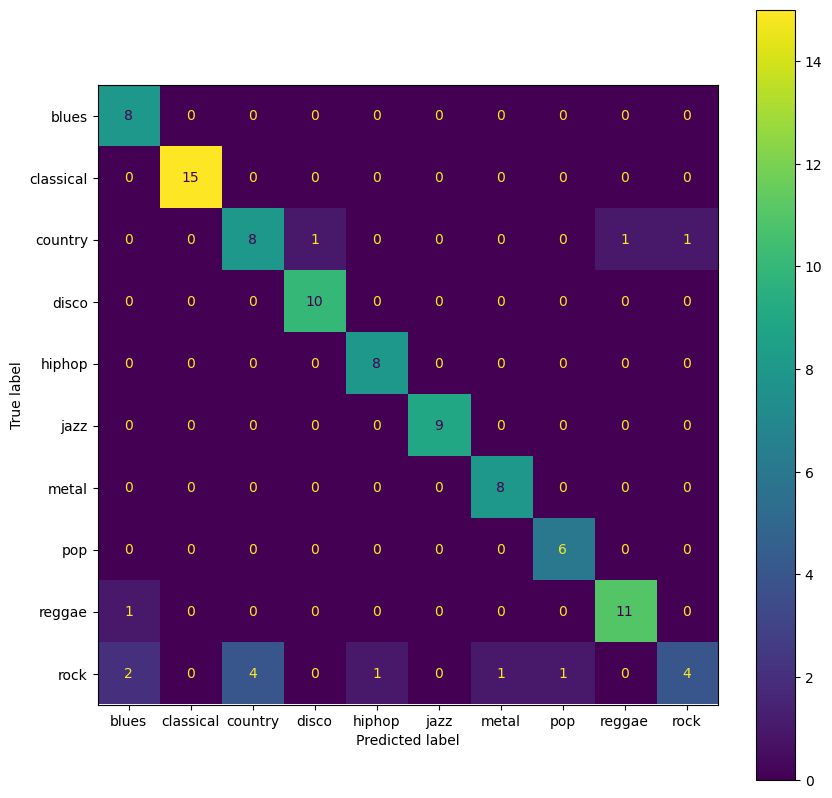

In [ ]:
pred=trainer.predict(gtzan_encoded["test"].with_format("torch"))
print(pred.metrics)
confusion_matrix=metrics.confusion_matrix(pred.label_ids, np.argmax(pred.predictions, axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(label2id.keys()))
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
if not os.path.exists("images"):
  os.mkdir("images")
fig.savefig(os.path.join("images","Test_confusion_matrix.jpg"))
plt.show()